<center>
<h1></h1>
<h1 dir=rtl>
******************************************************************************<br>
Find Similar Images using Locality Sensitive Hashing
******************************************************************************<br>

</h1>
</center>

In [1]:
# Download the Oxford 102 Flower Dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar -xf 102flowers.tgz

--2024-11-17 19:28:56--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2024-11-17 19:28:56--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2024-11-17 19:28:57--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat


URL transformed to HTTPS due to an HSTS policy
--2024-11-17 19:29:16--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat [following]
--2024-11-17 19:29:17--  https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2024-11-17 19:29:18 (165 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [3]:
train_images = "/content/jpg"

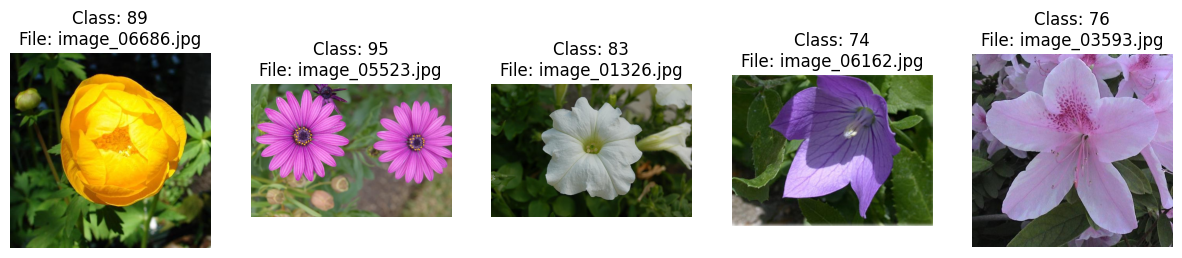

In [4]:
from scipy.io import loadmat
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(32)

labels_data = loadmat('/content/imagelabels.mat')
labels = labels_data['labels'][0]

image_folder = 'jpg'
images = os.listdir(image_folder)

num_images_to_plot = 5
random_indices = random.sample(range(len(images)), num_images_to_plot)

# Plot the random images with their labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    image_path = os.path.join(image_folder, images[idx])
    image = Image.open(image_path)

    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Class: {labels[idx]}\nFile: {images[idx]}")

plt.show()


In [5]:
import os
from PIL import Image
from torchvision import transforms

input_dim = (224, 224)
input_dir_cnn = "images/input_images_cnn"
os.makedirs(input_dir_cnn, exist_ok=True)

transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])

for image_name in os.listdir(train_images):
    image_path = os.path.join(image_folder, image_name)
    I = Image.open(image_path)

    newI = transformation_for_cnn_input(I)

    new_image_path = os.path.join(input_dir_cnn, image_name)
    newI.save(new_image_path)

    newI.close()
    I.close()

print("Images resized and saved in", input_dir_cnn)


Images resized and saved in images/input_images_cnn


In [6]:
import torch
from torchvision import models, transforms
import torch.nn as nn

class Img2VecEfficientNetB0():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.numberFeatures = 1280
        self.modelName = "efficientnet_b0"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def getFeatureLayer(self):
        cnnModel = models.efficientnet_b0(pretrained=True)
        layer = nn.Sequential(*list(cnnModel.children())[:-1])
        self.layer_output_size = 1280
        return cnnModel, layer

    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)

        with torch.no_grad():
            features = self.featureLayer(image)

        return features.squeeze().cpu().numpy()


In [7]:
from tqdm import tqdm
import os
from PIL import Image
img2vec = Img2VecEfficientNetB0()
allVectors = {}
for image in tqdm(os.listdir(input_dir_cnn)):
  I = Image.open(os.path.join(input_dir_cnn, image))
  I_rgb = I.convert('RGB')
  print (image)
  vec = img2vec.getVec(I_rgb)
  allVectors[image] = vec
  I.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]
  0%|          | 0/8189 [00:00<?, ?it/s]

image_07702.jpg


  0%|          | 11/8189 [00:01<09:21, 14.57it/s] 

image_02701.jpg
image_05061.jpg
image_08104.jpg
image_04844.jpg
image_01294.jpg
image_00754.jpg
image_07173.jpg
image_01893.jpg
image_06027.jpg
image_02150.jpg
image_05958.jpg
image_03341.jpg
image_04020.jpg
image_03574.jpg
image_06420.jpg
image_05444.jpg
image_04206.jpg
image_02297.jpg
image_01658.jpg
image_02458.jpg


  0%|          | 31/8189 [00:01<03:17, 41.27it/s]

image_01312.jpg
image_01445.jpg
image_06439.jpg
image_06135.jpg
image_04479.jpg
image_06360.jpg
image_06498.jpg
image_05738.jpg
image_07627.jpg
image_02207.jpg
image_05847.jpg
image_03744.jpg
image_01348.jpg
image_04262.jpg
image_06983.jpg
image_08136.jpg
image_03030.jpg
image_03590.jpg
image_01356.jpg
image_06937.jpg


  1%|          | 51/8189 [00:01<02:08, 63.20it/s]

image_00778.jpg
image_03774.jpg
image_02101.jpg
image_00162.jpg
image_05732.jpg
image_00192.jpg
image_01117.jpg
image_03769.jpg
image_08067.jpg
image_08041.jpg
image_07955.jpg
image_03190.jpg
image_04979.jpg
image_01082.jpg
image_04647.jpg
image_04500.jpg
image_06453.jpg
image_03342.jpg
image_05294.jpg

  1%|          | 71/8189 [00:01<01:48, 74.56it/s]


image_04813.jpg
image_05894.jpg
image_03277.jpg
image_04456.jpg
image_07512.jpg
image_00278.jpg
image_02837.jpg
image_00884.jpg
image_07406.jpg
image_06249.jpg
image_01288.jpg
image_00868.jpg
image_07312.jpg
image_04668.jpg
image_03676.jpg
image_01555.jpg
image_03543.jpg
image_03749.jpg


  1%|          | 91/8189 [00:01<01:35, 84.83it/s]

image_06680.jpg
image_02571.jpg
image_03592.jpg
image_02809.jpg
image_05619.jpg
image_02978.jpg
image_02725.jpg
image_00892.jpg
image_03800.jpg
image_02814.jpg
image_07747.jpg
image_01287.jpg
image_02246.jpg
image_00634.jpg
image_02918.jpg
image_07417.jpg
image_04725.jpg
image_03471.jpg
image_04906.jpg
image_04526.jpg


  1%|▏         | 111/8189 [00:02<01:30, 89.18it/s]

image_01031.jpg
image_04046.jpg
image_06922.jpg
image_01942.jpg
image_07066.jpg
image_06103.jpg
image_05739.jpg
image_04121.jpg
image_00047.jpg
image_01049.jpg
image_05683.jpg
image_05783.jpg
image_07719.jpg
image_05200.jpg
image_03155.jpg
image_03101.jpg
image_06835.jpg
image_03462.jpg
image_05773.jpg
image_07931.jpg


  2%|▏         | 131/8189 [00:02<01:27, 92.43it/s]

image_03743.jpg
image_08098.jpg
image_02524.jpg
image_02312.jpg
image_02944.jpg
image_03857.jpg
image_05239.jpg
image_01944.jpg
image_04544.jpg
image_03120.jpg
image_07409.jpg
image_00270.jpg
image_04696.jpg
image_08088.jpg
image_05033.jpg
image_03648.jpg
image_05269.jpg
image_06198.jpg
image_02214.jpg
image_02228.jpg


  2%|▏         | 151/8189 [00:02<01:30, 89.01it/s]

image_05335.jpg
image_02580.jpg
image_05222.jpg
image_00995.jpg
image_00624.jpg
image_07021.jpg
image_05607.jpg
image_04817.jpg
image_07587.jpg
image_04970.jpg
image_05936.jpg
image_08161.jpg
image_05560.jpg
image_07566.jpg
image_03392.jpg
image_06172.jpg
image_06523.jpg


  2%|▏         | 172/8189 [00:02<01:28, 90.89it/s]

image_06445.jpg
image_04591.jpg
image_01141.jpg
image_06846.jpg
image_00279.jpg
image_01665.jpg
image_01454.jpg
image_06929.jpg
image_06693.jpg
image_06707.jpg
image_00462.jpg
image_06197.jpg
image_03165.jpg
image_01616.jpg
image_08146.jpg
image_02341.jpg
image_06715.jpg
image_05275.jpg
image_07616.jpg
image_01644.jpg


  2%|▏         | 192/8189 [00:02<01:25, 93.08it/s]

image_03726.jpg
image_00084.jpg
image_07783.jpg
image_06492.jpg
image_01785.jpg
image_05632.jpg
image_03713.jpg
image_05480.jpg
image_04241.jpg
image_06335.jpg
image_05216.jpg
image_06429.jpg
image_05981.jpg
image_06073.jpg
image_05296.jpg
image_01084.jpg
image_02393.jpg
image_00203.jpg
image_04758.jpg
image_02612.jpg


  3%|▎         | 212/8189 [00:03<01:25, 93.68it/s]

image_06407.jpg
image_03255.jpg
image_07799.jpg
image_08125.jpg
image_08034.jpg
image_03408.jpg
image_01143.jpg
image_01655.jpg
image_06551.jpg
image_06297.jpg
image_04142.jpg
image_02962.jpg
image_05961.jpg
image_05823.jpg
image_01982.jpg
image_06455.jpg
image_06426.jpg
image_02889.jpg
image_07767.jpg
image_07731.jpg


  3%|▎         | 232/8189 [00:03<01:23, 94.83it/s]

image_04597.jpg
image_04299.jpg
image_07495.jpg
image_00906.jpg
image_07257.jpg
image_05678.jpg
image_01622.jpg
image_03816.jpg
image_01367.jpg
image_07705.jpg
image_07347.jpg
image_00459.jpg
image_07572.jpg
image_06381.jpg
image_04910.jpg
image_06032.jpg
image_01800.jpg
image_06987.jpg
image_08066.jpg
image_05882.jpg


  3%|▎         | 252/8189 [00:03<01:27, 90.52it/s]

image_04089.jpg
image_06518.jpg
image_05315.jpg
image_00392.jpg
image_02544.jpg
image_05700.jpg
image_00770.jpg
image_02036.jpg
image_03197.jpg
image_01120.jpg
image_03438.jpg
image_00915.jpg
image_00522.jpg
image_04279.jpg
image_06228.jpg
image_00723.jpg
image_05000.jpg
image_02974.jpg


  3%|▎         | 262/8189 [00:03<01:29, 88.83it/s]

image_07125.jpg
image_00948.jpg
image_03328.jpg
image_01823.jpg
image_04603.jpg
image_00324.jpg
image_06848.jpg
image_02477.jpg
image_05206.jpg
image_03269.jpg
image_04264.jpg
image_04219.jpg
image_05972.jpg
image_04791.jpg
image_00527.jpg
image_05285.jpg
image_00643.jpg
image_04769.jpg
image_02641.jpg


  3%|▎         | 282/8189 [00:03<01:26, 91.75it/s]

image_05789.jpg
image_04471.jpg
image_03809.jpg
image_00511.jpg
image_04136.jpg
image_06137.jpg
image_03053.jpg
image_05652.jpg
image_07474.jpg
image_03929.jpg
image_04628.jpg
image_06727.jpg
image_05890.jpg
image_06975.jpg
image_06153.jpg
image_00771.jpg
image_00426.jpg
image_07114.jpg
image_07444.jpg
image_04778.jpg


  4%|▎         | 302/8189 [00:04<01:25, 92.31it/s]

image_05181.jpg
image_05896.jpg
image_07435.jpg
image_07786.jpg
image_02568.jpg
image_02005.jpg
image_05359.jpg
image_03591.jpg
image_00068.jpg
image_00368.jpg
image_04418.jpg
image_05927.jpg
image_02335.jpg
image_03273.jpg
image_07006.jpg
image_01335.jpg
image_00941.jpg
image_07856.jpg
image_03984.jpg
image_06329.jpg


  4%|▍         | 322/8189 [00:04<01:24, 93.19it/s]

image_01314.jpg
image_06709.jpg
image_03253.jpg
image_00709.jpg
image_02705.jpg
image_06471.jpg
image_01798.jpg
image_00101.jpg
image_01389.jpg
image_02148.jpg
image_01065.jpg
image_02305.jpg
image_04689.jpg
image_00969.jpg
image_01105.jpg
image_02023.jpg
image_02215.jpg
image_06311.jpg
image_06643.jpg
image_04879.jpg


  4%|▍         | 342/8189 [00:04<01:29, 87.78it/s]

image_04462.jpg
image_05130.jpg
image_04542.jpg
image_06338.jpg
image_04649.jpg
image_01303.jpg
image_06592.jpg
image_04071.jpg
image_08167.jpg
image_00565.jpg
image_04830.jpg
image_06239.jpg
image_01012.jpg
image_06611.jpg
image_03304.jpg
image_04239.jpg
image_06195.jpg
image_06719.jpg


  4%|▍         | 362/8189 [00:04<01:24, 92.28it/s]

image_07251.jpg
image_01725.jpg
image_01731.jpg
image_01309.jpg
image_04464.jpg
image_02057.jpg
image_02621.jpg
image_07396.jpg
image_00910.jpg
image_06165.jpg
image_07711.jpg
image_05722.jpg
image_07432.jpg
image_00516.jpg
image_07140.jpg
image_07484.jpg
image_06883.jpg
image_04291.jpg
image_02569.jpg
image_07923.jpg


  5%|▍         | 382/8189 [00:05<01:23, 93.21it/s]

image_03227.jpg
image_07237.jpg
image_00658.jpg
image_04955.jpg
image_06376.jpg
image_02592.jpg
image_07232.jpg
image_05524.jpg
image_01017.jpg
image_04273.jpg
image_03631.jpg
image_02912.jpg
image_00767.jpg
image_07762.jpg
image_03413.jpg
image_01353.jpg
image_03548.jpg
image_03844.jpg
image_00839.jpg
image_03060.jpg


  5%|▍         | 402/8189 [00:05<01:34, 82.52it/s]

image_01764.jpg
image_02798.jpg
image_02240.jpg
image_06675.jpg
image_04303.jpg
image_00796.jpg
image_02737.jpg
image_01476.jpg
image_04883.jpg
image_01541.jpg
image_07509.jpg
image_04408.jpg
image_06569.jpg
image_03662.jpg


  5%|▌         | 411/8189 [00:05<01:41, 76.67it/s]

image_01278.jpg
image_00465.jpg
image_02011.jpg
image_07746.jpg
image_01436.jpg
image_06111.jpg
image_00449.jpg
image_06742.jpg
image_02399.jpg
image_04700.jpg
image_06124.jpg
image_06247.jpg
image_02833.jpg
image_03192.jpg


  5%|▌         | 427/8189 [00:05<01:48, 71.37it/s]

image_06768.jpg
image_03391.jpg
image_00865.jpg
image_01381.jpg
image_01090.jpg
image_07012.jpg
image_06245.jpg
image_01747.jpg
image_03230.jpg
image_07602.jpg
image_06729.jpg
image_03268.jpg
image_01984.jpg
image_04167.jpg


  5%|▌         | 443/8189 [00:05<01:47, 72.31it/s]

image_01820.jpg
image_07240.jpg
image_05962.jpg
image_03294.jpg
image_01181.jpg
image_07695.jpg
image_05492.jpg
image_02954.jpg
image_05918.jpg
image_06786.jpg
image_01816.jpg
image_07626.jpg
image_02894.jpg
image_05814.jpg
image_01975.jpg
image_04296.jpg


  6%|▌         | 460/8189 [00:06<01:42, 75.21it/s]

image_01470.jpg
image_05672.jpg
image_03549.jpg
image_02943.jpg
image_07388.jpg
image_01965.jpg
image_03223.jpg
image_00393.jpg
image_03531.jpg
image_05180.jpg
image_02694.jpg
image_02145.jpg
image_00756.jpg
image_04383.jpg
image_00178.jpg
image_03216.jpg


  6%|▌         | 476/8189 [00:06<01:42, 74.99it/s]

image_03365.jpg
image_01093.jpg
image_01773.jpg
image_04426.jpg
image_04925.jpg
image_03473.jpg
image_02573.jpg
image_02600.jpg
image_04520.jpg
image_04343.jpg
image_02403.jpg
image_00618.jpg
image_05625.jpg
image_02155.jpg
image_02325.jpg


  6%|▌         | 484/8189 [00:06<01:48, 70.76it/s]

image_00589.jpg
image_03201.jpg
image_02332.jpg
image_01550.jpg
image_06344.jpg
image_05119.jpg
image_04022.jpg
image_00356.jpg
image_04348.jpg
image_04397.jpg
image_02975.jpg
image_04782.jpg
image_01340.jpg


  6%|▌         | 499/8189 [00:06<01:54, 67.35it/s]

image_02597.jpg
image_03301.jpg
image_05579.jpg
image_06444.jpg
image_07919.jpg
image_01806.jpg
image_02708.jpg
image_00035.jpg
image_02410.jpg
image_02141.jpg
image_03906.jpg
image_04559.jpg
image_03831.jpg


  6%|▋         | 513/8189 [00:06<01:58, 64.75it/s]

image_01412.jpg
image_00073.jpg
image_01572.jpg
image_07027.jpg
image_03454.jpg
image_02971.jpg
image_03340.jpg
image_07493.jpg
image_05288.jpg
image_02358.jpg
image_02967.jpg
image_01871.jpg
image_01139.jpg


  6%|▋         | 527/8189 [00:07<02:00, 63.39it/s]

image_07714.jpg
image_00605.jpg
image_03059.jpg
image_00925.jpg
image_06604.jpg
image_06229.jpg
image_04404.jpg
image_04918.jpg
image_05209.jpg
image_01969.jpg
image_04492.jpg
image_00114.jpg
image_04317.jpg


  7%|▋         | 541/8189 [00:07<02:11, 58.21it/s]

image_06037.jpg
image_03149.jpg
image_02828.jpg
image_07485.jpg
image_05471.jpg
image_03377.jpg
image_02972.jpg
image_03463.jpg
image_07993.jpg
image_03986.jpg
image_02417.jpg


  7%|▋         | 547/8189 [00:07<02:16, 55.79it/s]

image_07449.jpg
image_06002.jpg
image_07913.jpg
image_03402.jpg
image_00138.jpg
image_07274.jpg
image_00835.jpg
image_07496.jpg
image_02199.jpg
image_04521.jpg
image_03703.jpg


  7%|▋         | 559/8189 [00:07<02:22, 53.60it/s]

image_06385.jpg
image_08174.jpg
image_01094.jpg
image_05650.jpg
image_03263.jpg
image_08094.jpg
image_00247.jpg
image_00079.jpg
image_07033.jpg
image_04756.jpg
image_08091.jpg


  7%|▋         | 571/8189 [00:07<02:26, 52.10it/s]

image_04924.jpg
image_04861.jpg
image_01651.jpg
image_04961.jpg
image_03327.jpg
image_04029.jpg
image_03481.jpg
image_04985.jpg
image_07425.jpg
image_07812.jpg
image_00057.jpg


  7%|▋         | 583/8189 [00:08<02:26, 51.81it/s]

image_01401.jpg
image_04997.jpg
image_07800.jpg
image_00919.jpg
image_04637.jpg
image_01106.jpg
image_01083.jpg
image_07231.jpg
image_03805.jpg
image_07049.jpg
image_01341.jpg


  7%|▋         | 595/8189 [00:08<02:26, 51.80it/s]

image_06248.jpg
image_01429.jpg
image_00551.jpg
image_03249.jpg
image_06231.jpg
image_08070.jpg
image_01390.jpg
image_06893.jpg
image_00788.jpg
image_03047.jpg
image_06019.jpg


  7%|▋         | 612/8189 [00:08<01:52, 67.39it/s]

image_05228.jpg
image_04080.jpg
image_02031.jpg
image_04351.jpg
image_08075.jpg
image_00248.jpg
image_00807.jpg
image_01606.jpg
image_06843.jpg
image_07841.jpg
image_07890.jpg
image_03609.jpg
image_03623.jpg
image_01914.jpg
image_00265.jpg
image_04384.jpg
image_05885.jpg
image_07316.jpg


  8%|▊         | 631/8189 [00:08<01:36, 78.72it/s]

image_01976.jpg
image_03612.jpg
image_06818.jpg
image_00610.jpg
image_05406.jpg
image_08164.jpg
image_01711.jpg
image_03684.jpg
image_02416.jpg
image_00532.jpg
image_01060.jpg
image_05352.jpg
image_06063.jpg
image_01076.jpg
image_08183.jpg
image_07112.jpg
image_01231.jpg
image_01991.jpg
image_00055.jpg
image_06686.jpg


  8%|▊         | 651/8189 [00:09<01:25, 87.93it/s]

image_04789.jpg
image_06496.jpg
image_05251.jpg
image_03670.jpg
image_04511.jpg
image_02073.jpg
image_04592.jpg
image_01000.jpg
image_00998.jpg
image_02440.jpg
image_03144.jpg
image_04960.jpg
image_07516.jpg
image_07882.jpg
image_00940.jpg
image_07552.jpg
image_04708.jpg
image_07224.jpg
image_07898.jpg
image_04807.jpg


  8%|▊         | 670/8189 [00:09<01:22, 90.67it/s]

image_04607.jpg
image_00664.jpg
image_05302.jpg
image_03979.jpg
image_06255.jpg
image_04251.jpg
image_03657.jpg
image_02786.jpg
image_00785.jpg
image_02112.jpg
image_05790.jpg
image_06075.jpg
image_03782.jpg
image_01330.jpg
image_03519.jpg
image_02790.jpg
image_00508.jpg
image_00198.jpg
image_00555.jpg
image_06590.jpg


  8%|▊         | 690/8189 [00:09<01:21, 91.79it/s]

image_01497.jpg
image_01069.jpg
image_07466.jpg
image_07967.jpg
image_00197.jpg
image_00424.jpg
image_01739.jpg
image_02013.jpg
image_05463.jpg
image_04872.jpg
image_03222.jpg
image_06403.jpg
image_03023.jpg
image_06723.jpg
image_01155.jpg
image_02134.jpg
image_00249.jpg
image_01889.jpg


  9%|▊         | 709/8189 [00:09<01:24, 88.11it/s]

image_01357.jpg
image_00486.jpg
image_01465.jpg
image_04012.jpg
image_07228.jpg
image_00051.jpg
image_04661.jpg
image_04249.jpg
image_01787.jpg
image_00491.jpg
image_06718.jpg
image_04514.jpg
image_01777.jpg
image_04506.jpg
image_02184.jpg
image_07220.jpg
image_06129.jpg
image_02048.jpg
image_00602.jpg


  9%|▉         | 729/8189 [00:09<01:21, 91.98it/s]

image_05859.jpg
image_03088.jpg
image_06539.jpg
image_02363.jpg
image_01509.jpg
image_07721.jpg
image_05945.jpg
image_04294.jpg
image_02170.jpg
image_02922.jpg
image_02731.jpg
image_00685.jpg
image_05373.jpg
image_03211.jpg
image_03409.jpg
image_07218.jpg
image_06833.jpg
image_02553.jpg
image_08153.jpg
image_06841.jpg


  9%|▉         | 749/8189 [00:10<01:18, 94.68it/s]

image_05881.jpg
image_02362.jpg
image_01910.jpg
image_00252.jpg
image_03801.jpg
image_06814.jpg
image_01527.jpg
image_03422.jpg
image_02846.jpg
image_00327.jpg
image_04755.jpg
image_00797.jpg
image_03990.jpg
image_01256.jpg
image_02121.jpg
image_03673.jpg
image_06631.jpg
image_06917.jpg
image_01009.jpg
image_07726.jpg


  9%|▉         | 769/8189 [00:10<01:18, 94.67it/s]

image_03089.jpg
image_00348.jpg
image_00171.jpg
image_07681.jpg
image_05955.jpg
image_02106.jpg
image_05960.jpg
image_06099.jpg
image_08119.jpg
image_04265.jpg
image_06890.jpg
image_00301.jpg
image_07850.jpg
image_08155.jpg
image_04477.jpg
image_06821.jpg
image_05327.jpg
image_03478.jpg
image_03988.jpg
image_07458.jpg


 10%|▉         | 789/8189 [00:10<01:21, 90.96it/s]

image_02570.jpg
image_00990.jpg
image_04682.jpg
image_04147.jpg
image_01125.jpg
image_01449.jpg
image_07263.jpg
image_01300.jpg
image_03566.jpg
image_03544.jpg
image_04564.jpg
image_04531.jpg
image_01943.jpg
image_04571.jpg
image_01404.jpg
image_08045.jpg
image_05592.jpg
image_07816.jpg


 10%|▉         | 799/8189 [00:10<01:20, 92.20it/s]

image_00712.jpg
image_01016.jpg
image_00134.jpg
image_00817.jpg
image_05392.jpg
image_02735.jpg
image_00850.jpg
image_05426.jpg
image_01129.jpg
image_00942.jpg
image_05449.jpg
image_03042.jpg
image_05861.jpg
image_04831.jpg
image_05104.jpg
image_04836.jpg
image_07975.jpg
image_06433.jpg
image_06574.jpg


 10%|█         | 819/8189 [00:10<01:20, 91.26it/s]

image_08129.jpg
image_01495.jpg
image_07985.jpg
image_03659.jpg
image_06868.jpg
image_01959.jpg
image_08175.jpg
image_03239.jpg
image_04116.jpg
image_01364.jpg
image_02901.jpg
image_06968.jpg
image_05555.jpg
image_06082.jpg
image_06081.jpg
image_04892.jpg
image_06964.jpg
image_06606.jpg
image_03156.jpg


 10%|█         | 839/8189 [00:11<01:20, 91.83it/s]

image_03520.jpg
image_06972.jpg
image_06203.jpg
image_04342.jpg
image_03838.jpg
image_06026.jpg
image_00841.jpg
image_06842.jpg
image_01471.jpg
image_00123.jpg
image_04903.jpg
image_04095.jpg
image_07476.jpg
image_05642.jpg
image_06724.jpg
image_07348.jpg
image_07693.jpg
image_01919.jpg
image_02369.jpg
image_00264.jpg


 10%|█         | 859/8189 [00:11<01:18, 93.39it/s]

image_01284.jpg
image_05988.jpg
image_07478.jpg
image_00306.jpg
image_03228.jpg
image_03582.jpg
image_00433.jpg
image_03882.jpg
image_04622.jpg
image_04896.jpg
image_04587.jpg
image_07467.jpg
image_06711.jpg
image_00175.jpg
image_04386.jpg
image_04690.jpg
image_06140.jpg
image_05513.jpg
image_01955.jpg
image_05908.jpg


 11%|█         | 879/8189 [00:11<01:21, 90.13it/s]

image_02503.jpg
image_02617.jpg
image_04992.jpg
image_04914.jpg
image_05237.jpg
image_05942.jpg
image_04169.jpg
image_04094.jpg
image_08188.jpg
image_03368.jpg
image_00759.jpg
image_07384.jpg
image_06175.jpg
image_06368.jpg
image_00464.jpg
image_06465.jpg
image_05597.jpg
image_01886.jpg


 11%|█         | 899/8189 [00:11<01:21, 89.54it/s]

image_01913.jpg
image_01803.jpg
image_07528.jpg
image_05617.jpg
image_06466.jpg
image_04822.jpg
image_05281.jpg
image_03704.jpg
image_07158.jpg
image_01715.jpg
image_02817.jpg
image_02146.jpg
image_00455.jpg
image_05270.jpg
image_05855.jpg
image_06899.jpg
image_05177.jpg
image_03919.jpg


 11%|█         | 918/8189 [00:11<01:19, 91.58it/s]

image_07697.jpg
image_02685.jpg
image_03357.jpg
image_01691.jpg
image_01760.jpg
image_05149.jpg
image_07865.jpg
image_00791.jpg
image_05605.jpg
image_03742.jpg
image_05792.jpg
image_01748.jpg
image_05264.jpg
image_06122.jpg
image_00591.jpg
image_04518.jpg
image_02934.jpg
image_03735.jpg
image_01501.jpg
image_04430.jpg


 11%|█▏        | 938/8189 [00:12<01:17, 93.46it/s]

image_00541.jpg
image_05390.jpg
image_02346.jpg
image_05895.jpg
image_03550.jpg
image_04052.jpg
image_01911.jpg
image_00107.jpg
image_02064.jpg
image_07400.jpg
image_02437.jpg
image_06093.jpg
image_03896.jpg
image_07324.jpg
image_03034.jpg
image_03585.jpg
image_06728.jpg
image_01220.jpg
image_05820.jpg
image_02639.jpg


 12%|█▏        | 958/8189 [00:12<01:17, 93.60it/s]

image_08189.jpg
image_05344.jpg
image_01809.jpg
image_04295.jpg
image_02908.jpg
image_01238.jpg
image_07717.jpg
image_01388.jpg
image_04581.jpg
image_03490.jpg
image_05252.jpg
image_02805.jpg
image_05282.jpg
image_07827.jpg
image_01402.jpg
image_01772.jpg
image_04943.jpg
image_07302.jpg
image_03072.jpg
image_02470.jpg


 12%|█▏        | 978/8189 [00:12<01:18, 91.81it/s]

image_03339.jpg
image_03578.jpg
image_00947.jpg
image_07489.jpg
image_04664.jpg
image_04380.jpg
image_07470.jpg
image_06060.jpg
image_07132.jpg
image_00676.jpg
image_00873.jpg
image_06620.jpg
image_01822.jpg
image_00920.jpg
image_04035.jpg
image_07988.jpg
image_04463.jpg
image_02900.jpg


 12%|█▏        | 998/8189 [00:12<01:19, 90.69it/s]

image_05008.jpg
image_06320.jpg
image_00644.jpg
image_05353.jpg
image_01504.jpg
image_06676.jpg
image_07227.jpg
image_02149.jpg
image_04135.jpg
image_04308.jpg
image_00479.jpg
image_00027.jpg
image_07394.jpg
image_02905.jpg
image_05963.jpg
image_00364.jpg
image_06509.jpg
image_00993.jpg
image_06279.jpg


 12%|█▏        | 1018/8189 [00:13<01:16, 93.87it/s]

image_01939.jpg
image_01852.jpg
image_03501.jpg
image_05723.jpg
image_06805.jpg
image_00025.jpg
image_04304.jpg
image_03212.jpg
image_07276.jpg
image_05498.jpg
image_07871.jpg
image_05902.jpg
image_01342.jpg
image_02665.jpg
image_02564.jpg
image_00801.jpg
image_05254.jpg
image_07205.jpg
image_04283.jpg
image_00494.jpg


 13%|█▎        | 1038/8189 [00:13<01:15, 94.20it/s]

image_06710.jpg
image_03541.jpg
image_06194.jpg
image_04323.jpg
image_03890.jpg
image_06306.jpg
image_00538.jpg
image_04171.jpg
image_02847.jpg
image_01561.jpg
image_02796.jpg
image_07579.jpg
image_04527.jpg
image_01668.jpg
image_02771.jpg
image_02104.jpg
image_02275.jpg
image_07789.jpg
image_04860.jpg
image_03373.jpg


 13%|█▎        | 1058/8189 [00:13<01:14, 95.27it/s]

image_02225.jpg
image_07836.jpg
image_06823.jpg
image_04228.jpg
image_02637.jpg
image_08092.jpg
image_03888.jpg
image_01365.jpg
image_04395.jpg
image_02652.jpg
image_01081.jpg
image_05205.jpg
image_06158.jpg
image_03474.jpg
image_07364.jpg
image_01062.jpg
image_07407.jpg
image_00750.jpg
image_01137.jpg


 13%|█▎        | 1078/8189 [00:13<01:16, 92.82it/s]

image_00360.jpg
image_06755.jpg
image_07933.jpg
image_02906.jpg
image_00856.jpg
image_07922.jpg
image_01906.jpg
image_03555.jpg
image_00751.jpg
image_01063.jpg
image_01451.jpg
image_01837.jpg
image_07498.jpg
image_03254.jpg
image_00148.jpg
image_00739.jpg
image_02402.jpg
image_02956.jpg
image_05309.jpg


 13%|█▎        | 1088/8189 [00:13<01:18, 91.01it/s]

image_07070.jpg
image_00022.jpg
image_01025.jpg
image_04184.jpg
image_00564.jpg
image_05287.jpg
image_05022.jpg
image_05622.jpg
image_00735.jpg
image_02299.jpg
image_00958.jpg
image_04325.jpg
image_00744.jpg
image_07897.jpg
image_06431.jpg
image_03600.jpg
image_06295.jpg
image_07416.jpg
image_01604.jpg


 14%|█▎        | 1108/8189 [00:14<01:17, 91.70it/s]

image_00440.jpg
image_00155.jpg
image_02414.jpg
image_00399.jpg
image_01566.jpg
image_06046.jpg
image_00038.jpg
image_06468.jpg
image_01646.jpg
image_05095.jpg
image_03797.jpg
image_03148.jpg
image_01085.jpg
image_08095.jpg
image_05636.jpg
image_00894.jpg
image_03946.jpg
image_03176.jpg
image_03329.jpg
image_03708.jpg


 14%|█▍        | 1128/8189 [00:14<01:17, 90.85it/s]

image_06942.jpg
image_05540.jpg
image_04335.jpg
image_02384.jpg
image_07723.jpg
image_04757.jpg
image_07927.jpg
image_01307.jpg
image_03815.jpg
image_05317.jpg
image_04828.jpg
image_05651.jpg
image_05433.jpg
image_00403.jpg
image_01721.jpg
image_04796.jpg
image_01233.jpg
image_00473.jpg
image_01768.jpg


 14%|█▍        | 1148/8189 [00:14<01:15, 93.30it/s]

image_05925.jpg
image_05689.jpg
image_06423.jpg
image_06305.jpg
image_04238.jpg
image_07609.jpg
image_03981.jpg
image_01978.jpg
image_00657.jpg
image_03025.jpg
image_02382.jpg
image_01568.jpg
image_01124.jpg
image_06441.jpg
image_03351.jpg
image_00639.jpg
image_03842.jpg
image_04814.jpg


 14%|█▍        | 1168/8189 [00:14<01:15, 92.39it/s]

image_00072.jpg
image_00989.jpg
image_01878.jpg
image_05374.jpg
image_06830.jpg
image_07110.jpg
image_04819.jpg
image_06789.jpg
image_01744.jpg
image_04482.jpg
image_02453.jpg
image_02773.jpg
image_02684.jpg
image_02208.jpg
image_00826.jpg
image_04524.jpg
image_03472.jpg
image_07707.jpg
image_03500.jpg
image_00119.jpg


 15%|█▍        | 1188/8189 [00:14<01:16, 91.63it/s]

image_00410.jpg
image_05107.jpg
image_00876.jpg
image_08144.jpg
image_04483.jpg
image_03795.jpg
image_02256.jpg
image_07547.jpg
image_07851.jpg
image_06162.jpg
image_00152.jpg
image_03932.jpg
image_08058.jpg
image_08054.jpg
image_06110.jpg
image_07994.jpg
image_04345.jpg
image_01061.jpg
image_01039.jpg


 15%|█▍        | 1208/8189 [00:15<01:14, 94.05it/s]

image_02678.jpg
image_06616.jpg
image_05223.jpg
image_04523.jpg
image_02383.jpg
image_01148.jpg
image_00891.jpg
image_05453.jpg
image_04179.jpg
image_05516.jpg
image_01260.jpg
image_02071.jpg
image_01818.jpg
image_04082.jpg
image_06326.jpg
image_03834.jpg
image_00357.jpg
image_04185.jpg
image_02632.jpg
image_03291.jpg


 15%|█▍        | 1228/8189 [00:15<01:13, 94.61it/s]

image_02459.jpg
image_00318.jpg
image_00330.jpg
image_04436.jpg
image_00738.jpg
image_01597.jpg
image_02280.jpg
image_05289.jpg
image_00344.jpg
image_05620.jpg
image_02931.jpg
image_04556.jpg
image_00117.jpg
image_04190.jpg
image_01041.jpg
image_04606.jpg
image_06436.jpg
image_05132.jpg
image_07683.jpg
image_05558.jpg


 15%|█▌        | 1248/8189 [00:15<01:16, 91.07it/s]

image_07696.jpg
image_04009.jpg
image_01123.jpg
image_06190.jpg
image_06479.jpg
image_04672.jpg
image_00233.jpg
image_05737.jpg
image_01034.jpg
image_05481.jpg
image_04087.jpg
image_05497.jpg
image_01345.jpg
image_01967.jpg
image_06181.jpg
image_05047.jpg
image_08007.jpg
image_07085.jpg


 15%|█▌        | 1268/8189 [00:15<01:15, 92.26it/s]

image_02614.jpg
image_04548.jpg
image_02654.jpg
image_05813.jpg
image_01628.jpg
image_00065.jpg
image_06690.jpg
image_06211.jpg
image_06625.jpg
image_06112.jpg
image_03381.jpg
image_06777.jpg
image_05383.jpg
image_06533.jpg
image_01050.jpg
image_01282.jpg
image_05653.jpg
image_08108.jpg
image_03652.jpg


 16%|█▌        | 1288/8189 [00:16<01:16, 90.11it/s]

image_05249.jpg
image_05150.jpg
image_01479.jpg
image_05609.jpg
image_07310.jpg
image_05194.jpg
image_04776.jpg
image_02198.jpg
image_05396.jpg
image_02367.jpg
image_06164.jpg
image_03977.jpg
image_06672.jpg
image_00223.jpg
image_03433.jpg
image_03107.jpg
image_06339.jpg
image_05818.jpg


 16%|█▌        | 1298/8189 [00:16<01:15, 91.08it/s]

image_01478.jpg
image_00690.jpg
image_03737.jpg
image_03790.jpg
image_06284.jpg
image_02175.jpg
image_00172.jpg
image_07094.jpg
image_07368.jpg
image_04843.jpg
image_07127.jpg
image_06163.jpg
image_04655.jpg
image_03448.jpg
image_05707.jpg
image_06910.jpg
image_05484.jpg
image_04105.jpg
image_04519.jpg


 16%|█▌        | 1318/8189 [00:16<01:16, 90.18it/s]

image_02422.jpg
image_06152.jpg
image_01425.jpg
image_07133.jpg
image_07748.jpg
image_04398.jpg
image_07229.jpg
image_01627.jpg
image_02601.jpg
image_07491.jpg
image_04313.jpg
image_07712.jpg
image_04886.jpg
image_05455.jpg
image_04221.jpg
image_01830.jpg
image_02633.jpg
image_00429.jpg
image_00240.jpg


 16%|█▋        | 1338/8189 [00:16<01:17, 88.30it/s]

image_01200.jpg
image_03232.jpg
image_02019.jpg
image_06345.jpg
image_01362.jpg
image_01586.jpg
image_01337.jpg
image_01391.jpg
image_03876.jpg
image_01678.jpg
image_00105.jpg
image_06215.jpg
image_05175.jpg
image_07222.jpg
image_02105.jpg
image_02445.jpg
image_05401.jpg
image_00963.jpg


 17%|█▋        | 1358/8189 [00:16<01:14, 91.79it/s]

image_04799.jpg
image_04452.jpg
image_06276.jpg
image_00074.jpg
image_02832.jpg
image_01847.jpg
image_07422.jpg
image_07962.jpg
image_07999.jpg
image_07089.jpg
image_06794.jpg
image_02074.jpg
image_01281.jpg
image_06438.jpg
image_02842.jpg
image_02187.jpg
image_06628.jpg
image_04014.jpg
image_02103.jpg
image_04512.jpg


 17%|█▋        | 1378/8189 [00:16<01:14, 91.40it/s]

image_00388.jpg
image_01638.jpg
image_07877.jpg
image_03823.jpg
image_05586.jpg
image_00454.jpg
image_04557.jpg
image_03174.jpg
image_07585.jpg
image_05628.jpg
image_03048.jpg
image_07039.jpg
image_00396.jpg
image_08078.jpg
image_01801.jpg
image_00081.jpg
image_05561.jpg
image_00490.jpg
image_00558.jpg


 17%|█▋        | 1398/8189 [00:17<01:13, 92.82it/s]

image_06545.jpg
image_07172.jpg
image_05016.jpg
image_04157.jpg
image_00103.jpg
image_04636.jpg
image_08159.jpg
image_03284.jpg
image_02139.jpg
image_02471.jpg
image_00755.jpg
image_05368.jpg
image_07210.jpg
image_07319.jpg
image_05849.jpg
image_00581.jpg
image_06346.jpg
image_01535.jpg
image_04441.jpg
image_02762.jpg


 17%|█▋        | 1418/8189 [00:17<01:14, 90.87it/s]

image_01932.jpg
image_00428.jpg
image_02002.jpg
image_03243.jpg
image_07744.jpg
image_01271.jpg
image_05791.jpg
image_07184.jpg
image_00418.jpg
image_04359.jpg
image_05727.jpg
image_02702.jpg
image_02838.jpg
image_03135.jpg
image_01582.jpg
image_03218.jpg
image_01154.jpg
image_04630.jpg


 18%|█▊        | 1438/8189 [00:17<01:16, 88.55it/s]

image_03941.jpg
image_04090.jpg
image_01532.jpg
image_02920.jpg
image_06232.jpg
image_05575.jpg
image_08113.jpg
image_05635.jpg
image_02825.jpg
image_03764.jpg
image_05941.jpg
image_02345.jpg
image_06343.jpg
image_04347.jpg
image_05040.jpg
image_03317.jpg
image_00793.jpg
image_05721.jpg


 18%|█▊        | 1457/8189 [00:17<01:14, 90.31it/s]

image_00394.jpg
image_03401.jpg
image_00603.jpg
image_03813.jpg
image_03597.jpg
image_07025.jpg
image_04298.jpg
image_04170.jpg
image_01626.jpg
image_02160.jpg
image_06581.jpg
image_07075.jpg
image_06056.jpg
image_07604.jpg
image_06513.jpg
image_06415.jpg
image_05646.jpg
image_03140.jpg
image_04820.jpg


 18%|█▊        | 1477/8189 [00:18<01:13, 91.30it/s]

image_02029.jpg
image_00828.jpg
image_05443.jpg
image_02254.jpg
image_00911.jpg
image_00705.jpg
image_01262.jpg
image_00013.jpg
image_05505.jpg
image_02043.jpg
image_01736.jpg
image_04651.jpg
image_01152.jpg
image_01338.jpg
image_05134.jpg
image_02677.jpg
image_03599.jpg
image_03094.jpg
image_00052.jpg


 18%|█▊        | 1497/8189 [00:18<01:12, 92.70it/s]

image_07597.jpg
image_05126.jpg
image_05768.jpg
image_06220.jpg
image_06098.jpg
image_02300.jpg
image_07329.jpg
image_07825.jpg
image_01215.jpg
image_05098.jpg
image_01333.jpg
image_03458.jpg
image_06881.jpg
image_06809.jpg
image_06559.jpg
image_04468.jpg
image_05398.jpg
image_08089.jpg
image_07226.jpg
image_03677.jpg


 18%|█▊        | 1507/8189 [00:18<01:11, 93.42it/s]

image_03241.jpg
image_05111.jpg
image_06504.jpg
image_05856.jpg
image_02428.jpg
image_07965.jpg
image_03167.jpg
image_00601.jpg
image_06269.jpg
image_00859.jpg
image_05139.jpg
image_04405.jpg
image_05807.jpg
image_03647.jpg
image_06085.jpg
image_04063.jpg
image_02108.jpg
image_04059.jpg
image_07982.jpg


 19%|█▊        | 1526/8189 [00:18<01:25, 78.26it/s]

image_03464.jpg
image_00303.jpg
image_05719.jpg
image_02158.jpg
image_03125.jpg
image_04929.jpg
image_06017.jpg
image_00773.jpg
image_07596.jpg
image_07953.jpg
image_07036.jpg
image_02451.jpg
image_03180.jpg


 19%|█▉        | 1543/8189 [00:18<01:28, 74.68it/s]

image_05331.jpg
image_00584.jpg
image_00094.jpg
image_08120.jpg
image_04025.jpg
image_06456.jpg
image_06708.jpg
image_04432.jpg
image_03961.jpg
image_04390.jpg
image_04722.jpg
image_00181.jpg
image_02449.jpg
image_06141.jpg


 19%|█▉        | 1559/8189 [00:19<01:29, 73.72it/s]

image_00245.jpg
image_01371.jpg
image_07102.jpg
image_05933.jpg
image_05408.jpg
image_00363.jpg
image_01902.jpg
image_06353.jpg
image_07645.jpg
image_01292.jpg
image_06363.jpg
image_05599.jpg
image_00594.jpg
image_05078.jpg
image_07283.jpg
image_08124.jpg

 19%|█▉        | 1567/8189 [00:19<01:30, 73.51it/s]


image_04096.jpg
image_01259.jpg
image_03138.jpg
image_06614.jpg
image_00845.jpg
image_01855.jpg
image_03922.jpg
image_05005.jpg
image_04763.jpg
image_06549.jpg
image_06410.jpg
image_03407.jpg
image_04259.jpg
image_06101.jpg


 19%|█▉        | 1583/8189 [00:19<01:33, 70.48it/s]

image_01202.jpg
image_06766.jpg
image_07233.jpg
image_02578.jpg
image_07497.jpg
image_07284.jpg
image_04106.jpg
image_04144.jpg
image_00100.jpg
image_01603.jpg
image_01857.jpg
image_01677.jpg
image_05193.jpg
image_05669.jpg


 20%|█▉        | 1599/8189 [00:19<01:31, 72.18it/s]

image_06177.jpg
image_05336.jpg
image_04563.jpg
image_05600.jpg
image_07064.jpg
image_04444.jpg
image_01393.jpg
image_01718.jpg
image_00389.jpg
image_01990.jpg
image_02815.jpg
image_06752.jpg
image_07964.jpg
image_08106.jpg
image_06681.jpg
image_02959.jpg


 20%|█▉        | 1615/8189 [00:19<01:36, 68.08it/s]

image_05999.jpg
image_03177.jpg
image_06524.jpg
image_08133.jpg
image_06740.jpg
image_05160.jpg
image_04407.jpg
image_06035.jpg
image_00641.jpg
image_04287.jpg
image_06044.jpg
image_08018.jpg
image_02022.jpg


 20%|█▉        | 1629/8189 [00:20<01:39, 65.94it/s]

image_07529.jpg
image_01274.jpg
image_04957.jpg
image_01937.jpg
image_05538.jpg
image_02518.jpg
image_04907.jpg
image_04337.jpg
image_00439.jpg
image_05966.jpg
image_05589.jpg
image_07593.jpg
image_00398.jpg
image_00717.jpg


 20%|██        | 1643/8189 [00:20<01:42, 63.64it/s]

image_01513.jpg
image_01193.jpg
image_05364.jpg
image_04083.jpg
image_01246.jpg
image_04748.jpg
image_01522.jpg
image_05680.jpg
image_00441.jpg
image_01313.jpg
image_04297.jpg
image_05145.jpg
image_05656.jpg


 20%|██        | 1657/8189 [00:20<01:42, 63.77it/s]

image_06548.jpg
image_06621.jpg
image_00909.jpg
image_01901.jpg
image_02219.jpg
image_00166.jpg
image_06696.jpg
image_06328.jpg
image_04051.jpg
image_04774.jpg
image_06151.jpg
image_07290.jpg
image_00854.jpg


 20%|██        | 1664/8189 [00:20<01:43, 63.16it/s]

image_04818.jpg
image_01591.jpg
image_00734.jpg
image_07831.jpg
image_02675.jpg
image_05133.jpg
image_07375.jpg
image_04457.jpg
image_02120.jpg
image_05394.jpg
image_01347.jpg
image_03092.jpg
image_03011.jpg


 20%|██        | 1677/8189 [00:20<01:54, 56.98it/s]

image_03160.jpg
image_04620.jpg
image_04611.jpg
image_06411.jpg
image_00642.jpg
image_03057.jpg
image_06364.jpg
image_06943.jpg
image_01957.jpg
image_00435.jpg
image_01375.jpg


 21%|██        | 1689/8189 [00:21<01:59, 54.41it/s]

image_07881.jpg
image_01452.jpg
image_04129.jpg
image_01925.jpg
image_03264.jpg
image_05445.jpg
image_01737.jpg
image_03272.jpg
image_05959.jpg
image_03173.jpg
image_02381.jpg


 21%|██        | 1701/8189 [00:21<02:02, 52.76it/s]

image_01780.jpg
image_07204.jpg
image_04788.jpg
image_07434.jpg
image_06193.jpg
image_00382.jpg
image_04800.jpg
image_01252.jpg
image_00188.jpg
image_02867.jpg
image_04485.jpg


 21%|██        | 1713/8189 [00:21<02:03, 52.23it/s]

image_01095.jpg
image_02804.jpg
image_06671.jpg
image_04613.jpg
image_01150.jpg
image_02946.jpg
image_00999.jpg
image_07285.jpg
image_06854.jpg
image_01789.jpg
image_01941.jpg


 21%|██        | 1719/8189 [00:21<02:07, 50.73it/s]

image_07806.jpg
image_07235.jpg
image_07238.jpg
image_07338.jpg
image_05788.jpg
image_00273.jpg
image_01598.jpg
image_00572.jpg
image_03400.jpg
image_06811.jpg
image_03079.jpg


 21%|██▏       | 1742/8189 [00:22<01:37, 66.39it/s]

image_02668.jpg
image_01295.jpg
image_00008.jpg
image_03085.jpg
image_08074.jpg
image_01520.jpg
image_01643.jpg
image_05041.jpg
image_04641.jpg
image_03245.jpg
image_04480.jpg
image_02059.jpg
image_06084.jpg
image_04663.jpg
image_04392.jpg
image_01960.jpg
image_05743.jpg
image_02898.jpg


 22%|██▏       | 1762/8189 [00:22<01:19, 80.63it/s]

image_02179.jpg
image_05733.jpg
image_01186.jpg
image_00857.jpg
image_06772.jpg
image_02082.jpg
image_01326.jpg
image_04532.jpg
image_02119.jpg
image_00297.jpg
image_00354.jpg
image_07917.jpg
image_04911.jpg
image_07659.jpg
image_03352.jpg
image_00852.jpg
image_01996.jpg
image_04551.jpg
image_02860.jpg
image_00996.jpg


 22%|██▏       | 1780/8189 [00:22<01:16, 83.84it/s]

image_05370.jpg
image_04232.jpg
image_01010.jpg
image_07254.jpg
image_04590.jpg
image_07190.jpg
image_03628.jpg
image_00863.jpg
image_02116.jpg
image_02206.jpg
image_01460.jpg
image_00397.jpg
image_00597.jpg
image_01824.jpg
image_00218.jpg
image_06333.jpg
image_05081.jpg
image_04665.jpg


 22%|██▏       | 1800/8189 [00:22<01:11, 89.57it/s]

image_01310.jpg
image_06521.jpg
image_02562.jpg
image_05685.jpg
image_01035.jpg
image_03914.jpg
image_02055.jpg
image_06463.jpg
image_03118.jpg
image_06634.jpg
image_06021.jpg
image_06985.jpg
image_06250.jpg
image_03036.jpg
image_02594.jpg
image_07002.jpg
image_01212.jpg
image_01263.jpg
image_06304.jpg
image_07199.jpg


 22%|██▏       | 1820/8189 [00:22<01:08, 92.31it/s]

image_03130.jpg
image_00407.jpg
image_07614.jpg
image_02047.jpg
image_06960.jpg
image_04021.jpg
image_06138.jpg
image_03783.jpg
image_07511.jpg
image_07072.jpg
image_07620.jpg
image_08005.jpg
image_00262.jpg
image_08135.jpg
image_02338.jpg
image_02217.jpg
image_05058.jpg
image_03523.jpg
image_05172.jpg
image_04980.jpg


 22%|██▏       | 1830/8189 [00:23<01:08, 92.20it/s]

image_04915.jpg
image_07311.jpg
image_01112.jpg
image_07186.jpg
image_01896.jpg
image_07655.jpg
image_06127.jpg
image_00509.jpg
image_04316.jpg
image_05606.jpg
image_01977.jpg
image_08121.jpg
image_02981.jpg
image_05094.jpg
image_01972.jpg
image_06280.jpg
image_04411.jpg
image_06683.jpg
image_05236.jpg


 23%|██▎       | 1850/8189 [00:23<01:09, 90.87it/s]

image_02667.jpg
image_02186.jpg
image_00661.jpg
image_06501.jpg
image_02768.jpg
image_00450.jpg
image_03440.jpg
image_04885.jpg
image_00003.jpg
image_04319.jpg
image_02192.jpg
image_01617.jpg
image_06283.jpg
image_07680.jpg
image_03022.jpg
image_01826.jpg
image_02681.jpg
image_00984.jpg
image_07658.jpg
image_05751.jpg


 23%|██▎       | 1870/8189 [00:23<01:09, 91.00it/s]

image_06301.jpg
image_08177.jpg
image_02982.jpg
image_00321.jpg
image_06393.jpg
image_05274.jpg
image_02102.jpg
image_05357.jpg
image_01175.jpg
image_06829.jpg
image_01033.jpg
image_04627.jpg
image_07260.jpg
image_07508.jpg
image_06984.jpg
image_05826.jpg
image_06294.jpg
image_00814.jpg
image_01952.jpg


 23%|██▎       | 1890/8189 [00:23<01:08, 91.86it/s]

image_01349.jpg
image_04507.jpg
image_01621.jpg
image_07151.jpg
image_02431.jpg
image_03724.jpg
image_06270.jpg
image_02125.jpg
image_01316.jpg
image_07378.jpg
image_00004.jpg
image_05011.jpg
image_07863.jpg
image_03466.jpg
image_06961.jpg
image_00608.jpg
image_07548.jpg
image_04811.jpg
image_04143.jpg
image_01546.jpg


 23%|██▎       | 1910/8189 [00:23<01:07, 93.18it/s]

image_03371.jpg
image_01223.jpg
image_07113.jpg
image_03403.jpg
image_00955.jpg
image_03728.jpg
image_07735.jpg
image_02075.jpg
image_02520.jpg
image_07545.jpg
image_03621.jpg
image_06844.jpg
image_06371.jpg
image_06608.jpg
image_04000.jpg
image_03459.jpg
image_00115.jpg
image_04865.jpg
image_03186.jpg
image_06828.jpg


 24%|██▎       | 1930/8189 [00:24<01:11, 87.59it/s]

image_07535.jpg
image_02388.jpg
image_01440.jpg
image_07996.jpg
image_02970.jpg
image_00419.jpg
image_07558.jpg
image_07223.jpg
image_04733.jpg
image_00012.jpg
image_01492.jpg
image_04155.jpg
image_04200.jpg
image_07214.jpg
image_03522.jpg
image_02143.jpg
image_05612.jpg


 24%|██▍       | 1950/8189 [00:24<01:08, 91.50it/s]

image_07781.jpg
image_05280.jpg
image_06334.jpg
image_03372.jpg
image_07315.jpg
image_05771.jpg
image_01899.jpg
image_05044.jpg
image_05077.jpg
image_00380.jpg
image_05459.jpg
image_05866.jpg
image_03658.jpg
image_04110.jpg
image_02067.jpg
image_07949.jpg
image_07634.jpg
image_00253.jpg
image_04887.jpg
image_04772.jpg


 24%|██▍       | 1969/8189 [00:24<01:10, 87.90it/s]

image_01319.jpg
image_01950.jpg
image_05073.jpg
image_03004.jpg
image_01057.jpg
image_04253.jpg
image_04787.jpg
image_02216.jpg
image_02885.jpg
image_06451.jpg
image_00831.jpg
image_04981.jpg
image_01078.jpg
image_07600.jpg
image_06656.jpg
image_04388.jpg
image_07069.jpg


 24%|██▍       | 1989/8189 [00:24<01:08, 90.69it/s]

image_03252.jpg
image_02478.jpg
image_00032.jpg
image_06732.jpg
image_05065.jpg
image_02051.jpg
image_01966.jpg
image_02791.jpg
image_05214.jpg
image_07811.jpg
image_06988.jpg
image_03108.jpg
image_00157.jpg
image_07932.jpg
image_07624.jpg
image_05843.jpg
image_01360.jpg
image_02902.jpg
image_00542.jpg
image_02100.jpg


 25%|██▍       | 2009/8189 [00:25<01:07, 91.98it/s]

image_07135.jpg
image_00498.jpg
image_06550.jpg
image_07196.jpg
image_07729.jpg
image_04122.jpg
image_05706.jpg
image_07872.jpg
image_04041.jpg
image_04644.jpg
image_07067.jpg
image_03005.jpg
image_04399.jpg
image_04252.jpg
image_03486.jpg
image_00758.jpg
image_06741.jpg
image_07058.jpg
image_04749.jpg


 25%|██▍       | 2019/8189 [00:25<01:13, 84.38it/s]

image_01198.jpg
image_01767.jpg
image_06038.jpg
image_00016.jpg
image_05562.jpg
image_06225.jpg
image_05639.jpg
image_02267.jpg
image_03323.jpg
image_00331.jpg
image_07581.jpg
image_00692.jpg
image_05083.jpg
image_04715.jpg
image_01376.jpg
image_04152.jpg
image_00195.jpg


 25%|██▍       | 2039/8189 [00:25<01:09, 88.37it/s]

image_03915.jpg
image_07234.jpg
image_07457.jpg
image_01770.jpg
image_00019.jpg
image_03496.jpg
image_01494.jpg
image_05998.jpg
image_04510.jpg
image_00881.jpg
image_05163.jpg
image_00577.jpg
image_04794.jpg
image_02128.jpg
image_03046.jpg
image_04797.jpg
image_00302.jpg
image_00281.jpg
image_06905.jpg


 25%|██▌       | 2058/8189 [00:25<01:08, 88.88it/s]

image_05031.jpg
image_04187.jpg
image_02772.jpg
image_00574.jpg
image_04156.jpg
image_02236.jpg
image_06321.jpg
image_03994.jpg
image_01299.jpg
image_07652.jpg
image_05365.jpg
image_02426.jpg
image_05905.jpg
image_05362.jpg
image_05063.jpg
image_06362.jpg
image_08131.jpg
image_07421.jpg
image_07124.jpg


 25%|██▌       | 2078/8189 [00:25<01:06, 91.46it/s]

image_06955.jpg
image_07889.jpg
image_02754.jpg
image_00781.jpg
image_05277.jpg
image_03265.jpg
image_05649.jpg
image_00774.jpg
image_04311.jpg
image_02606.jpg
image_05136.jpg
image_03456.jpg
image_00058.jpg
image_08042.jpg
image_06159.jpg
image_06738.jpg
image_00633.jpg
image_06532.jpg
image_05810.jpg
image_03924.jpg


 26%|██▌       | 2098/8189 [00:26<01:05, 92.98it/s]

image_07203.jpg
image_03040.jpg
image_04422.jpg
image_06079.jpg
image_05872.jpg
image_00997.jpg
image_07738.jpg
image_00680.jpg
image_03840.jpg
image_00028.jpg
image_04240.jpg
image_05375.jpg
image_03817.jpg
image_01119.jpg
image_04931.jpg
image_03337.jpg
image_01482.jpg
image_00062.jpg
image_02227.jpg
image_02919.jpg


 26%|██▌       | 2118/8189 [00:26<01:08, 88.40it/s]

image_03106.jpg
image_00819.jpg
image_01189.jpg
image_03054.jpg
image_01439.jpg
image_06396.jpg
image_01047.jpg
image_03361.jpg
image_01405.jpg
image_05306.jpg
image_02588.jpg
image_05660.jpg
image_01406.jpg
image_01245.jpg
image_01187.jpg
image_07725.jpg
image_04858.jpg
image_07008.jpg


 26%|██▌       | 2138/8189 [00:26<01:07, 89.41it/s]

image_01222.jpg
image_01048.jpg
image_03184.jpg
image_07938.jpg
image_01363.jpg
image_04639.jpg
image_02371.jpg
image_01986.jpg
image_05128.jpg
image_06332.jpg
image_05986.jpg
image_07354.jpg
image_03973.jpg
image_03075.jpg
image_02450.jpg
image_04909.jpg
image_01159.jpg
image_05441.jpg
image_01931.jpg


 26%|██▋       | 2157/8189 [00:26<01:07, 89.93it/s]

image_04274.jpg
image_03779.jpg
image_05841.jpg
image_06595.jpg
image_07177.jpg
image_01865.jpg
image_01128.jpg
image_08013.jpg
image_07790.jpg
image_05267.jpg
image_03081.jpg
image_04474.jpg
image_06515.jpg
image_04336.jpg
image_00046.jpg
image_06669.jpg
image_04987.jpg
image_02715.jpg
image_04045.jpg


 27%|██▋       | 2177/8189 [00:26<01:05, 92.14it/s]

image_06567.jpg
image_02375.jpg
image_06222.jpg
image_02997.jpg
image_05452.jpg
image_07464.jpg
image_05366.jpg
image_07716.jpg
image_04737.jpg
image_00539.jpg
image_02958.jpg
image_00693.jpg
image_06577.jpg
image_06514.jpg
image_02080.jpg
image_07420.jpg
image_01778.jpg
image_02251.jpg
image_03956.jpg
image_04134.jpg


 27%|██▋       | 2197/8189 [00:27<01:03, 93.84it/s]

image_05430.jpg
image_03608.jpg
image_02763.jpg
image_04013.jpg
image_04602.jpg
image_03934.jpg
image_02843.jpg
image_07670.jpg
image_07969.jpg
image_06990.jpg
image_07292.jpg
image_06613.jpg
image_02436.jpg
image_02231.jpg
image_01859.jpg
image_00168.jpg
image_07377.jpg
image_06575.jpg
image_04930.jpg
image_00026.jpg


 27%|██▋       | 2217/8189 [00:27<01:04, 92.34it/s]

image_00885.jpg
image_00799.jpg
image_07925.jpg
image_06452.jpg
image_02156.jpg
image_06897.jpg
image_02196.jpg
image_07212.jpg
image_07804.jpg
image_04721.jpg
image_06542.jpg
image_05702.jpg
image_07598.jpg
image_05464.jpg
image_02935.jpg
image_01180.jpg
image_00024.jpg
image_06421.jpg
image_06499.jpg


 27%|██▋       | 2237/8189 [00:27<01:06, 89.46it/s]

image_04448.jpg
image_05637.jpg
image_06425.jpg
image_06636.jpg
image_07654.jpg
image_04586.jpg
image_05135.jpg
image_00423.jpg
image_01926.jpg
image_03044.jpg
image_00753.jpg
image_04433.jpg
image_07381.jpg
image_05715.jpg
image_07309.jpg
image_06837.jpg
image_03114.jpg
image_02306.jpg


 28%|██▊       | 2257/8189 [00:27<01:04, 92.37it/s]

image_04994.jpg
image_07628.jpg
image_02164.jpg
image_06530.jpg
image_04600.jpg
image_04138.jpg
image_05567.jpg
image_01008.jpg
image_03627.jpg
image_04174.jpg
image_06633.jpg
image_00653.jpg
image_03833.jpg
image_05378.jpg
image_06117.jpg
image_04069.jpg
image_01510.jpg
image_02516.jpg
image_03768.jpg
image_06541.jpg


 28%|██▊       | 2277/8189 [00:28<01:03, 93.51it/s]

image_05704.jpg
image_03332.jpg
image_01156.jpg
image_01762.jpg
image_00933.jpg
image_05284.jpg
image_00837.jpg
image_01765.jpg
image_02204.jpg
image_04324.jpg
image_04331.jpg
image_05867.jpg
image_07247.jpg
image_01556.jpg
image_05025.jpg
image_02778.jpg
image_04912.jpg
image_07206.jpg
image_05803.jpg
image_03495.jpg


 28%|██▊       | 2297/8189 [00:28<01:01, 95.14it/s]

image_02965.jpg
image_04282.jpg
image_00855.jpg
image_03664.jpg
image_07098.jpg
image_01089.jpg
image_05742.jpg
image_05929.jpg
image_00926.jpg
image_01469.jpg
image_06894.jpg
image_07340.jpg
image_05556.jpg
image_07415.jpg
image_02463.jpg
image_05854.jpg
image_00017.jpg
image_02552.jpg
image_02625.jpg
image_05583.jpg


 28%|██▊       | 2317/8189 [00:28<01:03, 92.58it/s]

image_05297.jpg
image_05821.jpg
image_00914.jpg
image_04178.jpg
image_03863.jpg
image_07105.jpg
image_06154.jpg
image_01623.jpg
image_07798.jpg
image_04496.jpg
image_02915.jpg
image_02205.jpg
image_06953.jpg
image_07901.jpg
image_03491.jpg
image_07935.jpg
image_04734.jpg
image_02052.jpg
image_08009.jpg


 29%|██▊       | 2337/8189 [00:28<01:04, 90.86it/s]

image_04567.jpg
image_03427.jpg
image_03564.jpg
image_00015.jpg
image_06416.jpg
image_06662.jpg
image_01620.jpg
image_04847.jpg
image_05950.jpg
image_04705.jpg
image_03493.jpg
image_05122.jpg
image_00390.jpg
image_02245.jpg
image_07150.jpg
image_03364.jpg
image_03667.jpg
image_01883.jpg


 29%|██▊       | 2347/8189 [00:28<01:04, 90.53it/s]

image_02830.jpg
image_06694.jpg
image_07137.jpg
image_02466.jpg
image_02249.jpg
image_04312.jpg
image_05190.jpg
image_02881.jpg
image_06667.jpg
image_08052.jpg
image_02039.jpg
image_04131.jpg
image_05668.jpg
image_03846.jpg
image_00296.jpg
image_02407.jpg
image_04971.jpg
image_07754.jpg
image_07460.jpg
image_05643.jpg


 29%|██▉       | 2377/8189 [00:29<01:01, 94.75it/s]

image_03226.jpg
image_03722.jpg
image_00043.jpg
image_04318.jpg
image_04100.jpg
image_02327.jpg
image_05204.jpg
image_07305.jpg
image_08050.jpg
image_06746.jpg
image_05407.jpg
image_06564.jpg
image_02309.jpg
image_00097.jpg
image_00590.jpg
image_02462.jpg
image_04400.jpg
image_00468.jpg
image_05842.jpg
image_06058.jpg


 29%|██▉       | 2387/8189 [00:29<01:02, 93.44it/s]

image_06486.jpg
image_06962.jpg
image_02068.jpg
image_04517.jpg
image_04935.jpg
image_05995.jpg
image_03396.jpg
image_04965.jpg
image_08012.jpg
image_07734.jpg
image_00816.jpg
image_03421.jpg
image_06078.jpg
image_07337.jpg
image_02995.jpg
image_00818.jpg
image_01138.jpg
image_05659.jpg


 29%|██▉       | 2407/8189 [00:29<01:03, 91.63it/s]

image_06366.jpg
image_03420.jpg
image_02679.jpg
image_07944.jpg
image_00487.jpg
image_06754.jpg
image_05435.jpg
image_04270.jpg
image_06191.jpg
image_03878.jpg
image_04369.jpg
image_01483.jpg
image_01512.jpg
image_05608.jpg
image_00251.jpg
image_05921.jpg
image_03014.jpg
image_06459.jpg
image_05910.jpg


 30%|██▉       | 2427/8189 [00:29<01:04, 89.72it/s]

image_03065.jpg
image_05549.jpg
image_04302.jpg
image_04770.jpg
image_08039.jpg
image_05438.jpg
image_03908.jpg
image_05701.jpg
image_02699.jpg
image_07519.jpg
image_05187.jpg
image_07507.jpg
image_06907.jpg
image_00425.jpg
image_00917.jpg
image_04901.jpg
image_05838.jpg
image_07679.jpg
image_05518.jpg


 30%|██▉       | 2447/8189 [00:29<01:01, 92.81it/s]

image_03346.jpg
image_05664.jpg
image_07910.jpg
image_04346.jpg
image_00986.jpg
image_06531.jpg
image_07533.jpg
image_04119.jpg
image_00194.jpg
image_01327.jpg
image_07041.jpg
image_06068.jpg
image_06050.jpg
image_02044.jpg
image_04781.jpg
image_06120.jpg
image_04495.jpg
image_03952.jpg
image_03146.jpg
image_07188.jpg


 30%|███       | 2467/8189 [00:30<01:01, 93.52it/s]

image_03444.jpg
image_08032.jpg
image_01802.jpg
image_01897.jpg
image_06251.jpg
image_01887.jpg
image_01954.jpg
image_07823.jpg
image_05965.jpg
image_00071.jpg
image_06734.jpg
image_06121.jpg
image_00675.jpg
image_08180.jpg
image_00900.jpg
image_08118.jpg
image_06923.jpg
image_02348.jpg
image_08101.jpg
image_03028.jpg


 30%|███       | 2487/8189 [00:30<01:00, 93.87it/s]

image_07666.jpg
image_03124.jpg
image_05816.jpg
image_06314.jpg
image_07903.jpg
image_05994.jpg
image_07981.jpg
image_06161.jpg
image_05475.jpg
image_03375.jpg
image_03593.jpg
image_06920.jpg
image_07379.jpg
image_00219.jpg
image_03127.jpg
image_04873.jpg
image_03872.jpg
image_02244.jpg
image_04443.jpg


 31%|███       | 2507/8189 [00:30<01:03, 89.50it/s]

image_01177.jpg
image_07185.jpg
image_07146.jpg
image_02166.jpg
image_03558.jpg
image_07166.jpg
image_07505.jpg
image_06554.jpg
image_07430.jpg
image_04332.jpg
image_00323.jpg
image_02396.jpg
image_00937.jpg
image_05292.jpg
image_00098.jpg
image_00840.jpg
image_04084.jpg
image_00067.jpg


 31%|███       | 2526/8189 [00:30<01:02, 90.82it/s]

image_03894.jpg
image_01571.jpg
image_03055.jpg
image_01091.jpg
image_04553.jpg
image_01774.jpg
image_03393.jpg
image_06927.jpg
image_03832.jpg
image_00904.jpg
image_03741.jpg
image_07544.jpg
image_07093.jpg
image_01916.jpg
image_00309.jpg
image_02907.jpg
image_03286.jpg
image_00808.jpg
image_07353.jpg


 31%|███       | 2546/8189 [00:30<01:00, 92.86it/s]

image_04028.jpg
image_02604.jpg
image_05923.jpg
image_01255.jpg
image_02035.jpg
image_06743.jpg
image_07171.jpg
image_01457.jpg
image_03624.jpg
image_02365.jpg
image_06769.jpg
image_06253.jpg
image_02531.jpg
image_06791.jpg
image_06478.jpg
image_04081.jpg
image_02851.jpg
image_06544.jpg
image_06858.jpg
image_04956.jpg


 31%|███▏      | 2566/8189 [00:31<01:00, 93.15it/s]

image_03499.jpg
image_04937.jpg
image_01652.jpg
image_03617.jpg
image_06629.jpg
image_00228.jpg
image_00656.jpg
image_00669.jpg
image_06383.jpg
image_05550.jpg
image_05069.jpg
image_04913.jpg
image_06601.jpg
image_00665.jpg
image_03379.jpg
image_05846.jpg
image_04851.jpg
image_07042.jpg
image_04044.jpg


 32%|███▏      | 2586/8189 [00:31<01:01, 91.30it/s]

image_04723.jpg
image_03931.jpg
image_03321.jpg
image_02642.jpg
image_03957.jpg
image_05414.jpg
image_03974.jpg
image_00720.jpg
image_06434.jpg
image_03185.jpg
image_04488.jpg
image_05153.jpg
image_06879.jpg
image_04010.jpg
image_03170.jpg
image_03943.jpg
image_05457.jpg
image_03712.jpg
image_05913.jpg


 32%|███▏      | 2596/8189 [00:31<01:01, 90.77it/s]

image_06776.jpg
image_05762.jpg
image_06412.jpg
image_06413.jpg
image_07000.jpg
image_07250.jpg
image_07052.jpg
image_07096.jpg
image_08080.jpg
image_04420.jpg
image_07483.jpg
image_07795.jpg
image_00186.jpg
image_02442.jpg
image_07175.jpg
image_06824.jpg
image_00842.jpg
image_01834.jpg


 32%|███▏      | 2616/8189 [00:31<01:01, 91.27it/s]

image_05454.jpg
image_08105.jpg
image_06169.jpg
image_05544.jpg
image_06136.jpg
image_01848.jpg
image_07893.jpg
image_02054.jpg
image_01194.jpg
image_05557.jpg
image_00092.jpg
image_06130.jpg
image_03390.jpg
image_01455.jpg
image_02094.jpg
image_04671.jpg
image_03205.jpg
image_05840.jpg
image_06945.jpg
image_03630.jpg


 32%|███▏      | 2636/8189 [00:31<01:00, 92.52it/s]

image_01387.jpg
image_07408.jpg
image_00621.jpg
image_07638.jpg
image_05265.jpg
image_07563.jpg
image_03419.jpg
image_00887.jpg
image_04732.jpg
image_05052.jpg
image_07450.jpg
image_02643.jpg
image_08137.jpg
image_03529.jpg
image_07539.jpg
image_04823.jpg
image_06764.jpg
image_07369.jpg


 32%|███▏      | 2655/8189 [00:32<01:10, 78.20it/s]

image_02631.jpg
image_00585.jpg
image_00815.jpg
image_08081.jpg
image_04368.jpg
image_06856.jpg
image_02973.jpg
image_04099.jpg
image_03649.jpg
image_04453.jpg
image_07819.jpg
image_03771.jpg
image_02061.jpg


 33%|███▎      | 2663/8189 [00:32<01:13, 75.34it/s]

image_06730.jpg
image_07389.jpg
image_08128.jpg
image_08051.jpg
image_05616.jpg
image_07576.jpg
image_02188.jpg
image_00206.jpg
image_02670.jpg
image_01940.jpg
image_05165.jpg
image_04125.jpg
image_01104.jpg
image_03812.jpg


 33%|███▎      | 2679/8189 [00:32<01:21, 67.85it/s]

image_02839.jpg
image_06500.jpg
image_06644.jpg
image_04570.jpg
image_02200.jpg
image_07003.jpg
image_07475.jpg
image_04923.jpg
image_06023.jpg
image_03213.jpg
image_03031.jpg
image_06684.jpg
image_01796.jpg
image_00593.jpg

 33%|███▎      | 2695/8189 [00:32<01:18, 70.39it/s]


image_06721.jpg
image_01694.jpg
image_04604.jpg
image_01936.jpg
image_02659.jpg
image_05043.jpg
image_00232.jpg
image_05748.jpg
image_02968.jpg
image_07390.jpg
image_01004.jpg
image_06071.jpg
image_07760.jpg
image_06290.jpg
image_04948.jpg


 33%|███▎      | 2711/8189 [00:33<01:14, 73.39it/s]

image_01595.jpg
image_05530.jpg
image_06747.jpg
image_04002.jpg
image_05347.jpg
image_01866.jpg
image_07650.jpg
image_06882.jpg
image_04761.jpg
image_02563.jpg
image_02037.jpg
image_00190.jpg
image_01868.jpg
image_01724.jpg
image_05764.jpg


 33%|███▎      | 2727/8189 [00:33<01:15, 72.51it/s]

image_07207.jpg
image_04409.jpg
image_06059.jpg
image_03446.jpg
image_06887.jpg
image_00351.jpg
image_00502.jpg
image_03248.jpg
image_04361.jpg
image_05304.jpg
image_07934.jpg
image_05953.jpg
image_06106.jpg
image_02350.jpg
image_05166.jpg


 33%|███▎      | 2742/8189 [00:33<01:19, 68.12it/s]

image_00241.jpg
image_07665.jpg
image_00001.jpg
image_03102.jpg
image_04713.jpg
image_02888.jpg
image_01214.jpg
image_04058.jpg
image_02693.jpg
image_03070.jpg
image_05806.jpg
image_03867.jpg
image_04982.jpg


 34%|███▎      | 2749/8189 [00:33<01:25, 63.83it/s]

image_02342.jpg
image_02861.jpg
image_05677.jpg
image_04414.jpg
image_02318.jpg
image_07756.jpg
image_06607.jpg
image_03579.jpg
image_03556.jpg
image_04197.jpg
image_01707.jpg
image_02775.jpg


 34%|███▎      | 2763/8189 [00:33<01:24, 64.09it/s]

image_05845.jpg
image_03043.jpg
image_04165.jpg
image_03295.jpg
image_06390.jpg
image_05423.jpg
image_05870.jpg
image_06803.jpg
image_05472.jpg
image_00413.jpg
image_02950.jpg
image_07708.jpg
image_01102.jpg


 34%|███▍      | 2777/8189 [00:34<01:23, 64.72it/s]

image_01543.jpg
image_06904.jpg
image_05151.jpg
image_01273.jpg
image_04201.jpg
image_02430.jpg
image_04746.jpg
image_07301.jpg
image_01498.jpg
image_04920.jpg
image_02761.jpg
image_07068.jpg
image_01645.jpg
image_06896.jpg


 34%|███▍      | 2791/8189 [00:34<01:25, 63.23it/s]

image_06485.jpg
image_04895.jpg
image_06147.jpg
image_00315.jpg
image_01055.jpg
image_01197.jpg
image_02598.jpg
image_00655.jpg
image_04276.jpg
image_07842.jpg
image_01014.jpg
image_03062.jpg
image_03613.jpg


 34%|███▍      | 2798/8189 [00:34<01:29, 60.23it/s]

image_02709.jpg
image_01683.jpg
image_05456.jpg
image_00950.jpg
image_04381.jpg
image_07631.jpg
image_01464.jpg
image_02746.jpg
image_00985.jpg
image_07016.jpg
image_03313.jpg


 34%|███▍      | 2811/8189 [00:34<01:37, 55.31it/s]

image_06698.jpg
image_04508.jpg
image_01385.jpg
image_00139.jpg
image_06288.jpg
image_05035.jpg
image_01579.jpg
image_03262.jpg
image_03168.jpg
image_07839.jpg
image_05199.jpg


 34%|███▍      | 2823/8189 [00:34<01:38, 54.59it/s]

image_04900.jpg
image_05515.jpg
image_01251.jpg
image_07504.jpg
image_07522.jpg
image_05871.jpg
image_08151.jpg
image_03426.jpg
image_00886.jpg
image_07527.jpg
image_00164.jpg


 35%|███▍      | 2835/8189 [00:35<01:38, 54.20it/s]

image_04229.jpg
image_05213.jpg
image_07121.jpg
image_01974.jpg
image_00545.jpg
image_05412.jpg
image_00625.jpg
image_04617.jpg
image_04640.jpg
image_08037.jpg
image_06464.jpg


 35%|███▍      | 2847/8189 [00:35<01:38, 53.98it/s]

image_05510.jpg
image_04759.jpg
image_03540.jpg
image_02669.jpg
image_07521.jpg
image_05142.jpg
image_07060.jpg
image_05746.jpg
image_03470.jpg
image_02484.jpg
image_00221.jpg
image_07393.jpg


 35%|███▍      | 2859/8189 [00:35<01:36, 55.05it/s]

image_02509.jpg
image_05342.jpg
image_07750.jpg
image_06281.jpg
image_07141.jpg
image_05042.jpg
image_05372.jpg
image_04608.jpg
image_07814.jpg
image_01058.jpg
image_04731.jpg
image_01649.jpg
image_06540.jpg
image_04601.jpg


 35%|███▌      | 2879/8189 [00:35<01:10, 75.35it/s]

image_01160.jpg
image_07306.jpg
image_02818.jpg
image_07297.jpg
image_00342.jpg
image_00481.jpg
image_01098.jpg
image_07241.jpg
image_00779.jpg
image_01283.jpg
image_02660.jpg
image_07554.jpg
image_02356.jpg
image_07267.jpg
image_02849.jpg
image_00761.jpg
image_07010.jpg
image_07914.jpg
image_03432.jpg
image_08049.jpg


 35%|███▌      | 2899/8189 [00:35<01:02, 84.17it/s]

image_06877.jpg
image_01441.jpg
image_00790.jpg
image_07351.jpg
image_07622.jpg
image_00623.jpg
image_00679.jpg
image_05553.jpg
image_00980.jpg
image_05167.jpg
image_02558.jpg
image_06443.jpg
image_05974.jpg
image_06273.jpg
image_00421.jpg
image_00872.jpg
image_07524.jpg
image_06435.jpg
image_05002.jpg


 36%|███▌      | 2918/8189 [00:36<00:59, 88.78it/s]

image_01002.jpg
image_02574.jpg
image_02510.jpg
image_03537.jpg
image_01664.jpg
image_01987.jpg
image_01366.jpg
image_06480.jpg
image_03912.jpg
image_02627.jpg
image_01890.jpg
image_06010.jpg
image_00552.jpg
image_02165.jpg
image_05192.jpg
image_06916.jpg
image_06156.jpg
image_07873.jpg
image_07014.jpg
image_01998.jpg


 36%|███▌      | 2938/8189 [00:36<00:56, 92.17it/s]

image_07633.jpg
image_03989.jpg
image_02340.jpg
image_01650.jpg
image_02862.jpg
image_02661.jpg
image_06586.jpg
image_06679.jpg
image_03855.jpg
image_08068.jpg
image_00401.jpg
image_05258.jpg
image_05124.jpg
image_02657.jpg
image_06652.jpg
image_06043.jpg
image_03452.jpg
image_03954.jpg
image_01021.jpg
image_05602.jpg


 36%|███▌      | 2958/8189 [00:36<01:00, 86.22it/s]

image_06382.jpg
image_07465.jpg
image_04687.jpg
image_01629.jpg
image_01575.jpg
image_06351.jpg
image_05014.jpg
image_01675.jpg
image_03999.jpg
image_04449.jpg
image_08162.jpg
image_01992.jpg
image_04186.jpg
image_05174.jpg
image_04382.jpg
image_02528.jpg
image_07044.jpg


 36%|███▋      | 2978/8189 [00:36<00:57, 90.26it/s]

image_04969.jpg
image_03851.jpg
image_05710.jpg
image_02845.jpg
image_04054.jpg
image_04629.jpg
image_03655.jpg
image_06282.jpg
image_06957.jpg
image_02942.jpg
image_03083.jpg
image_06653.jpg
image_02949.jpg
image_06475.jpg
image_00014.jpg
image_03561.jpg
image_08093.jpg
image_01196.jpg
image_06277.jpg
image_07059.jpg


 37%|███▋      | 2998/8189 [00:37<00:56, 91.67it/s]

image_04328.jpg
image_01574.jpg
image_07376.jpg
image_00613.jpg
image_04953.jpg
image_00126.jpg
image_06861.jpg
image_04341.jpg
image_00546.jpg
image_00861.jpg
image_06596.jpg
image_06404.jpg
image_01947.jpg
image_02878.jpg
image_02504.jpg
image_06555.jpg
image_06627.jpg
image_05234.jpg
image_03835.jpg


 37%|███▋      | 3018/8189 [00:37<00:55, 93.43it/s]

image_02190.jpg
image_04540.jpg
image_07857.jpg
image_01358.jpg
image_05089.jpg
image_03671.jpg
image_05900.jpg
image_06664.jpg
image_04849.jpg
image_06980.jpg
image_01808.jpg
image_04194.jpg
image_07162.jpg
image_01607.jpg
image_06424.jpg
image_00851.jpg
image_02298.jpg
image_07916.jpg
image_00737.jpg
image_03620.jpg


 37%|███▋      | 3028/8189 [00:37<00:55, 93.51it/s]

image_07398.jpg
image_02322.jpg
image_00177.jpg
image_05185.jpg
image_06148.jpg
image_03785.jpg
image_04529.jpg
image_07517.jpg
image_02545.jpg
image_00095.jpg
image_00176.jpg
image_00844.jpg
image_07974.jpg
image_02224.jpg
image_04579.jpg
image_05076.jpg
image_00108.jpg
image_00372.jpg
image_05203.jpg


 37%|███▋      | 3048/8189 [00:37<00:59, 86.65it/s]

image_04777.jpg
image_04192.jpg
image_03477.jpg
image_04747.jpg
image_00133.jpg
image_03963.jpg
image_05694.jpg
image_01248.jpg
image_05992.jpg
image_03278.jpg
image_02373.jpg
image_04153.jpg
image_01067.jpg
image_07667.jpg
image_07885.jpg
image_02085.jpg
image_00127.jpg
image_06869.jpg


 37%|███▋      | 3068/8189 [00:37<00:56, 90.17it/s]

image_07945.jpg
image_05793.jpg
image_03202.jpg
image_00866.jpg
image_05800.jpg
image_02282.jpg
image_03569.jpg
image_03903.jpg
image_07352.jpg
image_00550.jpg
image_03203.jpg
image_02983.jpg
image_00212.jpg
image_03098.jpg
image_05117.jpg
image_07678.jpg
image_01961.jpg
image_07810.jpg
image_05462.jpg


 38%|███▊      | 3088/8189 [00:38<00:55, 91.98it/s]

image_07431.jpg
image_01493.jpg
image_05708.jpg
image_07892.jpg
image_05338.jpg
image_03019.jpg
image_04376.jpg
image_03163.jpg
image_00708.jpg
image_04502.jpg
image_06223.jpg
image_06543.jpg
image_02674.jpg
image_07373.jpg
image_03650.jpg
image_07869.jpg
image_04257.jpg
image_05476.jpg
image_03207.jpg
image_01728.jpg


 38%|███▊      | 3108/8189 [00:38<00:54, 93.87it/s]

image_03395.jpg
image_01103.jpg
image_06286.jpg
image_07777.jpg
image_07958.jpg
image_00671.jpg
image_04124.jpg
image_02211.jpg
image_00606.jpg
image_07520.jpg
image_05424.jpg
image_04952.jpg
image_01080.jpg
image_04158.jpg
image_01343.jpg
image_03150.jpg
image_05478.jpg
image_06933.jpg
image_07991.jpg
image_06246.jpg


 38%|███▊      | 3128/8189 [00:38<00:54, 93.50it/s]

image_01242.jpg
image_07419.jpg
image_02722.jpg
image_02758.jpg
image_01170.jpg
image_01917.jpg
image_04255.jpg
image_01750.jpg
image_04863.jpg
image_07807.jpg
image_02090.jpg
image_06342.jpg
image_00938.jpg
image_07797.jpg
image_04816.jpg
image_02724.jpg
image_00338.jpg
image_05601.jpg
image_00343.jpg


 38%|███▊      | 3148/8189 [00:38<00:55, 90.05it/s]

image_01023.jpg
image_07300.jpg
image_00143.jpg
image_01485.jpg
image_01782.jpg
image_05118.jpg
image_07287.jpg
image_03690.jpg
image_01681.jpg
image_04210.jpg
image_02630.jpg
image_02020.jpg
image_02234.jpg
image_05230.jpg
image_06699.jpg
image_00448.jpg
image_04662.jpg
image_02933.jpg
image_07366.jpg


 39%|███▊      | 3168/8189 [00:38<00:54, 91.66it/s]

image_05944.jpg
image_03625.jpg
image_01321.jpg
image_06695.jpg
image_01026.jpg
image_03366.jpg
image_01569.jpg
image_02640.jpg
image_06086.jpg
image_01209.jpg
image_06720.jpg
image_06233.jpg
image_04720.jpg
image_02542.jpg
image_06936.jpg
image_04215.jpg
image_01144.jpg
image_02529.jpg
image_05451.jpg


 39%|███▉      | 3188/8189 [00:39<00:53, 93.10it/s]

image_02408.jpg
image_06167.jpg
image_07591.jpg
image_02444.jpg
image_02730.jpg
image_01253.jpg
image_00970.jpg
image_05548.jpg
image_04123.jpg
image_04498.jpg
image_00730.jpg
image_01951.jpg
image_01743.jpg
image_00220.jpg
image_00482.jpg
image_05734.jpg
image_02788.jpg
image_06880.jpg
image_02926.jpg


 39%|███▉      | 3208/8189 [00:39<00:53, 93.58it/s]

image_00224.jpg
image_07742.jpg
image_07452.jpg
image_08173.jpg
image_02776.jpg
image_02534.jpg
image_06562.jpg
image_01169.jpg
image_04199.jpg
image_05993.jpg
image_04117.jpg
image_00954.jpg
image_01046.jpg
image_06928.jpg
image_02344.jpg
image_06024.jpg
image_05828.jpg
image_00890.jpg
image_07700.jpg
image_04855.jpg


 39%|███▉      | 3228/8189 [00:39<00:55, 89.74it/s]

image_08100.jpg
image_05836.jpg
image_01727.jpg
image_05770.jpg
image_07694.jpg
image_00187.jpg
image_02566.jpg
image_03429.jpg
image_00869.jpg
image_01506.jpg
image_05324.jpg
image_01254.jpg
image_07772.jpg
image_01116.jpg
image_04724.jpg
image_01563.jpg
image_07732.jpg
image_00686.jpg


 40%|███▉      | 3238/8189 [00:39<00:56, 87.50it/s]

image_07562.jpg
image_06921.jpg
image_06663.jpg
image_03397.jpg
image_05569.jpg
image_05559.jpg
image_04718.jpg
image_06230.jpg
image_07704.jpg
image_00923.jpg
image_06584.jpg
image_06605.jpg
image_05068.jpg
image_00298.jpg
image_05490.jpg
image_04698.jpg
image_05007.jpg
image_02079.jpg
image_06966.jpg


 40%|███▉      | 3258/8189 [00:39<00:54, 90.31it/s]

image_06160.jpg
image_03602.jpg
image_00827.jpg
image_05422.jpg
image_00573.jpg
image_02418.jpg
image_06356.jpg
image_05379.jpg
image_05318.jpg
image_03029.jpg
image_02648.jpg
image_01446.jpg
image_02514.jpg
image_08071.jpg
image_02770.jpg
image_07436.jpg
image_04840.jpg
image_07261.jpg
image_00196.jpg


 40%|████      | 3278/8189 [00:40<00:53, 92.39it/s]

image_06487.jpg
image_07443.jpg
image_02808.jpg
image_05082.jpg
image_03689.jpg
image_06398.jpg
image_00387.jpg
image_03010.jpg
image_02460.jpg
image_04605.jpg
image_07765.jpg
image_06932.jpg
image_07244.jpg
image_04438.jpg
image_02027.jpg
image_06205.jpg
image_07163.jpg
image_05112.jpg
image_08035.jpg
image_03532.jpg


 40%|████      | 3298/8189 [00:40<00:52, 93.58it/s]

image_02457.jpg
image_05473.jpg
image_07824.jpg
image_07929.jpg
image_02733.jpg
image_07462.jpg
image_04177.jpg
image_05343.jpg
image_02081.jpg
image_02952.jpg
image_04821.jpg
image_00470.jpg
image_03380.jpg
image_07445.jpg
image_00667.jpg
image_05865.jpg
image_05147.jpg
image_00080.jpg
image_01930.jpg
image_06873.jpg


 41%|████      | 3318/8189 [00:40<00:53, 90.23it/s]

image_03554.jpg
image_03869.jpg
image_01877.jpg
image_01596.jpg
image_00711.jpg
image_01318.jpg
image_01573.jpg
image_06657.jpg
image_02623.jpg
image_01580.jpg
image_06875.jpg
image_06703.jpg
image_03261.jpg
image_04112.jpg
image_03078.jpg
image_05776.jpg
image_01396.jpg
image_03900.jpg


 41%|████      | 3338/8189 [00:40<00:53, 90.45it/s]

image_06132.jpg
image_06467.jpg
image_08056.jpg
image_03584.jpg
image_06206.jpg
image_04677.jpg
image_05355.jpg
image_03710.jpg
image_07404.jpg
image_07525.jpg
image_07080.jpg
image_00274.jpg
image_05897.jpg
image_07071.jpg
image_04660.jpg
image_02501.jpg
image_00768.jpg
image_05724.jpg
image_04827.jpg


 41%|████      | 3358/8189 [00:40<00:51, 92.93it/s]

image_01368.jpg
image_05091.jpg
image_00451.jpg
image_06761.jpg
image_05013.jpg
image_05940.jpg
image_07672.jpg
image_07038.jpg
image_03322.jpg
image_00858.jpg
image_00803.jpg
image_01351.jpg
image_02797.jpg
image_07359.jpg
image_03119.jpg
image_04501.jpg
image_06126.jpg
image_07216.jpg
image_02092.jpg
image_00994.jpg


 41%|████▏     | 3378/8189 [00:41<00:51, 94.08it/s]

image_06850.jpg
image_01149.jpg
image_06758.jpg
image_04114.jpg
image_00640.jpg
image_00732.jpg
image_00975.jpg
image_00031.jpg
image_03306.jpg
image_04947.jpg
image_04224.jpg
image_07256.jpg
image_06973.jpg
image_05110.jpg
image_02813.jpg
image_01528.jpg
image_05916.jpg
image_00674.jpg
image_04706.jpg
image_01729.jpg


 41%|████▏     | 3398/8189 [00:41<00:51, 93.53it/s]

image_07776.jpg
image_00649.jpg
image_06293.jpg
image_05019.jpg
image_06919.jpg
image_05598.jpg
image_06941.jpg
image_00823.jpg
image_06495.jpg
image_01475.jpg
image_05997.jpg
image_03551.jpg
image_03188.jpg
image_00254.jpg
image_04338.jpg
image_02695.jpg
image_03033.jpg
image_04578.jpg
image_05178.jpg
image_05978.jpg


 42%|████▏     | 3418/8189 [00:41<00:52, 91.26it/s]

image_01413.jpg
image_00777.jpg
image_03686.jpg
image_03370.jpg
image_04198.jpg
image_00029.jpg
image_00697.jpg
image_04888.jpg
image_02903.jpg
image_02454.jpg
image_05969.jpg
image_04469.jpg
image_04389.jpg
image_02710.jpg
image_07589.jpg
image_03172.jpg
image_05554.jpg


 42%|████▏     | 3439/8189 [00:41<00:51, 92.55it/s]

image_02491.jpg
image_03360.jpg
image_06274.jpg
image_05393.jpg
image_02581.jpg
image_04227.jpg
image_01733.jpg
image_03109.jpg
image_08169.jpg
image_05328.jpg
image_03587.jpg
image_00285.jpg
image_04742.jpg
image_04593.jpg
image_01738.jpg
image_06898.jpg
image_00544.jpg
image_07883.jpg
image_07330.jpg
image_03917.jpg
image_05028.jpg


 42%|████▏     | 3459/8189 [00:42<00:51, 92.42it/s]

image_08134.jpg
image_03051.jpg
image_03968.jpg
image_00988.jpg
image_05233.jpg
image_06374.jpg
image_07644.jpg
image_00400.jpg
image_02260.jpg
image_05982.jpg
image_06748.jpg
image_06831.jpg
image_00282.jpg
image_01346.jpg
image_04762.jpg
image_05740.jpg
image_05080.jpg
image_04393.jpg
image_05661.jpg


 42%|████▏     | 3479/8189 [00:42<00:50, 93.72it/s]

image_00529.jpg
image_07868.jpg
image_05113.jpg
image_04972.jpg
image_04853.jpg
image_01045.jpg
image_02835.jpg
image_00523.jpg
image_06909.jpg
image_07887.jpg
image_02691.jpg
image_06886.jpg
image_05886.jpg
image_01663.jpg
image_07327.jpg
image_01635.jpg
image_07082.jpg
image_01705.jpg
image_01815.jpg


 43%|████▎     | 3489/8189 [00:42<00:50, 92.39it/s]

image_02209.jpg
image_04812.jpg
image_05159.jpg
image_07383.jpg
image_03729.jpg
image_03251.jpg
image_07120.jpg
image_00652.jpg
image_05951.jpg
image_01068.jpg
image_07130.jpg
image_01420.jpg
image_05499.jpg
image_05860.jpg
image_08090.jpg
image_07107.jpg
image_06547.jpg
image_06123.jpg


 43%|████▎     | 3509/8189 [00:42<00:52, 89.04it/s]

image_01195.jpg
image_00463.jpg
image_04631.jpg
image_05604.jpg
image_05384.jpg
image_00256.jpg
image_02698.jpg
image_05418.jpg
image_03893.jpg
image_07656.jpg
image_05105.jpg
image_04652.jpg
image_07998.jpg
image_05503.jpg
image_01311.jpg
image_08166.jpg
image_00960.jpg
image_03398.jpg


 43%|████▎     | 3528/8189 [00:42<00:51, 89.94it/s]

image_05404.jpg
image_03776.jpg
image_00040.jpg
image_03827.jpg
image_06042.jpg
image_03221.jpg
image_02869.jpg
image_03762.jpg
image_02329.jpg
image_07617.jpg
image_03629.jpg
image_07026.jpg
image_00913.jpg
image_03282.jpg
image_06450.jpg
image_05320.jpg
image_05495.jpg
image_03547.jpg
image_00507.jpg


 43%|████▎     | 3548/8189 [00:43<00:50, 91.66it/s]

image_02782.jpg
image_05730.jpg
image_02289.jpg
image_05400.jpg
image_06891.jpg
image_00944.jpg
image_07636.jpg
image_07277.jpg
image_06939.jpg
image_01142.jpg
image_02467.jpg
image_02850.jpg
image_02834.jpg
image_01418.jpg
image_03696.jpg
image_03498.jpg
image_01781.jpg
image_00204.jpg
image_05479.jpg
image_06020.jpg


 44%|████▎     | 3568/8189 [00:43<00:49, 93.51it/s]

image_00946.jpg
image_00702.jpg
image_03508.jpg
image_00374.jpg
image_06700.jpg
image_07637.jpg
image_01702.jpg
image_06963.jpg
image_02549.jpg
image_07023.jpg
image_04038.jpg
image_04365.jpg
image_07128.jpg
image_01985.jpg
image_02593.jpg
image_07612.jpg
image_04315.jpg
image_03152.jpg
image_07152.jpg
image_07018.jpg


 44%|████▍     | 3588/8189 [00:43<00:50, 91.56it/s]

image_00695.jpg
image_01577.jpg
image_08126.jpg
image_02425.jpg
image_05765.jpg
image_04356.jpg
image_05467.jpg
image_07061.jpg
image_01224.jpg
image_03013.jpg
image_01756.jpg
image_04555.jpg
image_00332.jpg
image_04596.jpg
image_04137.jpg
image_03266.jpg
image_07649.jpg
image_03507.jpg
image_06798.jpg


 44%|████▍     | 3608/8189 [00:43<00:51, 89.53it/s]

image_00514.jpg
image_06208.jpg
image_03682.jpg
image_06688.jpg
image_04162.jpg
image_01576.jpg
image_03489.jpg
image_06745.jpg
image_06337.jpg
image_01489.jpg
image_04539.jpg
image_06104.jpg
image_05079.jpg
image_03436.jpg
image_01088.jpg
image_06399.jpg
image_03343.jpg
image_02004.jpg
image_02270.jpg


 44%|████▍     | 3628/8189 [00:43<00:49, 92.22it/s]

image_01344.jpg
image_02751.jpg
image_06503.jpg
image_02537.jpg
image_00982.jpg
image_03739.jpg
image_05759.jpg
image_05227.jpg
image_01508.jpg
image_07630.jpg
image_07249.jpg
image_02951.jpg
image_06384.jpg
image_06033.jpg
image_05935.jpg
image_06102.jpg
image_05514.jpg
image_07730.jpg
image_06623.jpg
image_05210.jpg


 45%|████▍     | 3648/8189 [00:44<00:48, 93.87it/s]

image_01244.jpg
image_01403.jpg
image_03333.jpg
image_07690.jpg
image_00592.jpg
image_03021.jpg
image_07657.jpg
image_05938.jpg
image_02024.jpg
image_02084.jpg
image_01797.jpg
image_04576.jpg
image_06870.jpg
image_06263.jpg
image_02947.jpg
image_03151.jpg
image_03945.jpg
image_03443.jpg
image_04584.jpg
image_04966.jpg


 45%|████▍     | 3668/8189 [00:44<00:47, 94.27it/s]

image_01208.jpg
image_05157.jpg
image_04410.jpg
image_06926.jpg
image_03469.jpg
image_04916.jpg
image_05298.jpg
image_01173.jpg
image_01410.jpg
image_00173.jpg
image_04767.jpg
image_06976.jpg
image_05240.jpg
image_05271.jpg
image_00533.jpg
image_03960.jpg
image_05832.jpg
image_07556.jpg
image_07456.jpg
image_05766.jpg


 45%|████▌     | 3688/8189 [00:44<00:50, 89.50it/s]

image_05141.jpg
image_04039.jpg
image_00322.jpg
image_07569.jpg
image_04271.jpg
image_07577.jpg
image_06940.jpg
image_07298.jpg
image_01746.jpg
image_02173.jpg
image_03767.jpg
image_02535.jpg
image_00337.jpg
image_05827.jpg
image_03653.jpg
image_05262.jpg
image_07586.jpg


 45%|████▌     | 3706/8189 [00:44<00:50, 88.85it/s]

image_00678.jpg
image_05012.jpg
image_05812.jpg
image_06912.jpg
image_01709.jpg
image_04582.jpg
image_02586.jpg
image_04413.jpg
image_05536.jpg
image_02939.jpg
image_02891.jpg
image_03017.jpg
image_07594.jpg
image_07515.jpg
image_06348.jpg
image_05967.jpg
image_05466.jpg
image_06892.jpg
image_05850.jpg


 45%|████▌     | 3724/8189 [00:45<00:50, 89.02it/s]

image_06598.jpg
image_07951.jpg
image_02218.jpg
image_06477.jpg
image_04047.jpg
image_01442.jpg
image_04033.jpg
image_04007.jpg
image_03193.jpg
image_06760.jpg
image_05039.jpg
image_06647.jpg
image_05038.jpg
image_04946.jpg
image_00696.jpg
image_05539.jpg
image_03414.jpg
image_04612.jpg
image_06658.jpg


 46%|████▌     | 3743/8189 [00:45<00:49, 90.25it/s]

image_07646.jpg
image_06950.jpg
image_01024.jpg
image_07271.jpg
image_06600.jpg
image_03214.jpg
image_07976.jpg
image_02276.jpg
image_00967.jpg
image_02097.jpg
image_04562.jpg
image_05217.jpg
image_04440.jpg
image_07477.jpg
image_01011.jpg
image_04598.jpg
image_01534.jpg
image_03297.jpg
image_01162.jpg


 46%|████▌     | 3763/8189 [00:45<00:47, 93.06it/s]

image_06069.jpg
image_05006.jpg
image_01264.jpg
image_04472.jpg
image_02590.jpg
image_05630.jpg
image_07401.jpg
image_02521.jpg
image_06116.jpg
image_04056.jpg
image_06502.jpg
image_00728.jpg
image_07660.jpg
image_06560.jpg
image_04236.jpg
image_06993.jpg
image_08076.jpg
image_06999.jpg
image_06568.jpg
image_02618.jpg


 46%|████▌     | 3773/8189 [00:45<00:52, 83.54it/s]

image_04783.jpg
image_00320.jpg
image_05749.jpg
image_08043.jpg
image_04030.jpg
image_00020.jpg
image_06080.jpg
image_05638.jpg
image_01427.jpg
image_01545.jpg
image_00682.jpg
image_01970.jpg
image_04467.jpg


 46%|████▋     | 3791/8189 [00:45<00:59, 73.65it/s]

image_04181.jpg
image_02008.jpg
image_04073.jpg
image_01416.jpg
image_00961.jpg
image_05037.jpg
image_07784.jpg
image_05663.jpg
image_05973.jpg
image_03656.jpg
image_07411.jpg
image_04234.jpg
image_02577.jpg
image_02864.jpg


 46%|████▋     | 3807/8189 [00:46<00:58, 74.49it/s]

image_00930.jpg
image_04128.jpg
image_02182.jpg
image_04455.jpg
image_02473.jpg
image_07479.jpg
image_07867.jpg
image_00369.jpg
image_06064.jpg
image_07428.jpg
image_07461.jpg
image_03388.jpg
image_06529.jpg
image_05797.jpg
image_00128.jpg
image_07970.jpg

 47%|████▋     | 3823/8189 [00:46<00:59, 73.63it/s]


image_07531.jpg
image_02302.jpg
image_02551.jpg
image_05570.jpg
image_00078.jpg
image_01554.jpg
image_05857.jpg
image_07159.jpg
image_02096.jpg
image_04403.jpg
image_05115.jpg
image_04491.jpg
image_05801.jpg
image_02337.jpg


 47%|████▋     | 3831/8189 [00:46<00:59, 73.01it/s]

image_03425.jpg
image_00687.jpg
image_06967.jpg
image_07813.jpg
image_05686.jpg
image_04350.jpg
image_06609.jpg
image_02658.jpg
image_04484.jpg
image_08110.jpg
image_06731.jpg
image_06996.jpg
image_05300.jpg
image_04115.jpg
image_03605.jpg


 47%|████▋     | 3847/8189 [00:46<01:01, 70.95it/s]

image_02176.jpg
image_06722.jpg
image_04330.jpg
image_00968.jpg
image_00670.jpg
image_04085.jpg
image_00316.jpg
image_06903.jpg
image_00607.jpg
image_00534.jpg
image_07273.jpg
image_01856.jpg
image_03315.jpg
image_07854.jpg
image_02072.jpg


 47%|████▋     | 3863/8189 [00:46<01:06, 65.31it/s]

image_07701.jpg
image_07472.jpg
image_03538.jpg
image_01812.jpg
image_07331.jpg
image_06949.jpg
image_00681.jpg
image_02268.jpg
image_04161.jpg
image_03691.jpg
image_03907.jpg
image_04503.jpg


 47%|████▋     | 3877/8189 [00:47<01:06, 64.63it/s]

image_01164.jpg
image_01054.jpg
image_05326.jpg
image_05703.jpg
image_01533.jpg
image_05253.jpg
image_03692.jpg
image_06736.jpg
image_02336.jpg
image_01581.jpg
image_05655.jpg
image_04385.jpg
image_05511.jpg
image_02738.jpg


 48%|████▊     | 3891/8189 [00:47<01:08, 62.94it/s]

image_02118.jpg
image_02032.jpg
image_03217.jpg
image_05477.jpg
image_07904.jpg
image_02360.jpg
image_05795.jpg
image_01374.jpg
image_03714.jpg
image_02816.jpg
image_00666.jpg
image_06041.jpg


 48%|████▊     | 3898/8189 [00:47<01:10, 61.23it/s]

image_00006.jpg
image_00557.jpg
image_01059.jpg
image_03071.jpg
image_06318.jpg
image_06978.jpg
image_06820.jpg
image_05101.jpg
image_05504.jpg
image_03145.jpg
image_03897.jpg


 48%|████▊     | 3912/8189 [00:47<01:11, 59.52it/s]

image_06749.jpg
image_00880.jpg
image_01614.jpg
image_00096.jpg
image_00456.jpg
image_02789.jpg
image_03305.jpg
image_05299.jpg
image_02142.jpg
image_02235.jpg
image_06845.jpg
image_07526.jpg
image_03240.jpg


 48%|████▊     | 3925/8189 [00:47<01:14, 57.09it/s]

image_05108.jpg
image_01634.jpg
image_04006.jpg
image_04481.jpg
image_02859.jpg
image_00290.jpg
image_07698.jpg
image_07764.jpg
image_05127.jpg
image_00170.jpg
image_04634.jpg


 48%|████▊     | 3937/8189 [00:48<01:16, 55.22it/s]

image_02748.jpg
image_03571.jpg
image_07960.jpg
image_03711.jpg
image_07295.jpg
image_05036.jpg
image_04954.jpg
image_03293.jpg
image_02330.jpg
image_04939.jpg
image_03153.jpg
image_06278.jpg


 48%|████▊     | 3949/8189 [00:48<01:18, 54.31it/s]

image_04176.jpg
image_07063.jpg
image_06091.jpg
image_00422.jpg
image_05928.jpg
image_00805.jpg
image_02543.jpg
image_03669.jpg
image_02690.jpg
image_06783.jpg
image_02066.jpg


 48%|████▊     | 3955/8189 [00:48<01:19, 53.08it/s]

image_06965.jpg
image_05903.jpg
image_04363.jpg
image_01383.jpg
image_06947.jpg
image_02446.jpg
image_02269.jpg
image_00340.jpg
image_05980.jpg
image_01679.jpg


 48%|████▊     | 3967/8189 [00:48<01:19, 52.80it/s]

image_04267.jpg
image_01332.jpg
image_03194.jpg
image_03598.jpg
image_07686.jpg
image_02040.jpg
image_03271.jpg
image_03275.jpg
image_05976.jpg
image_00499.jpg
image_04141.jpg


 49%|████▊     | 3979/8189 [00:48<01:23, 50.48it/s]

image_05718.jpg
image_04773.jpg
image_04310.jpg
image_01171.jpg
image_05774.jpg
image_00349.jpg
image_06094.jpg
image_07769.jpg
image_00620.jpg
image_02006.jpg


 49%|████▉     | 3997/8189 [00:49<01:01, 67.65it/s]

image_03084.jpg
image_01153.jpg
image_02596.jpg
image_07565.jpg
image_05034.jpg
image_02201.jpg
image_03411.jpg
image_03788.jpg
image_01191.jpg
image_06224.jpg
image_06372.jpg
image_01791.jpg
image_06319.jpg
image_02787.jpg
image_02515.jpg
image_04902.jpg
image_03639.jpg
image_03439.jpg
image_07170.jpg


 49%|████▉     | 4017/8189 [00:49<00:51, 80.28it/s]

image_05100.jpg
image_04964.jpg
image_06476.jpg
image_08165.jpg
image_02539.jpg
image_01234.jpg
image_05410.jpg
image_04182.jpg
image_03794.jpg
image_07278.jpg
image_00650.jpg
image_06670.jpg
image_06862.jpg
image_00952.jpg
image_07673.jpg
image_08099.jpg
image_05201.jpg
image_00879.jpg
image_04594.jpg


 49%|████▉     | 4036/8189 [00:49<00:49, 84.12it/s]

image_01236.jpg
image_06200.jpg
image_04685.jpg
image_02304.jpg
image_04065.jpg
image_00802.jpg
image_02287.jpg
image_04683.jpg
image_01805.jpg
image_04968.jpg
image_04684.jpg
image_07595.jpg
image_05391.jpg
image_07335.jpg
image_07715.jpg
image_04067.jpg
image_03007.jpg
image_07288.jpg


 50%|████▉     | 4056/8189 [00:49<00:46, 88.94it/s]

image_06201.jpg
image_07433.jpg
image_00741.jpg
image_03191.jpg
image_06204.jpg
image_04554.jpg
image_01898.jpg
image_04425.jpg
image_01639.jpg
image_05633.jpg
image_05634.jpg
image_05623.jpg
image_01529.jpg
image_00776.jpg
image_03535.jpg
image_07084.jpg
image_07753.jpg
image_04760.jpg
image_07356.jpg
image_05346.jpg


 50%|████▉     | 4075/8189 [00:50<00:45, 90.27it/s]

image_01359.jpg
image_06735.jpg
image_01708.jpg
image_07447.jpg
image_02886.jpg
image_05657.jpg
image_05085.jpg
image_05640.jpg
image_04062.jpg
image_05465.jpg
image_02855.jpg
image_00528.jpg
image_01844.jpg
image_06788.jpg
image_00483.jpg
image_01740.jpg
image_01320.jpg
image_06397.jpg
image_03898.jpg


 50%|█████     | 4095/8189 [00:50<00:44, 91.88it/s]

image_04989.jpg
image_07439.jpg
image_01213.jpg
image_06642.jpg
image_01835.jpg
image_04919.jpg
image_00291.jpg
image_00769.jpg
image_04839.jpg
image_03200.jpg
image_02823.jpg
image_07050.jpg
image_01007.jpg
image_03389.jpg
image_01135.jpg
image_04149.jpg
image_01593.jpg
image_06782.jpg
image_04530.jpg


 50%|█████     | 4105/8189 [00:50<00:44, 92.66it/s]

image_06077.jpg
image_05729.jpg
image_00691.jpg
image_02357.jpg
image_04256.jpg
image_00116.jpg
image_01206.jpg
image_04281.jpg
image_01894.jpg
image_06012.jpg
image_03874.jpg
image_04309.jpg
image_07100.jpg
image_07286.jpg
image_07011.jpg
image_02992.jpg
image_04658.jpg
image_05614.jpg
image_04288.jpg
image_01963.jpg


 50%|█████     | 4125/8189 [00:50<00:45, 89.22it/s]

image_07699.jpg
image_03955.jpg
image_02107.jpg
image_00992.jpg
image_00905.jpg
image_07272.jpg
image_03953.jpg
image_07423.jpg
image_05381.jpg
image_05017.jpg
image_07588.jpg
image_03663.jpg
image_07245.jpg
image_07453.jpg
image_05815.jpg
image_04101.jpg
image_06022.jpg
image_03399.jpg


 51%|█████     | 4145/8189 [00:50<00:43, 91.95it/s]

image_05763.jpg
image_00973.jpg
image_04854.jpg
image_03633.jpg
image_04040.jpg
image_05713.jpg
image_06070.jpg
image_00733.jpg
image_05440.jpg
image_04307.jpg
image_06400.jpg
image_05688.jpg
image_02697.jpg
image_01920.jpg
image_07618.jpg
image_06512.jpg
image_07099.jpg
image_03886.jpg
image_07557.jpg
image_05670.jpg


 51%|█████     | 4165/8189 [00:51<00:45, 89.06it/s]

image_00347.jpg
image_06095.jpg
image_01758.jpg
image_01759.jpg
image_06795.jpg
image_06792.jpg
image_08046.jpg
image_04998.jpg
image_06888.jpg
image_02247.jpg
image_05898.jpg
image_04599.jpg
image_02726.jpg
image_05546.jpg
image_02053.jpg
image_03139.jpg
image_02319.jpg
image_00526.jpg


 51%|█████     | 4184/8189 [00:51<00:44, 90.81it/s]

image_04933.jpg
image_04275.jpg
image_07317.jpg
image_00978.jpg
image_01205.jpg
image_06874.jpg
image_06802.jpg
image_03644.jpg
image_01458.jpg
image_04829.jpg
image_01905.jpg
image_01632.jpg
image_00611.jpg
image_06954.jpg
image_03757.jpg
image_00112.jpg
image_01053.jpg
image_03546.jpg
image_06460.jpg
image_00931.jpg


 51%|█████▏    | 4204/8189 [00:51<00:43, 91.35it/s]

image_07834.jpg
image_07160.jpg
image_04525.jpg
image_00154.jpg
image_05985.jpg
image_00570.jpg
image_00663.jpg
image_00432.jpg
image_01938.jpg
image_05521.jpg
image_01354.jpg
image_04334.jpg
image_03636.jpg
image_04694.jpg
image_05666.jpg
image_01146.jpg
image_01386.jpg
image_03848.jpg


 52%|█████▏    | 4224/8189 [00:51<00:44, 90.08it/s]

image_00928.jpg
image_06763.jpg
image_07410.jpg
image_04042.jpg
image_06219.jpg
image_02647.jpg
image_02343.jpg
image_00312.jpg
image_01656.jpg
image_07017.jpg
image_02548.jpg
image_04026.jpg
image_04996.jpg
image_05257.jpg
image_07402.jpg
image_07888.jpg
image_03468.jpg
image_02475.jpg
image_05829.jpg
image_02370.jpg


 52%|█████▏    | 4244/8189 [00:51<00:43, 90.90it/s]

image_03258.jpg
image_02779.jpg
image_05565.jpg
image_00704.jpg
image_02242.jpg
image_04018.jpg
image_05937.jpg
image_02109.jpg
image_02522.jpg
image_03303.jpg
image_02386.jpg
image_01414.jpg
image_05779.jpg
image_00447.jpg
image_01227.jpg
image_05954.jpg
image_00411.jpg
image_05943.jpg
image_02497.jpg


 52%|█████▏    | 4264/8189 [00:52<00:43, 91.09it/s]

image_00021.jpg
image_04995.jpg
image_06473.jpg
image_00230.jpg
image_01964.jpg
image_04372.jpg
image_03536.jpg
image_07687.jpg
image_07001.jpg
image_03539.jpg
image_07346.jpg
image_07788.jpg
image_04702.jpg
image_06687.jpg
image_03096.jpg
image_07030.jpg
image_02802.jpg
image_02290.jpg
image_08079.jpg


 52%|█████▏    | 4284/8189 [00:52<00:42, 92.15it/s]

image_07961.jpg
image_00943.jpg
image_06238.jpg
image_05839.jpg
image_00547.jpg
image_01525.jpg
image_08026.jpg
image_05109.jpg
image_06406.jpg
image_05312.jpg
image_01928.jpg
image_02157.jpg
image_01610.jpg
image_00749.jpg
image_06047.jpg
image_06822.jpg
image_03405.jpg
image_04999.jpg
image_02883.jpg


 52%|█████▏    | 4294/8189 [00:52<00:42, 91.54it/s]

image_05486.jpg
image_01075.jpg
image_04642.jpg
image_01895.jpg
image_05879.jpg
image_00453.jpg
image_01269.jpg
image_07259.jpg
image_07578.jpg
image_03460.jpg
image_00378.jpg
image_04889.jpg
image_04247.jpg
image_01838.jpg
image_02349.jpg
image_05431.jpg
image_03068.jpg
image_06179.jpg


 53%|█████▎    | 4314/8189 [00:52<00:42, 90.25it/s]

image_07860.jpg
image_04061.jpg
image_01438.jpg
image_00286.jpg
image_05884.jpg
image_04108.jpg
image_04003.jpg
image_00442.jpg
image_06287.jpg
image_01583.jpg
image_06373.jpg
image_00548.jpg
image_01983.jpg
image_03904.jpg
image_01322.jpg
image_03518.jpg
image_05785.jpg
image_07013.jpg
image_01640.jpg


 53%|█████▎    | 4334/8189 [00:52<00:41, 92.15it/s]

image_01722.jpg
image_06241.jpg
image_07668.jpg
image_05585.jpg
image_00877.jpg
image_02720.jpg
image_01225.jpg
image_03497.jpg
image_02774.jpg
image_00780.jpg
image_01302.jpg
image_02619.jpg
image_03015.jpg
image_02741.jpg
image_01015.jpg
image_05775.jpg
image_07486.jpg
image_02960.jpg
image_03482.jpg
image_07861.jpg


 53%|█████▎    | 4354/8189 [00:53<00:41, 91.99it/s]

image_03512.jpg
image_05348.jpg
image_04893.jpg
image_07984.jpg
image_00007.jpg
image_00563.jpg
image_06221.jpg
image_01188.jpg
image_02666.jpg
image_05103.jpg
image_02783.jpg
image_03720.jpg
image_08006.jpg
image_02154.jpg
image_03830.jpg
image_03635.jpg
image_07755.jpg
image_02526.jpg
image_02000.jpg


 53%|█████▎    | 4374/8189 [00:53<00:41, 92.56it/s]

image_03694.jpg
image_05989.jpg
image_06507.jpg
image_08061.jpg
image_02638.jpg
image_02985.jpg
image_00706.jpg
image_08023.jpg
image_07136.jpg
image_05880.jpg
image_00023.jpg
image_05848.jpg
image_05001.jpg
image_04362.jpg
image_04633.jpg
image_04355.jpg
image_02957.jpg
image_03063.jpg
image_00765.jpg
image_03528.jpg


 54%|█████▎    | 4394/8189 [00:53<00:43, 88.23it/s]

image_03925.jpg
image_07537.jpg
image_05629.jpg
image_08107.jpg
image_04060.jpg
image_03588.jpg
image_05506.jpg
image_07852.jpg
image_03916.jpg
image_02875.jpg
image_04127.jpg
image_04566.jpg
image_03672.jpg
image_07043.jpg
image_00436.jpg
image_04151.jpg
image_05303.jpg
image_03502.jpg


 54%|█████▍    | 4414/8189 [00:53<00:41, 91.39it/s]

image_07692.jpg
image_07643.jpg
image_03998.jpg
image_00208.jpg
image_08030.jpg
image_04340.jpg
image_06702.jpg
image_08171.jpg
image_04618.jpg
image_07878.jpg
image_02397.jpg
image_01380.jpg
image_05421.jpg
image_06171.jpg
image_05904.jpg
image_06817.jpg
image_00478.jpg
image_05120.jpg
image_07414.jpg
image_03865.jpg


 54%|█████▍    | 4434/8189 [00:54<00:40, 93.12it/s]

image_03725.jpg
image_07087.jpg
image_03166.jpg
image_02144.jpg
image_00151.jpg
image_03723.jpg
image_05537.jpg
image_07957.jpg
image_07503.jpg
image_07805.jpg
image_04364.jpg
image_00118.jpg
image_02265.jpg
image_05152.jpg
image_02896.jpg
image_07326.jpg
image_03577.jpg
image_04805.jpg


 54%|█████▍    | 4454/8189 [00:54<00:40, 92.32it/s]

image_04423.jpg
image_01499.jpg
image_03111.jpg
image_06827.jpg
image_03247.jpg
image_03533.jpg
image_03077.jpg
image_07943.jpg
image_04934.jpg
image_02961.jpg
image_04654.jpg
image_01755.jpg
image_06859.jpg
image_02042.jpg
image_03430.jpg
image_01395.jpg
image_00834.jpg
image_04659.jpg
image_01692.jpg
image_02533.jpg


 55%|█████▍    | 4474/8189 [00:54<00:39, 93.89it/s]

image_06142.jpg
image_07385.jpg
image_06379.jpg
image_01997.jpg
image_00530.jpg
image_05212.jpg
image_00672.jpg
image_01113.jpg
image_00430.jpg
image_02111.jpg
image_03480.jpg
image_06237.jpg
image_03358.jpg
image_00612.jpg
image_02560.jpg
image_06884.jpg
image_07574.jpg
image_00307.jpg
image_03331.jpg


 55%|█████▍    | 4494/8189 [00:54<00:41, 89.21it/s]

image_06199.jpg
image_02989.jpg
image_05283.jpg
image_07142.jpg
image_05551.jpg
image_04541.jpg
image_01272.jpg
image_04055.jpg
image_01524.jpg
image_02087.jpg
image_07282.jpg
image_03350.jpg
image_02062.jpg
image_04738.jpg
image_02152.jpg
image_06088.jpg
image_01795.jpg
image_02078.jpg


 55%|█████▌    | 4514/8189 [00:54<00:40, 91.03it/s]

image_05571.jpg
image_00044.jpg
image_00929.jpg
image_06296.jpg
image_06067.jpg
image_07345.jpg
image_02093.jpg
image_03868.jpg
image_05819.jpg
image_00409.jpg
image_04585.jpg
image_04546.jpg
image_03940.jpg
image_01538.jpg
image_03126.jpg
image_03105.jpg
image_00571.jpg
image_04268.jpg
image_07703.jpg


 55%|█████▌    | 4524/8189 [00:55<00:40, 90.87it/s]

image_05914.jpg
image_03335.jpg
image_06316.jpg
image_00471.jpg
image_05648.jpg
image_03873.jpg
image_01687.jpg
image_06474.jpg
image_02868.jpg
image_01463.jpg
image_07718.jpg
image_05907.jpg
image_06826.jpg
image_05891.jpg
image_00972.jpg
image_03982.jpg
image_02599.jpg
image_07054.jpg


 55%|█████▌    | 4543/8189 [00:55<00:42, 84.93it/s]

image_06146.jpg
image_05581.jpg
image_02852.jpg
image_07635.jpg
image_01432.jpg
image_03451.jpg
image_02871.jpg
image_02554.jpg
image_07487.jpg
image_07029.jpg
image_04429.jpg
image_01717.jpg
image_00140.jpg
image_05220.jpg
image_05184.jpg
image_03225.jpg
image_00847.jpg


 56%|█████▌    | 4562/8189 [00:55<00:40, 88.69it/s]

image_04145.jpg
image_04076.jpg
image_02124.jpg
image_05097.jpg
image_03996.jpg
image_00560.jpg
image_03511.jpg
image_07055.jpg
image_00427.jpg
image_05143.jpg
image_01686.jpg
image_05725.jpg
image_00519.jpg
image_02264.jpg
image_01487.jpg
image_05572.jpg
image_03796.jpg
image_05470.jpg
image_03905.jpg


 56%|█████▌    | 4581/8189 [00:55<00:41, 87.02it/s]

image_01553.jpg
image_08059.jpg
image_01602.jpg
image_01190.jpg
image_01219.jpg
image_06419.jpg
image_02866.jpg
image_03632.jpg
image_00727.jpg
image_06422.jpg
image_05403.jpg
image_02223.jpg
image_06107.jpg
image_02583.jpg
image_03515.jpg
image_05990.jpg
image_00345.jpg
image_00983.jpg
image_08185.jpg


 56%|█████▌    | 4600/8189 [00:55<00:40, 88.59it/s]

image_05226.jpg
image_06674.jpg
image_01459.jpg
image_06534.jpg
image_02841.jpg
image_04289.jpg
image_05665.jpg
image_04160.jpg
image_05603.jpg
image_06378.jpg
image_07108.jpg
image_01108.jpg
image_01101.jpg
image_07129.jpg
image_03780.jpg
image_07741.jpg
image_01074.jpg
image_03651.jpg


 56%|█████▋    | 4618/8189 [00:56<00:41, 86.55it/s]

image_04314.jpg
image_06935.jpg
image_07473.jpg
image_05681.jpg
image_05787.jpg
image_07148.jpg
image_06583.jpg
image_04280.jpg
image_08014.jpg
image_02129.jpg
image_06472.jpg
image_05922.jpg
image_01552.jpg
image_01071.jpg
image_03290.jpg
image_04401.jpg
image_03705.jpg
image_07990.jpg


 57%|█████▋    | 4637/8189 [00:56<00:39, 89.29it/s]

image_04963.jpg
image_08160.jpg
image_04695.jpg
image_00748.jpg
image_00635.jpg
image_00493.jpg
image_01753.jpg
image_05114.jpg
image_04415.jpg
image_05970.jpg
image_05674.jpg
image_01559.jpg
image_02183.jpg
image_04451.jpg
image_05004.jpg
image_01641.jpg
image_03595.jpg
image_04967.jpg
image_03234.jpg


 57%|█████▋    | 4655/8189 [00:56<00:40, 87.57it/s]

image_04537.jpg
image_06991.jpg
image_01625.jpg
image_07268.jpg
image_02001.jpg
image_06704.jpg
image_06014.jpg
image_05189.jpg
image_07145.jpg
image_05032.jpg
image_07835.jpg
image_04744.jpg
image_06775.jpg
image_04434.jpg
image_01642.jpg
image_05420.jpg
image_01689.jpg


 57%|█████▋    | 4674/8189 [00:56<00:40, 87.76it/s]

image_01874.jpg
image_05805.jpg
image_05259.jpg
image_07853.jpg
image_04231.jpg
image_02892.jpg
image_03159.jpg
image_03410.jpg
image_07320.jpg
image_06526.jpg
image_04766.jpg
image_02874.jpg
image_01829.jpg
image_04011.jpg
image_07253.jpg
image_06651.jpg
image_03132.jpg
image_04569.jpg
image_07846.jpg


 57%|█████▋    | 4693/8189 [00:56<00:38, 90.01it/s]

image_02536.jpg
image_07830.jpg
image_03826.jpg
image_07791.jpg
image_07134.jpg
image_05146.jpg
image_02948.jpg
image_06009.jpg
image_06469.jpg
image_03058.jpg
image_01126.jpg
image_02138.jpg
image_00235.jpg
image_07088.jpg
image_01122.jpg
image_05099.jpg
image_06737.jpg
image_05387.jpg
image_03175.jpg
image_03928.jpg


 58%|█████▊    | 4713/8189 [00:57<00:38, 89.26it/s]

image_03179.jpg
image_04745.jpg
image_01544.jpg
image_06006.jpg
image_07675.jpg
image_05833.jpg
image_01503.jpg
image_01946.jpg
image_03171.jpg
image_04962.jpg
image_00416.jpg
image_01751.jpg
image_01468.jpg
image_07905.jpg
image_07801.jpg
image_06852.jpg
image_04001.jpg
image_03129.jpg
image_01840.jpg


 58%|█████▊    | 4732/8189 [00:57<00:37, 91.27it/s]

image_03753.jpg
image_06677.jpg
image_07751.jpg
image_06661.jpg
image_02378.jpg
image_00009.jpg
image_07109.jpg
image_03374.jpg
image_01766.jpg
image_08036.jpg
image_06557.jpg
image_03516.jpg
image_00882.jpg
image_04024.jpg
image_04460.jpg
image_08150.jpg
image_01109.jpg
image_07518.jpg
image_03843.jpg
image_03215.jpg


 58%|█████▊    | 4752/8189 [00:57<00:38, 88.91it/s]

image_06997.jpg
image_04118.jpg
image_02794.jpg
image_05070.jpg
image_03112.jpg
image_07073.jpg
image_08156.jpg
image_04577.jpg
image_02273.jpg
image_03311.jpg
image_01999.jpg
image_04891.jpg
image_00475.jpg
image_04974.jpg
image_02359.jpg
image_01557.jpg
image_00957.jpg
image_03417.jpg


 58%|█████▊    | 4772/8189 [00:57<00:37, 92.15it/s]

image_00214.jpg
image_06240.jpg
image_02858.jpg
image_02650.jpg
image_02517.jpg
image_01184.jpg
image_00319.jpg
image_03424.jpg
image_03573.jpg
image_02829.jpg
image_06639.jpg
image_04714.jpg
image_06864.jpg
image_06139.jpg
image_02400.jpg
image_06409.jpg
image_01114.jpg
image_07395.jpg
image_07780.jpg
image_02283.jpg


 59%|█████▊    | 4792/8189 [00:58<00:37, 91.77it/s]

image_04091.jpg
image_04881.jpg
image_02780.jpg
image_06352.jpg
image_01350.jpg
image_01286.jpg
image_04921.jpg
image_03731.jpg
image_08011.jpg
image_00848.jpg
image_07685.jpg
image_00875.jpg
image_07031.jpg
image_06300.jpg
image_01927.jpg
image_01111.jpg
image_01530.jpg
image_07403.jpg
image_02395.jpg


 59%|█████▉    | 4812/8189 [00:58<00:37, 91.04it/s]

image_01567.jpg
image_07349.jpg
image_07343.jpg
image_00104.jpg
image_03962.jpg
image_05015.jpg
image_03510.jpg
image_07706.jpg
image_04876.jpg
image_03330.jpg
image_04740.jpg
image_01518.jpg
image_01415.jpg
image_07820.jpg
image_00870.jpg
image_01763.jpg
image_07542.jpg
image_03970.jpg
image_05385.jpg


 59%|█████▉    | 4832/8189 [00:58<00:36, 91.73it/s]

image_03839.jpg
image_08179.jpg
image_02897.jpg
image_08115.jpg
image_00714.jpg
image_03828.jpg
image_06173.jpg
image_05949.jpg
image_05162.jpg
image_03530.jpg
image_07007.jpg
image_00292.jpg
image_05225.jpg
image_03701.jpg
image_04207.jpg
image_00367.jpg
image_06087.jpg
image_06641.jpg
image_05591.jpg


 59%|█████▉    | 4842/8189 [00:58<00:38, 86.89it/s]

image_02576.jpg
image_07139.jpg
image_01670.jpg
image_03568.jpg
image_00673.jpg
image_05487.jpg
image_06784.jpg
image_05909.jpg
image_02427.jpg
image_07448.jpg
image_06365.jpg
image_03553.jpg
image_07494.jpg
image_07787.jpg
image_01006.jpg
image_05197.jpg
image_02294.jpg
image_06692.jpg


 59%|█████▉    | 4862/8189 [00:58<00:36, 90.28it/s]

image_07047.jpg
image_06617.jpg
image_06386.jpg
image_02848.jpg
image_00614.jpg
image_03751.jpg
image_03257.jpg
image_00939.jpg
image_07397.jpg
image_06262.jpg
image_04305.jpg
image_07950.jpg
image_05911.jpg
image_07752.jpg
image_07590.jpg
image_02602.jpg
image_00011.jpg
image_02083.jpg
image_07536.jpg
image_00496.jpg


 60%|█████▉    | 4882/8189 [00:59<00:36, 91.80it/s]

image_07040.jpg
image_01548.jpg
image_00485.jpg
image_07308.jpg
image_04473.jpg
image_04941.jpg
image_05195.jpg
image_03594.jpg
image_01862.jpg
image_00921.jpg
image_02706.jpg
image_05389.jpg
image_06659.jpg
image_07022.jpg
image_03369.jpg
image_06291.jpg
image_00229.jpg


 60%|█████▉    | 4892/8189 [00:59<00:42, 77.62it/s]

image_07270.jpg
image_01377.jpg
image_02547.jpg
image_07995.jpg
image_03542.jpg
image_02194.jpg
image_03937.jpg
image_05188.jpg
image_04263.jpg
image_08087.jpg
image_03505.jpg
image_00113.jpg
image_06528.jpg


 60%|█████▉    | 4909/8189 [00:59<00:44, 73.59it/s]

image_08186.jpg
image_07866.jpg
image_04835.jpg
image_05051.jpg
image_06090.jpg
image_01612.jpg
image_00136.jpg
image_06186.jpg
image_00871.jpg
image_07028.jpg
image_03032.jpg
image_01704.jpg
image_01087.jpg
image_04560.jpg


 60%|██████    | 4925/8189 [00:59<00:46, 70.55it/s]

image_00199.jpg
image_07442.jpg
image_04676.jpg
image_02499.jpg
image_03514.jpg
image_03256.jpg
image_00386.jpg
image_04561.jpg
image_01879.jpg
image_05576.jpg
image_03287.jpg
image_00054.jpg
image_04442.jpg
image_02620.jpg
image_03616.jpg

 60%|██████    | 4941/8189 [00:59<00:45, 72.02it/s]


image_05229.jpg
image_05531.jpg
image_07015.jpg
image_01290.jpg
image_07771.jpg
image_06213.jpg
image_03820.jpg
image_00259.jpg
image_04623.jpg
image_07809.jpg
image_03852.jpg
image_07182.jpg
image_02317.jpg
image_07549.jpg


 61%|██████    | 4957/8189 [01:00<00:43, 74.24it/s]

image_00513.jpg
image_02692.jpg
image_05984.jpg
image_07363.jpg
image_03721.jpg
image_03810.jpg
image_04377.jpg
image_00311.jpg
image_07728.jpg
image_05310.jpg
image_04779.jpg
image_02114.jpg
image_07019.jpg
image_03283.jpg
image_06128.jpg
image_01456.jpg


 61%|██████    | 4965/8189 [01:00<00:46, 69.56it/s]

image_07884.jpg
image_00897.jpg
image_05417.jpg
image_01843.jpg
image_05547.jpg
image_05892.jpg
image_00147.jpg
image_02493.jpg
image_07584.jpg
image_04815.jpg
image_01752.jpg
image_01810.jpg
image_04478.jpg
image_04572.jpg


 61%|██████    | 4981/8189 [01:00<00:46, 69.65it/s]

image_05578.jpg
image_06570.jpg
image_07894.jpg
image_02752.jpg
image_00362.jpg
image_03314.jpg
image_01040.jpg
image_04716.jpg
image_02683.jpg
image_03607.jpg
image_07879.jpg
image_03336.jpg
image_05376.jpg


 61%|██████    | 4997/8189 [01:00<00:47, 67.33it/s]

image_06226.jpg
image_00376.jpg
image_02911.jpg
image_06227.jpg
image_00740.jpg
image_00408.jpg
image_02880.jpg
image_03824.jpg
image_04650.jpg
image_04211.jpg
image_06632.jpg
image_03195.jpg
image_08122.jpg
image_04248.jpg


 61%|██████    | 5011/8189 [01:00<00:48, 64.90it/s]

image_05931.jpg
image_02326.jpg
image_06302.jpg
image_06004.jpg
image_07928.jpg
image_05822.jpg
image_02680.jpg
image_07948.jpg
image_00951.jpg
image_02489.jpg
image_01854.jpg
image_05246.jpg
image_03302.jpg


 61%|██████▏   | 5025/8189 [01:01<00:49, 63.93it/s]

image_07874.jpg
image_04246.jpg
image_02258.jpg
image_05369.jpg
image_07802.jpg
image_04379.jpg
image_03719.jpg
image_00461.jpg
image_01411.jpg
image_01032.jpg
image_01669.jpg
image_03457.jpg
image_04321.jpg


 61%|██████▏   | 5032/8189 [01:01<00:51, 61.89it/s]

image_04140.jpg
image_03947.jpg
image_00586.jpg
image_07455.jpg
image_02461.jpg
image_00086.jpg
image_03300.jpg
image_07582.jpg
image_04327.jpg
image_05432.jpg
image_02689.jpg
image_07143.jpg


 62%|██████▏   | 5046/8189 [01:01<00:54, 57.54it/s]

image_03563.jpg
image_04104.jpg
image_01605.jpg
image_07275.jpg
image_07570.jpg
image_07843.jpg
image_01229.jpg
image_06726.jpg
image_03274.jpg
image_07057.jpg
image_04272.jpg


 62%|██████▏   | 5058/8189 [01:01<00:56, 55.47it/s]

image_04072.jpg
image_02162.jpg
image_03012.jpg
image_00452.jpg
image_06275.jpg
image_05684.jpg
image_03091.jpg
image_01491.jpg
image_04834.jpg
image_07392.jpg
image_02421.jpg
image_04077.jpg

 62%|██████▏   | 5070/8189 [01:02<00:57, 53.83it/s]


image_05920.jpg
image_08149.jpg
image_00632.jpg
image_02016.jpg
image_07115.jpg
image_05340.jpg
image_06816.jpg
image_04864.jpg
image_07895.jpg
image_07966.jpg


 62%|██████▏   | 5076/8189 [01:02<00:58, 53.19it/s]

image_02856.jpg
image_04226.jpg
image_06571.jpg
image_04826.jpg
image_00076.jpg
image_06076.jpg
image_07138.jpg
image_04899.jpg
image_00701.jpg
image_03020.jpg
image_00825.jpg


 62%|██████▏   | 5088/8189 [01:02<00:58, 53.06it/s]

image_01676.jpg
image_02831.jpg
image_03006.jpg
image_01115.jpg
image_06261.jpg
image_01168.jpg
image_06359.jpg
image_07592.jpg
image_03045.jpg
image_02394.jpg
image_01876.jpg


 62%|██████▏   | 5100/8189 [01:02<00:58, 52.97it/s]

image_04588.jpg
image_02272.jpg
image_02734.jpg
image_01703.jpg
image_01027.jpg
image_05409.jpg
image_01166.jpg
image_00193.jpg
image_01794.jpg
image_00050.jpg
image_08082.jpg


 62%|██████▏   | 5115/8189 [01:02<00:50, 60.29it/s]

image_02635.jpg
image_00091.jpg
image_00341.jpg
image_03755.jpg
image_03164.jpg
image_03224.jpg
image_00724.jpg
image_06236.jpg
image_00328.jpg
image_00346.jpg
image_01667.jpg
image_04424.jpg
image_05588.jpg
image_04098.jpg
image_04097.jpg
image_02811.jpg
image_00927.jpg


 63%|██████▎   | 5135/8189 [01:03<00:39, 77.06it/s]

image_04245.jpg
image_06682.jpg
image_02221.jpg
image_01172.jpg
image_06216.jpg
image_04609.jpg
image_07651.jpg
image_07086.jpg
image_02608.jpg
image_04233.jpg
image_03406.jpg
image_01203.jpg
image_02991.jpg
image_04626.jpg
image_03161.jpg
image_02472.jpg
image_05675.jpg
image_04678.jpg
image_00617.jpg
image_03880.jpg


 63%|██████▎   | 5155/8189 [01:03<00:35, 84.54it/s]

image_00077.jpg
image_05878.jpg
image_01064.jpg
image_05626.jpg
image_00385.jpg
image_05594.jpg
image_04958.jpg
image_07119.jpg
image_06546.jpg
image_00225.jpg
image_01523.jpg
image_07341.jpg
image_03235.jpg
image_01409.jpg
image_02999.jpg
image_01648.jpg
image_00956.jpg
image_01382.jpg
image_07405.jpg


 63%|██████▎   | 5174/8189 [01:03<00:34, 87.49it/s]

image_06535.jpg
image_01833.jpg
image_04230.jpg
image_03475.jpg
image_01005.jpg
image_00210.jpg
image_07532.jpg
image_00806.jpg
image_04874.jpg
image_02923.jpg
image_05337.jpg
image_05027.jpg
image_01450.jpg
image_05446.jpg
image_07648.jpg
image_03745.jpg
image_00033.jpg
image_06951.jpg


 63%|██████▎   | 5193/8189 [01:03<00:34, 87.45it/s]

image_06561.jpg
image_05243.jpg
image_01221.jpg
image_07778.jpg
image_00510.jpg
image_07977.jpg
image_02433.jpg
image_06725.jpg
image_04203.jpg
image_05066.jpg
image_07946.jpg
image_01183.jpg
image_04616.jpg
image_04396.jpg
image_03654.jpg
image_03850.jpg
image_07621.jpg
image_06491.jpg
image_02613.jpg


 64%|██████▎   | 5212/8189 [01:03<00:33, 90.04it/s]

image_04780.jpg
image_06182.jpg
image_02070.jpg
image_07189.jpg
image_01562.jpg
image_06354.jpg
image_02696.jpg
image_05496.jpg
image_00211.jpg
image_01723.jpg
image_03386.jpg
image_04164.jpg
image_05757.jpg
image_05144.jpg
image_02250.jpg
image_00469.jpg
image_02432.jpg
image_03695.jpg
image_01079.jpg


 64%|██████▍   | 5232/8189 [01:04<00:32, 90.08it/s]

image_07083.jpg
image_00165.jpg
image_06030.jpg
image_01204.jpg
image_01369.jpg
image_00075.jpg
image_05286.jpg
image_06299.jpg
image_07550.jpg
image_05345.jpg
image_06934.jpg
image_04944.jpg
image_03995.jpg
image_03859.jpg
image_05926.jpg
image_02308.jpg
image_04810.jpg
image_02687.jpg
image_03765.jpg


 64%|██████▍   | 5252/8189 [01:04<00:31, 92.59it/s]

image_07818.jpg
image_00443.jpg
image_04801.jpg
image_04786.jpg
image_02584.jpg
image_02271.jpg
image_02921.jpg
image_07246.jpg
image_03137.jpg
image_05171.jpg
image_05780.jpg
image_03384.jpg
image_05018.jpg
image_01653.jpg
image_05837.jpg
image_03233.jpg
image_01163.jpg
image_01477.jpg
image_07918.jpg
image_04703.jpg


 64%|██████▍   | 5272/8189 [01:04<00:33, 88.38it/s]

image_02819.jpg
image_00745.jpg
image_02490.jpg
image_07848.jpg
image_06505.jpg
image_02721.jpg
image_07560.jpg
image_01619.jpg
image_03967.jpg
image_04692.jpg
image_07323.jpg
image_05624.jpg
image_06057.jpg
image_02742.jpg
image_04344.jpg
image_02412.jpg
image_01994.jpg
image_02863.jpg

 65%|██████▍   | 5291/8189 [01:04<00:31, 91.56it/s]


image_03586.jpg
image_01674.jpg
image_01601.jpg
image_00142.jpg
image_01370.jpg
image_01594.jpg
image_01257.jpg
image_02727.jpg
image_04877.jpg
image_05116.jpg
image_01700.jpg
image_02712.jpg
image_04973.jpg
image_02784.jpg
image_04558.jpg
image_02555.jpg
image_03971.jpg
image_06974.jpg
image_02550.jpg


 65%|██████▍   | 5311/8189 [01:04<00:30, 93.42it/s]

image_06527.jpg
image_07737.jpg
image_07103.jpg
image_00239.jpg
image_00287.jpg
image_03349.jpg
image_03178.jpg
image_02651.jpg
image_04175.jpg
image_03113.jpg
image_03814.jpg
image_05323.jpg
image_07048.jpg
image_05868.jpg
image_01673.jpg
image_00060.jpg
image_00472.jpg
image_02557.jpg
image_00659.jpg
image_03069.jpg


 65%|██████▌   | 5331/8189 [01:05<00:30, 93.30it/s]

image_01929.jpg
image_02700.jpg
image_04284.jpg
image_07684.jpg
image_06767.jpg
image_06188.jpg
image_07045.jpg
image_06895.jpg
image_03093.jpg
image_03760.jpg
image_04583.jpg
image_08057.jpg
image_07774.jpg
image_04173.jpg
image_02178.jpg
image_08047.jpg
image_05781.jpg
image_05728.jpg
image_06956.jpg
image_00404.jpg


 65%|██████▌   | 5351/8189 [01:05<00:30, 92.67it/s]

image_06268.jpg
image_06387.jpg
image_02757.jpg
image_05971.jpg
image_03506.jpg
image_07209.jpg
image_01423.jpg
image_05064.jpg
image_02745.jpg
image_01228.jpg
image_06259.jpg
image_01308.jpg
image_00260.jpg
image_00622.jpg
image_00334.jpg
image_03993.jpg
image_04615.jpg
image_07313.jpg
image_06913.jpg
image_04852.jpg


 65%|██████▌   | 5361/8189 [01:05<00:32, 86.20it/s]

image_05021.jpg
image_06774.jpg
image_04648.jpg
image_01636.jpg
image_06218.jpg
image_05316.jpg
image_02572.jpg
image_01315.jpg
image_03435.jpg
image_08072.jpg
image_01176.jpg
image_02713.jpg
image_01275.jpg
image_06969.jpg
image_03026.jpg
image_05582.jpg
image_00121.jpg


 66%|██████▌   | 5380/8189 [01:05<00:31, 88.25it/s]

image_00236.jpg
image_05087.jpg
image_04446.jpg
image_06958.jpg
image_08157.jpg
image_01853.jpg
image_07926.jpg
image_03479.jpg
image_04205.jpg
image_02132.jpg
image_02281.jpg
image_06970.jpg
image_00833.jpg
image_04357.jpg
image_08111.jpg
image_02168.jpg
image_06061.jpg
image_03434.jpg
image_07979.jpg


 66%|██████▌   | 5399/8189 [01:05<00:30, 90.61it/s]

image_05164.jpg
image_06313.jpg
image_04242.jpg
image_04691.jpg
image_08130.jpg
image_07482.jpg
image_02424.jpg
image_00772.jpg
image_07632.jpg
image_02069.jpg
image_01784.jpg
image_07832.jpg
image_00543.jpg
image_01799.jpg
image_04711.jpg
image_01331.jpg
image_06773.jpg
image_05825.jpg
image_00812.jpg
image_08033.jpg


 66%|██████▌   | 5419/8189 [01:06<00:30, 92.13it/s]

image_00836.jpg
image_05917.jpg
image_00824.jpg
image_05196.jpg
image_06000.jpg
image_04726.jpg
image_00120.jpg
image_04086.jpg
image_05996.jpg
image_06008.jpg
image_01537.jpg
image_01297.jpg
image_01995.jpg
image_02284.jpg
image_00269.jpg
image_04806.jpg
image_03208.jpg
image_05211.jpg
image_04008.jpg
image_03567.jpg


 66%|██████▋   | 5439/8189 [01:06<00:29, 93.04it/s]

image_01869.jpg
image_05416.jpg
image_00144.jpg
image_01924.jpg
image_07303.jpg
image_02025.jpg
image_06053.jpg
image_04504.jpg
image_00268.jpg
image_03699.jpg
image_02743.jpg
image_07179.jpg
image_00736.jpg
image_01030.jpg
image_02392.jpg
image_07362.jpg
image_02755.jpg
image_01424.jpg
image_03037.jpg


 67%|██████▋   | 5458/8189 [01:06<00:31, 87.82it/s]

image_05983.jpg
image_06838.jpg
image_01334.jpg
image_07122.jpg
image_07553.jpg
image_06918.jpg
image_01732.jpg
image_01258.jpg
image_02732.jpg
image_00353.jpg
image_02716.jpg
image_01179.jpg
image_07513.jpg
image_00053.jpg
image_05224.jpg
image_00719.jpg
image_06635.jpg
image_05948.jpg


 67%|██████▋   | 5478/8189 [01:06<00:30, 90.19it/s]

image_02252.jpg
image_00070.jpg
image_04254.jpg
image_04428.jpg
image_00336.jpg
image_08168.jpg
image_06834.jpg
image_07727.jpg
image_02323.jpg
image_01044.jpg
image_00677.jpg
image_06092.jpg
image_07079.jpg
image_01761.jpg
image_03862.jpg
image_01417.jpg
image_02998.jpg
image_04454.jpg
image_03884.jpg
image_05615.jpg


 67%|██████▋   | 5498/8189 [01:07<00:29, 91.87it/s]

image_02191.jpg
image_04792.jpg
image_01565.jpg
image_02747.jpg
image_06588.jpg
image_02181.jpg
image_03758.jpg
image_00629.jpg
image_06713.jpg
image_06118.jpg
image_03121.jpg
image_04679.jpg
image_06322.jpg
image_07947.jpg
image_01373.jpg
image_00689.jpg
image_00437.jpg
image_07606.jpg
image_07956.jpg
image_07997.jpg


 67%|██████▋   | 5518/8189 [01:07<00:29, 91.80it/s]

image_06484.jpg
image_05858.jpg
image_05671.jpg
image_04638.jpg
image_05256.jpg
image_02161.jpg
image_01821.jpg
image_02018.jpg
image_07722.jpg
image_03688.jpg
image_04427.jpg
image_03949.jpg
image_05500.jpg
image_02372.jpg
image_06015.jpg
image_04674.jpg
image_05046.jpg
image_06083.jpg
image_05644.jpg


 68%|██████▊   | 5538/8189 [01:07<00:29, 90.51it/s]

image_01277.jpg
image_02486.jpg
image_01301.jpg
image_01239.jpg
image_06649.jpg
image_06265.jpg
image_00683.jpg
image_05889.jpg
image_04016.jpg
image_04522.jpg
image_06212.jpg
image_03204.jpg
image_05741.jpg
image_01182.jpg
image_01037.jpg
image_05138.jpg
image_02587.jpg
image_00037.jpg


 68%|██████▊   | 5558/8189 [01:07<00:29, 89.69it/s]

image_05278.jpg
image_00524.jpg
image_07131.jpg
image_02077.jpg
image_00901.jpg
image_01517.jpg
image_07490.jpg
image_04574.jpg
image_03646.jpg
image_06593.jpg
image_00137.jpg
image_01408.jpg
image_03394.jpg
image_06184.jpg
image_07676.jpg
image_00431.jpg
image_03736.jpg
image_00495.jpg
image_01437.jpg
image_02058.jpg


 68%|██████▊   | 5578/8189 [01:07<00:28, 90.51it/s]

image_02899.jpg
image_06113.jpg
image_06994.jpg
image_00800.jpg
image_04825.jpg
image_07870.jpg
image_06131.jpg
image_02799.jpg
image_03992.jpg
image_03892.jpg
image_02686.jpg
image_00109.jpg
image_01157.jpg
image_00200.jpg
image_01434.jpg
image_01726.jpg
image_05744.jpg
image_07770.jpg
image_03766.jpg


 68%|██████▊   | 5598/8189 [01:08<00:28, 90.64it/s]

image_02512.jpg
image_03875.jpg
image_01923.jpg
image_02644.jpg
image_05219.jpg
image_04621.jpg
image_06370.jpg
image_03560.jpg
image_02123.jpg
image_02628.jpg
image_02987.jpg
image_03901.jpg
image_03418.jpg
image_04103.jpg
image_03806.jpg
image_05720.jpg
image_05527.jpg
image_04017.jpg


 69%|██████▊   | 5618/8189 [01:08<00:28, 91.42it/s]

image_03920.jpg
image_07541.jpg
image_00721.jpg
image_03807.jpg
image_00087.jpg
image_03634.jpg
image_04739.jpg
image_02438.jpg
image_02739.jpg
image_02401.jpg
image_04266.jpg
image_07314.jpg
image_06369.jpg
image_04680.jpg
image_01589.jpg
image_02233.jpg
image_03504.jpg
image_03798.jpg
image_05682.jpg


 69%|██████▊   | 5628/8189 [01:08<00:28, 91.04it/s]

image_06427.jpg
image_02610.jpg
image_05232.jpg
image_07178.jpg
image_04027.jpg
image_02151.jpg
image_00518.jpg
image_07322.jpg
image_00716.jpg
image_00549.jpg
image_06196.jpg
image_04416.jpg
image_04243.jpg
image_03288.jpg
image_07837.jpg
image_06394.jpg
image_06637.jpg


 69%|██████▉   | 5648/8189 [01:08<00:29, 86.29it/s]

image_01973.jpg
image_04043.jpg
image_03453.jpg
image_00893.jpg
image_07211.jpg
image_02744.jpg
image_01378.jpg
image_05631.jpg
image_03086.jpg
image_05979.jpg
image_05509.jpg
image_03601.jpg
image_00583.jpg
image_06242.jpg
image_07858.jpg
image_05621.jpg
image_02210.jpg
image_00438.jpg
image_05483.jpg


 69%|██████▉   | 5668/8189 [01:08<00:27, 90.06it/s]

image_06307.jpg
image_00420.jpg
image_07399.jpg
image_07733.jpg
image_00066.jpg
image_05382.jpg
image_04808.jpg
image_03219.jpg
image_03784.jpg
image_04771.jpg
image_08077.jpg
image_02986.jpg
image_01121.jpg
image_02530.jpg
image_05695.jpg
image_04445.jpg
image_00965.jpg
image_03756.jpg
image_00036.jpg
image_03038.jpg


 69%|██████▉   | 5688/8189 [01:09<00:27, 90.70it/s]

image_06016.jpg
image_02836.jpg
image_02469.jpg
image_01174.jpg
image_00226.jpg
image_05131.jpg
image_03614.jpg
image_06375.jpg
image_00492.jpg
image_01907.jpg
image_02996.jpg
image_00809.jpg
image_03008.jpg
image_00135.jpg
image_00987.jpg
image_00747.jpg
image_03791.jpg
image_07546.jpg
image_04595.jpg


 70%|██████▉   | 5708/8189 [01:09<00:27, 91.54it/s]

image_03770.jpg
image_03759.jpg
image_00156.jpg
image_03911.jpg
image_01979.jpg
image_03080.jpg
image_04373.jpg
image_01558.jpg
image_02629.jpg
image_06565.jpg
image_04183.jpg
image_02767.jpg
image_05794.jpg
image_06785.jpg
image_00521.jpg
image_08184.jpg
image_04218.jpg
image_00010.jpg
image_01042.jpg


 70%|██████▉   | 5728/8189 [01:09<00:28, 86.18it/s]

image_03709.jpg
image_02015.jpg
image_03183.jpg
image_03356.jpg
image_03877.jpg
image_02714.jpg
image_00971.jpg
image_06832.jpg
image_00912.jpg
image_04750.jpg
image_08028.jpg
image_04126.jpg
image_02361.jpg
image_06793.jpg
image_03310.jpg
image_00964.jpg
image_00787.jpg


 70%|███████   | 5748/8189 [01:09<00:27, 89.97it/s]

image_07279.jpg
image_04509.jpg
image_00216.jpg
image_00654.jpg
image_05754.jpg
image_02174.jpg
image_00381.jpg
image_05645.jpg
image_07469.jpg
image_02988.jpg
image_02882.jpg
image_02645.jpg
image_02324.jpg
image_01515.jpg
image_01730.jpg
image_00811.jpg
image_04172.jpg
image_00907.jpg
image_06048.jpg
image_02195.jpg


 70%|███████   | 5768/8189 [01:10<00:26, 91.66it/s]

image_00726.jpg
image_00246.jpg
image_06254.jpg
image_06389.jpg
image_07980.jpg
image_03545.jpg
image_01407.jpg
image_03181.jpg
image_00636.jpg
image_05545.jpg
image_01779.jpg
image_05851.jpg
image_06506.jpg
image_03581.jpg
image_00375.jpg
image_06025.jpg
image_02230.jpg
image_07911.jpg
image_06170.jpg


 71%|███████   | 5778/8189 [01:10<00:26, 91.52it/s]

image_01564.jpg
image_02759.jpg
image_02311.jpg
image_06039.jpg
image_03675.jpg
image_01293.jpg
image_00503.jpg
image_07299.jpg
image_07724.jpg
image_01788.jpg
image_04180.jpg
image_04533.jpg
image_05436.jpg
image_03665.jpg
image_06440.jpg
image_01435.jpg
image_02893.jpg
image_03187.jpg
image_02671.jpg


 71%|███████   | 5798/8189 [01:10<00:25, 92.70it/s]

image_08025.jpg
image_07952.jpg
image_03678.jpg
image_06187.jpg
image_06036.jpg
image_05862.jpg
image_03117.jpg
image_01884.jpg
image_06866.jpg
image_05522.jpg
image_02717.jpg
image_05761.jpg
image_01584.jpg
image_03935.jpg
image_04656.jpg
image_00860.jpg
image_04074.jpg
image_07559.jpg
image_04688.jpg
image_04856.jpg


 71%|███████   | 5818/8189 [01:10<00:27, 87.66it/s]

image_05975.jpg
image_04004.jpg
image_00339.jpg
image_06902.jpg
image_03525.jpg
image_06705.jpg
image_06689.jpg
image_07623.jpg
image_02351.jpg
image_05542.jpg
image_02291.jpg
image_02719.jpg
image_02203.jpg
image_03693.jpg
image_07803.jpg
image_07418.jpg
image_02049.jpg


 71%|███████▏  | 5838/8189 [01:10<00:26, 89.77it/s]

image_05893.jpg
image_02292.jpg
image_02241.jpg
image_00350.jpg
image_07438.jpg
image_03450.jpg
image_03944.jpg
image_02803.jpg
image_05566.jpg
image_06272.jpg
image_01296.jpg
image_04983.jpg
image_01608.jpg
image_06257.jpg
image_00830.jpg
image_04729.jpg
image_05276.jpg
image_00167.jpg
image_02243.jpg


 72%|███████▏  | 5858/8189 [01:11<00:25, 91.17it/s]

image_02140.jpg
image_04809.jpg
image_01790.jpg
image_03437.jpg
image_02296.jpg
image_00889.jpg
image_01578.jpg
image_01384.jpg
image_04673.jpg
image_04988.jpg
image_01392.jpg
image_02333.jpg
image_02238.jpg
image_06062.jpg
image_07530.jpg
image_05448.jpg
image_01872.jpg
image_02339.jpg
image_07440.jpg
image_05711.jpg


 72%|███████▏  | 5878/8189 [01:11<00:25, 91.88it/s]

image_04785.jpg
image_08016.jpg
image_01210.jpg
image_00820.jpg
image_00314.jpg
image_03976.jpg
image_04535.jpg
image_01660.jpg
image_02964.jpg
image_05552.jpg
image_02607.jpg
image_02663.jpg
image_08022.jpg
image_07906.jpg
image_04949.jpg
image_03987.jpg
image_02540.jpg
image_03936.jpg
image_05618.jpg


 72%|███████▏  | 5898/8189 [01:11<00:24, 92.80it/s]

image_00804.jpg
image_03513.jpg
image_07081.jpg
image_07294.jpg
image_00537.jpg
image_06392.jpg
image_04285.jpg
image_01949.jpg
image_06591.jpg
image_02485.jpg
image_05507.jpg
image_03674.jpg
image_06878.jpg
image_01600.jpg
image_01480.jpg
image_04470.jpg
image_03104.jpg
image_05191.jpg
image_06408.jpg


 72%|███████▏  | 5918/8189 [01:11<00:25, 88.77it/s]

image_03003.jpg
image_04845.jpg
image_07740.jpg
image_03706.jpg
image_05534.jpg
image_05977.jpg
image_05084.jpg
image_08127.jpg
image_04764.jpg
image_01398.jpg
image_04743.jpg
image_03353.jpg
image_02076.jpg
image_01426.jpg
image_01867.jpg
image_05731.jpg
image_07161.jpg
image_05964.jpg


 73%|███████▎  | 5938/8189 [01:11<00:24, 91.19it/s]

image_07766.jpg
image_05360.jpg
image_06801.jpg
image_04421.jpg
image_06998.jpg
image_04465.jpg
image_02415.jpg
image_05714.jpg
image_03142.jpg
image_07471.jpg
image_00089.jpg
image_06243.jpg
image_07912.jpg
image_03298.jpg
image_04568.jpg
image_04353.jpg
image_02307.jpg
image_03864.jpg
image_04727.jpg
image_06315.jpg


 73%|███████▎  | 5948/8189 [01:12<00:24, 90.46it/s]

image_07796.jpg
image_02507.jpg
image_03326.jpg
image_05333.jpg
image_03997.jpg
image_04412.jpg
image_01771.jpg
image_00048.jpg
image_07149.jpg
image_07441.jpg
image_02012.jpg
image_03980.jpg
image_01372.jpg
image_03991.jpg
image_00263.jpg
image_04402.jpg
image_00916.jpg
image_01682.jpg
image_02963.jpg


 73%|███████▎  | 5968/8189 [01:12<00:24, 91.18it/s]

image_05062.jpg
image_05024.jpg
image_04378.jpg
image_07339.jpg
image_07202.jpg
image_02452.jpg
image_00272.jpg
image_05526.jpg
image_06457.jpg
image_03018.jpg
image_05528.jpg
image_01912.jpg
image_00795.jpg
image_04709.jpg
image_06952.jpg
image_02502.jpg
image_06483.jpg
image_03923.jpg
image_06168.jpg


 73%|███████▎  | 5988/8189 [01:12<00:24, 89.91it/s]

image_04643.jpg
image_02376.jpg
image_07065.jpg
image_08114.jpg
image_02189.jpg
image_01448.jpg
image_01922.jpg
image_05332.jpg
image_04489.jpg
image_03966.jpg
image_03134.jpg
image_05899.jpg
image_01846.jpg
image_02377.jpg
image_01519.jpg
image_04260.jpg
image_01793.jpg
image_08031.jpg


 73%|███████▎  | 6008/8189 [01:12<00:24, 87.69it/s]

image_03821.jpg
image_07118.jpg
image_02806.jpg
image_05525.jpg
image_06806.jpg
image_05869.jpg
image_05411.jpg
image_03307.jpg
image_01948.jpg
image_01712.jpg
image_01609.jpg
image_02492.jpg
image_02750.jpg
image_07243.jpg
image_04832.jpg
image_06350.jpg


 73%|███████▎  | 6017/8189 [01:12<00:28, 76.81it/s]

image_01453.jpg
image_07101.jpg
image_05361.jpg
image_01110.jpg
image_06867.jpg
image_01776.jpg
image_08010.jpg
image_00042.jpg
image_06430.jpg
image_02420.jpg
image_06770.jpg
image_03972.jpg
image_05782.jpg


 74%|███████▎  | 6033/8189 [01:13<00:30, 71.80it/s]

image_07838.jpg
image_06155.jpg
image_02765.jpg
image_06979.jpg
image_06418.jpg
image_00760.jpg
image_05662.jpg
image_00335.jpg
image_01549.jpg
image_03889.jpg
image_08163.jpg
image_01792.jpg
image_04573.jpg
image_00283.jpg
image_02113.jpg


 74%|███████▍  | 6049/8189 [01:13<00:30, 71.09it/s]

image_01472.jpg
image_03355.jpg
image_03220.jpg
image_04300.jpg
image_06618.jpg
image_03367.jpg
image_00083.jpg
image_01542.jpg
image_07909.jpg
image_00722.jpg
image_01783.jpg
image_03933.jpg
image_02729.jpg
image_05057.jpg
image_07669.jpg


 74%|███████▍  | 6065/8189 [01:13<00:30, 69.22it/s]

image_07785.jpg
image_00304.jpg
image_01769.jpg
image_08123.jpg
image_07647.jpg
image_08096.jpg
image_04204.jpg
image_00352.jpg
image_03309.jpg
image_05512.jpg
image_06143.jpg
image_05263.jpg
image_04589.jpg
image_06908.jpg


 74%|███████▍  | 6080/8189 [01:13<00:29, 70.51it/s]

image_07639.jpg
image_02827.jpg
image_06851.jpg
image_06005.jpg
image_03825.jpg
image_01289.jpg
image_02017.jpg
image_02172.jpg
image_02310.jpg
image_00371.jpg
image_07446.jpg
image_04545.jpg
image_06865.jpg
image_07358.jpg
image_06900.jpg


 74%|███████▍  | 6096/8189 [01:14<00:29, 71.24it/s]

image_07426.jpg
image_06490.jpg
image_01250.jpg
image_07225.jpg
image_07333.jpg
image_02793.jpg
image_04209.jpg
image_05311.jpg
image_05093.jpg
image_00289.jpg
image_05248.jpg
image_02239.jpg
image_04439.jpg
image_05796.jpg


 75%|███████▍  | 6104/8189 [01:14<00:32, 64.48it/s]

image_07262.jpg
image_01443.jpg
image_07255.jpg
image_02098.jpg
image_05778.jpg
image_06915.jpg
image_02634.jpg
image_03951.jpg
image_02910.jpg
image_01018.jpg
image_04107.jpg
image_01003.jpg


 75%|███████▍  | 6118/8189 [01:14<00:32, 64.22it/s]

image_07677.jpg
image_01900.jpg
image_00093.jpg
image_02007.jpg
image_07090.jpg
image_03296.jpg
image_00379.jpg
image_03231.jpg
image_07613.jpg
image_05218.jpg
image_07619.jpg
image_03318.jpg
image_02622.jpg


 75%|███████▍  | 6132/8189 [01:14<00:33, 61.47it/s]

image_04538.jpg
image_05830.jpg
image_06028.jpg
image_03793.jpg
image_05460.jpg
image_02914.jpg
image_03110.jpg
image_02591.jpg
image_02795.jpg
image_07907.jpg
image_02938.jpg
image_02353.jpg


 75%|███████▌  | 6146/8189 [01:14<00:33, 61.39it/s]

image_07510.jpg
image_03697.jpg
image_04917.jpg
image_08003.jpg
image_00615.jpg
image_02527.jpg
image_06995.jpg
image_05170.jpg
image_04188.jpg
image_02406.jpg
image_05809.jpg
image_02468.jpg
image_05747.jpg


 75%|███████▌  | 6160/8189 [01:15<00:32, 62.57it/s]

image_06013.jpg
image_00688.jpg
image_06210.jpg
image_00271.jpg
image_01971.jpg
image_07195.jpg
image_03002.jpg
image_05835.jpg
image_06119.jpg
image_04320.jpg
image_08182.jpg
image_02821.jpg
image_06666.jpg


 75%|███████▌  | 6167/8189 [01:15<00:33, 59.98it/s]

image_01719.jpg
image_03049.jpg
image_02840.jpg
image_05215.jpg
image_00267.jpg
image_04195.jpg
image_00580.jpg
image_02380.jpg
image_02405.jpg
image_03246.jpg
image_03781.jpg
image_05489.jpg


 75%|███████▌  | 6180/8189 [01:15<00:34, 57.57it/s]

image_07710.jpg
image_00600.jpg
image_05799.jpg
image_07876.jpg
image_02021.jpg
image_07575.jpg
image_08027.jpg
image_00237.jpg
image_01147.jpg
image_08024.jpg
image_01531.jpg


 76%|███████▌  | 6192/8189 [01:15<00:37, 53.44it/s]

image_04019.jpg
image_05745.jpg
image_06556.jpg
image_01490.jpg
image_04681.jpg
image_06331.jpg
image_06753.jpg
image_00333.jpg
image_02391.jpg
image_00867.jpg


 76%|███████▌  | 6204/8189 [01:15<00:37, 53.59it/s]

image_08002.jpg
image_05329.jpg
image_06448.jpg
image_05261.jpg
image_03786.jpg
image_03196.jpg
image_07817.jpg
image_06744.jpg
image_08139.jpg
image_05339.jpg
image_05755.jpg


 76%|███████▌  | 6210/8189 [01:16<00:36, 53.70it/s]

image_02277.jpg
image_02197.jpg
image_03858.jpg
image_05709.jpg
image_03899.jpg
image_01775.jpg
image_03778.jpg
image_00215.jpg
image_07782.jpg
image_03404.jpg
image_04798.jpg
image_00088.jpg


 76%|███████▌  | 6222/8189 [01:16<00:36, 53.52it/s]

image_01882.jpg
image_07501.jpg
image_01672.jpg
image_04216.jpg
image_08083.jpg
image_00244.jpg
image_05493.jpg
image_05273.jpg
image_08152.jpg
image_05991.jpg
image_00255.jpg


 76%|███████▌  | 6237/8189 [01:16<00:31, 61.09it/s]

image_03818.jpg
image_04499.jpg
image_01298.jpg
image_01158.jpg
image_03095.jpg
image_02740.jpg
image_04168.jpg
image_02872.jpg
image_05377.jpg
image_06100.jpg
image_05726.jpg
image_06739.jpg
image_03562.jpg
image_08073.jpg
image_05596.jpg
image_03645.jpg
image_07492.jpg


 76%|███████▋  | 6255/8189 [01:16<00:26, 74.12it/s]

image_07662.jpg
image_00849.jpg
image_01328.jpg
image_00684.jpg
image_04339.jpg
image_05699.jpg
image_06264.jpg
image_03494.jpg
image_05023.jpg
image_08000.jpg
image_02844.jpg
image_01956.jpg
image_01880.jpg
image_02026.jpg
image_02115.jpg
image_04366.jpg
image_06489.jpg
image_03061.jpg
image_00122.jpg


 77%|███████▋  | 6273/8189 [01:16<00:23, 80.43it/s]

image_01888.jpg
image_00630.jpg
image_04079.jpg
image_05564.jpg
image_03442.jpg
image_01029.jpg
image_03383.jpg
image_03103.jpg
image_02488.jpg
image_02929.jpg
image_05307.jpg
image_07691.jpg
image_05750.jpg
image_00180.jpg
image_00261.jpg
image_06428.jpg
image_06449.jpg
image_08084.jpg


 77%|███████▋  | 6292/8189 [01:17<00:22, 86.15it/s]

image_06948.jpg
image_02753.jpg
image_04717.jpg
image_03909.jpg
image_06839.jpg
image_04133.jpg
image_04904.jpg
image_06779.jpg
image_02434.jpg
image_02286.jpg
image_02288.jpg
image_00862.jpg
image_02374.jpg
image_03565.jpg
image_00895.jpg
image_07056.jpg
image_01185.jpg
image_06072.jpg
image_00710.jpg


 77%|███████▋  | 6311/8189 [01:17<00:20, 89.61it/s]

image_07768.jpg
image_03748.jpg
image_07583.jpg
image_04148.jpg
image_02884.jpg
image_03534.jpg
image_06207.jpg
image_00191.jpg
image_04078.jpg
image_06470.jpg
image_06808.jpg
image_02355.jpg
image_02171.jpg
image_01266.jpg
image_08038.jpg
image_02060.jpg
image_03338.jpg
image_03895.jpg
image_01285.jpg


 77%|███████▋  | 6329/8189 [01:17<00:21, 85.60it/s]

image_02409.jpg
image_02513.jpg
image_05705.jpg
image_00130.jpg
image_02110.jpg
image_06603.jpg
image_03854.jpg
image_07605.jpg
image_05772.jpg
image_02873.jpg
image_00604.jpg
image_00250.jpg
image_05428.jpg
image_00979.jpg
image_04846.jpg
image_03347.jpg
image_02575.jpg
image_04150.jpg


 78%|███████▊  | 6348/8189 [01:17<00:20, 89.70it/s]

image_02222.jpg
image_05692.jpg
image_00358.jpg
image_03969.jpg
image_02390.jpg
image_06537.jpg
image_03822.jpg
image_01339.jpg
image_04942.jpg
image_03198.jpg
image_02565.jpg
image_01399.jpg
image_07682.jpg
image_05322.jpg
image_05786.jpg
image_05415.jpg
image_02285.jpg
image_02494.jpg
image_00932.jpg


 78%|███████▊  | 6367/8189 [01:17<00:20, 88.19it/s]

image_07968.jpg
image_00700.jpg
image_01633.jpg
image_03280.jpg
image_08040.jpg
image_06040.jpg
image_00326.jpg
image_06377.jpg
image_04490.jpg
image_05341.jpg
image_03229.jpg
image_04466.jpg
image_02334.jpg
image_01056.jpg
image_04212.jpg
image_04120.jpg
image_02177.jpg
image_03803.jpg
image_04898.jpg


 78%|███████▊  | 6387/8189 [01:18<00:19, 91.21it/s]

image_00588.jpg
image_01710.jpg
image_03455.jpg
image_04235.jpg
image_01397.jpg
image_03557.jpg
image_01807.jpg
image_07793.jpg
image_03740.jpg
image_06327.jpg
image_07144.jpg
image_03270.jpg
image_02495.jpg
image_06825.jpg
image_00566.jpg
image_02508.jpg
image_00406.jpg
image_03930.jpg
image_06977.jpg
image_06517.jpg


 78%|███████▊  | 6407/8189 [01:18<00:19, 92.01it/s]

image_06619.jpg
image_06108.jpg
image_00637.jpg
image_05268.jpg
image_03885.jpg
image_02263.jpg
image_04928.jpg
image_08021.jpg
image_00609.jpg
image_00034.jpg
image_01127.jpg
image_00217.jpg
image_07936.jpg
image_03447.jpg
image_04132.jpg
image_06185.jpg
image_04959.jpg
image_07653.jpg
image_02937.jpg


 78%|███████▊  | 6426/8189 [01:18<00:19, 89.35it/s]

image_02301.jpg
image_04375.jpg
image_08001.jpg
image_07372.jpg
image_07266.jpg
image_04113.jpg
image_01276.jpg
image_06654.jpg
image_02801.jpg
image_06520.jpg
image_03128.jpg
image_01505.jpg
image_03642.jpg
image_02966.jpg
image_04990.jpg
image_04880.jpg
image_07599.jpg
image_02279.jpg


 79%|███████▊  | 6445/8189 [01:18<00:19, 90.23it/s]

image_07167.jpg
image_05673.jpg
image_01695.jpg
image_04528.jpg
image_01592.jpg
image_06134.jpg
image_07941.jpg
image_05010.jpg
image_06646.jpg
image_03746.jpg
image_02927.jpg
image_07236.jpg
image_07761.jpg
image_00794.jpg
image_00782.jpg
image_00161.jpg
image_03259.jpg
image_04329.jpg
image_07749.jpg


 79%|███████▉  | 6465/8189 [01:19<00:19, 90.25it/s]

image_03983.jpg
image_06563.jpg
image_00445.jpg
image_00069.jpg
image_04516.jpg
image_07289.jpg
image_06578.jpg
image_04374.jpg
image_02255.jpg
image_05356.jpg
image_06863.jpg
image_04292.jpg
image_07743.jpg
image_01657.jpg
image_04795.jpg
image_06665.jpg
image_05048.jpg
image_06572.jpg
image_05690.jpg
image_06388.jpg


 79%|███████▉  | 6485/8189 [01:19<00:18, 90.73it/s]

image_01804.jpg
image_04753.jpg
image_01467.jpg
image_03883.jpg
image_06579.jpg
image_05957.jpg
image_05947.jpg
image_03792.jpg
image_00878.jpg
image_00444.jpg
image_04189.jpg
image_03354.jpg
image_08044.jpg
image_02483.jpg
image_04202.jpg
image_02038.jpg
image_02261.jpg
image_04290.jpg


 79%|███████▉  | 6505/8189 [01:19<00:18, 89.51it/s]

image_01611.jpg
image_07424.jpg
image_00520.jpg
image_06109.jpg
image_04109.jpg
image_03773.jpg
image_05834.jpg
image_01560.jpg
image_02615.jpg
image_03116.jpg
image_07864.jpg
image_05474.jpg
image_04728.jpg
image_00158.jpg
image_05182.jpg
image_01881.jpg
image_03376.jpg
image_01536.jpg


 80%|███████▉  | 6523/8189 [01:19<00:19, 87.58it/s]

image_00049.jpg
image_06149.jpg
image_07720.jpg
image_03206.jpg
image_03641.jpg
image_03141.jpg
image_04102.jpg
image_04222.jpg
image_00377.jpg
image_07191.jpg
image_04419.jpg
image_06446.jpg
image_03580.jpg
image_03182.jpg
image_03589.jpg
image_02482.jpg
image_01993.jpg
image_03799.jpg


 80%|███████▉  | 6542/8189 [01:19<00:18, 87.71it/s]

image_01749.jpg
image_02435.jpg
image_01741.jpg
image_03289.jpg
image_02447.jpg
image_07387.jpg
image_01693.jpg
image_04064.jpg
image_01178.jpg
image_05363.jpg
image_01028.jpg
image_05354.jpg
image_03552.jpg
image_01211.jpg
image_00598.jpg
image_00174.jpg
image_00458.jpg
image_02924.jpg


 80%|████████  | 6562/8189 [01:20<00:18, 89.79it/s]

image_03189.jpg
image_03836.jpg
image_04476.jpg
image_05853.jpg
image_06685.jpg
image_08143.jpg
image_01279.jpg
image_00041.jpg
image_00798.jpg
image_03918.jpg
image_01019.jpg
image_02955.jpg
image_06576.jpg
image_07963.jpg
image_03527.jpg
image_07382.jpg
image_06097.jpg
image_02266.jpg
image_02525.jpg


 80%|████████  | 6572/8189 [01:20<00:17, 90.73it/s]

image_00159.jpg
image_01908.jpg
image_07078.jpg
image_01462.jpg
image_01745.jpg
image_00384.jpg
image_06323.jpg
image_07875.jpg
image_01624.jpg
image_04951.jpg
image_08062.jpg
image_02704.jpg
image_06706.jpg
image_02212.jpg
image_03891.jpg
image_00715.jpg
image_04842.jpg
image_03431.jpg
image_00991.jpg
image_05429.jpg


 80%|████████  | 6592/8189 [01:20<00:17, 91.91it/s]

image_03099.jpg
image_01819.jpg
image_01306.jpg
image_03804.jpg
image_02877.jpg
image_05405.jpg
image_02153.jpg
image_05250.jpg
image_03841.jpg
image_07571.jpg
image_01192.jpg
image_07451.jpg
image_07855.jpg
image_06582.jpg
image_03169.jpg
image_00631.jpg
image_07567.jpg
image_03066.jpg
image_01864.jpg


 81%|████████  | 6612/8189 [01:20<00:17, 90.03it/s]

image_04092.jpg
image_03950.jpg
image_04494.jpg
image_00005.jpg
image_00569.jpg
image_01858.jpg
image_04905.jpg
image_00284.jpg
image_05919.jpg
image_04139.jpg
image_03707.jpg
image_06045.jpg
image_03643.jpg
image_06516.jpg
image_03476.jpg
image_07183.jpg
image_06519.jpg
image_07104.jpg
image_01230.jpg
image_06626.jpg


 81%|████████  | 6632/8189 [01:20<00:17, 88.81it/s]

image_08064.jpg
image_03866.jpg
image_03727.jpg
image_07197.jpg
image_07971.jpg
image_06946.jpg
image_00540.jpg
image_05864.jpg
image_06986.jpg
image_06114.jpg
image_01070.jpg
image_02953.jpg
image_06380.jpg
image_00132.jpg
image_07174.jpg
image_01817.jpg
image_03415.jpg
image_05676.jpg


 81%|████████  | 6651/8189 [01:21<00:16, 90.65it/s]

image_00694.jpg
image_00056.jpg
image_02259.jpg
image_08132.jpg
image_02368.jpg
image_04802.jpg
image_03738.jpg
image_00864.jpg
image_06018.jpg
image_04093.jpg
image_07514.jpg
image_01280.jpg
image_07689.jpg
image_03158.jpg
image_01329.jpg
image_03870.jpg
image_04686.jpg
image_02887.jpg
image_00501.jpg
image_06454.jpg


 81%|████████▏ | 6671/8189 [01:21<00:16, 91.00it/s]

image_07779.jpg
image_03363.jpg
image_00725.jpg
image_03939.jpg
image_04730.jpg
image_06552.jpg
image_04258.jpg
image_06678.jpg
image_02313.jpg
image_03123.jpg
image_01839.jpg
image_03487.jpg
image_00415.jpg
image_04768.jpg
image_02890.jpg
image_00299.jpg
image_02857.jpg
image_01305.jpg
image_00742.jpg


 82%|████████▏ | 6691/8189 [01:21<00:17, 86.24it/s]

image_07187.jpg
image_01052.jpg
image_02117.jpg
image_02603.jpg
image_07937.jpg
image_06347.jpg
image_03570.jpg
image_01355.jpg
image_02136.jpg
image_00699.jpg
image_07213.jpg
image_02932.jpg
image_08019.jpg
image_00313.jpg
image_05088.jpg
image_04991.jpg
image_05241.jpg


 82%|████████▏ | 6710/8189 [01:21<00:16, 87.42it/s]

image_06105.jpg
image_01161.jpg
image_04565.jpg
image_01107.jpg
image_04437.jpg
image_02014.jpg
image_04976.jpg
image_02321.jpg
image_05577.jpg
image_00662.jpg
image_02676.jpg
image_00846.jpg
image_07880.jpg
image_01814.jpg
image_01989.jpg
image_05029.jpg
image_04932.jpg
image_02220.jpg
image_04945.jpg


 82%|████████▏ | 6728/8189 [01:22<00:16, 87.52it/s]

image_07334.jpg
image_00757.jpg
image_04391.jpg
image_04220.jpg
image_06341.jpg
image_05123.jpg
image_07248.jpg
image_00457.jpg
image_07165.jpg
image_05811.jpg
image_03378.jpg
image_05129.jpg
image_03938.jpg
image_04349.jpg
image_03575.jpg
image_01933.jpg
image_07671.jpg
image_03921.jpg
image_06336.jpg


 82%|████████▏ | 6748/8189 [01:22<00:15, 90.62it/s]

image_06566.jpg
image_01466.jpg
image_03250.jpg
image_00131.jpg
image_05351.jpg
image_05756.jpg
image_00559.jpg
image_02506.jpg
image_06650.jpg
image_00752.jpg
image_04975.jpg
image_05092.jpg
image_05532.jpg
image_02624.jpg
image_05901.jpg
image_08063.jpg
image_06144.jpg
image_04191.jpg
image_00713.jpg


 83%|████████▎ | 6768/8189 [01:22<00:15, 91.57it/s]

image_03808.jpg
image_05045.jpg
image_01988.jpg
image_05026.jpg
image_05824.jpg
image_00698.jpg
image_04068.jpg
image_00596.jpg
image_04735.jpg
image_04741.jpg
image_05245.jpg
image_07230.jpg
image_04841.jpg
image_06298.jpg
image_08102.jpg
image_06458.jpg
image_06750.jpg
image_04431.jpg
image_02824.jpg
image_02756.jpg


 83%|████████▎ | 6787/8189 [01:22<00:16, 87.38it/s]

image_01086.jpg
image_00843.jpg
image_02556.jpg
image_01324.jpg
image_03789.jpg
image_05798.jpg
image_06096.jpg
image_06906.jpg
image_06807.jpg
image_04624.jpg
image_02649.jpg
image_04754.jpg
image_06645.jpg
image_02147.jpg
image_07258.jpg
image_02379.jpg
image_04850.jpg


 83%|████████▎ | 6806/8189 [01:22<00:15, 89.70it/s]

image_04358.jpg
image_01918.jpg
image_07822.jpg
image_07193.jpg
image_07573.jpg
image_02131.jpg
image_05049.jpg
image_01199.jpg
image_02163.jpg
image_02159.jpg
image_07265.jpg
image_06312.jpg
image_03154.jpg
image_06007.jpg
image_04023.jpg
image_05887.jpg
image_03000.jpg
image_01953.jpg
image_04869.jpg


 83%|████████▎ | 6826/8189 [01:23<00:15, 89.40it/s]

image_06481.jpg
image_05952.jpg
image_02822.jpg
image_08017.jpg
image_02232.jpg
image_06901.jpg
image_02315.jpg
image_00628.jpg
image_01825.jpg
image_00638.jpg
image_02314.jpg
image_00899.jpg
image_06034.jpg
image_06622.jpg
image_03668.jpg
image_00300.jpg
image_03733.jpg
image_07973.jpg
image_05367.jpg


 84%|████████▎ | 6846/8189 [01:23<00:14, 91.10it/s]

image_02500.jpg
image_05308.jpg
image_04848.jpg
image_02045.jpg
image_00238.jpg
image_03849.jpg
image_03772.jpg
image_07091.jpg
image_07053.jpg
image_02895.jpg
image_04159.jpg
image_06536.jpg
image_05413.jpg
image_03244.jpg
image_03637.jpg
image_08181.jpg
image_04301.jpg
image_03039.jpg
image_01841.jpg


 84%|████████▎ | 6856/8189 [01:23<00:14, 91.56it/s]

image_02089.jpg
image_03016.jpg
image_00002.jpg
image_05242.jpg
image_08065.jpg
image_00276.jpg
image_08053.jpg
image_05875.jpg
image_03382.jpg
image_05266.jpg
image_02303.jpg
image_05053.jpg
image_02904.jpg
image_05168.jpg
image_07332.jpg
image_06857.jpg
image_05930.jpg
image_02046.jpg
image_04646.jpg


 84%|████████▍ | 6876/8189 [01:23<00:14, 88.85it/s]

image_01630.jpg
image_04712.jpg
image_08015.jpg
image_06001.jpg
image_04614.jpg
image_00355.jpg
image_04625.jpg
image_03926.jpg
image_04936.jpg
image_01486.jpg
image_04871.jpg
image_07194.jpg
image_02917.jpg
image_04032.jpg
image_00189.jpg
image_05325.jpg
image_01022.jpg
image_03603.jpg
image_03076.jpg


 84%|████████▍ | 6896/8189 [01:23<00:14, 90.67it/s]

image_02056.jpg
image_02711.jpg
image_00766.jpg
image_07051.jpg
image_02030.jpg
image_07939.jpg
image_07367.jpg
image_03416.jpg
image_02248.jpg
image_00288.jpg
image_05054.jpg
image_03485.jpg
image_03035.jpg
image_03345.jpg
image_07792.jpg
image_07062.jpg
image_03604.jpg
image_05501.jpg
image_07157.jpg


 84%|████████▍ | 6916/8189 [01:24<00:14, 89.70it/s]

image_08178.jpg
image_00616.jpg
image_04208.jpg
image_00150.jpg
image_07169.jpg
image_07625.jpg
image_01647.jpg
image_01827.jpg
image_05736.jpg
image_06585.jpg
image_02928.jpg
image_03732.jpg
image_02278.jpg
image_04066.jpg
image_06944.jpg
image_02909.jpg
image_07713.jpg
image_07849.jpg
image_08060.jpg


 85%|████████▍ | 6935/8189 [01:24<00:13, 90.72it/s]

image_00974.jpg
image_00718.jpg
image_06358.jpg
image_06133.jpg
image_01325.jpg
image_06166.jpg
image_04536.jpg
image_06180.jpg
image_01507.jpg
image_03041.jpg
image_07847.jpg
image_01701.jpg
image_04034.jpg
image_05769.jpg
image_04790.jpg
image_02976.jpg
image_01945.jpg
image_03260.jpg
image_04699.jpg
image_00141.jpg


 85%|████████▍ | 6955/8189 [01:24<00:14, 86.08it/s]

image_05469.jpg
image_02456.jpg
image_05207.jpg
image_01516.jpg
image_02063.jpg
image_00908.jpg
image_01570.jpg
image_06691.jpg
image_06871.jpg
image_07342.jpg
image_03449.jpg
image_00111.jpg
image_03320.jpg
image_06432.jpg
image_05244.jpg
image_06525.jpg
image_01226.jpg


 85%|████████▌ | 6973/8189 [01:24<00:14, 86.44it/s]

image_04261.jpg
image_01131.jpg
image_00090.jpg
image_02487.jpg
image_02481.jpg
image_00280.jpg
image_01935.jpg
image_06209.jpg
image_00935.jpg
image_05667.jpg
image_03763.jpg
image_01909.jpg
image_02916.jpg
image_00535.jpg
image_07920.jpg
image_03067.jpg
image_02095.jpg
image_07123.jpg
image_01481.jpg


 85%|████████▌ | 6992/8189 [01:24<00:13, 87.77it/s]

image_01873.jpg
image_00365.jpg
image_01716.jpg
image_01514.jpg
image_07859.jpg
image_06244.jpg
image_05491.jpg
image_00242.jpg
image_01659.jpg
image_01216.jpg
image_00936.jpg
image_04784.jpg
image_04326.jpg
image_06800.jpg
image_05777.jpg
image_07815.jpg
image_02664.jpg
image_04550.jpg


 86%|████████▌ | 7011/8189 [01:25<00:13, 87.76it/s]

image_05349.jpg
image_07908.jpg
image_03509.jpg
image_04978.jpg
image_01207.jpg
image_01130.jpg
image_00275.jpg
image_01547.jpg
image_07736.jpg
image_07321.jpg
image_06938.jpg
image_07293.jpg
image_02354.jpg
image_01921.jpg
image_04927.jpg
image_07126.jpg
image_00183.jpg
image_05437.jpg
image_03683.jpg


 86%|████████▌ | 7029/8189 [01:25<00:13, 85.13it/s]

image_01291.jpg
image_00953.jpg
image_07564.jpg
image_07808.jpg
image_07607.jpg
image_07463.jpg
image_05198.jpg
image_03316.jpg
image_07076.jpg
image_06266.jpg
image_06847.jpg
image_02940.jpg
image_03488.jpg
image_02611.jpg
image_06589.jpg
image_05717.jpg
image_04406.jpg
image_03860.jpg


 86%|████████▌ | 7047/8189 [01:25<00:13, 83.82it/s]

image_02585.jpg
image_07499.jpg
image_00595.jpg
image_02523.jpg
image_00959.jpg
image_02443.jpg
image_06031.jpg
image_06189.jpg
image_00099.jpg
image_06066.jpg
image_02253.jpg
image_06538.jpg
image_06717.jpg
image_05654.jpg
image_01698.jpg
image_07106.jpg
image_07032.jpg


 86%|████████▋ | 7066/8189 [01:25<00:12, 88.04it/s]

image_01903.jpg
image_06442.jpg
image_04710.jpg
image_03199.jpg
image_07775.jpg
image_07074.jpg
image_07020.jpg
image_04938.jpg
image_07900.jpg
image_02807.jpg
image_02984.jpg
image_04882.jpg
image_05121.jpg
image_02474.jpg
image_03122.jpg
image_00536.jpg
image_00202.jpg
image_06580.jpg
image_04049.jpg


 87%|████████▋ | 7084/8189 [01:26<00:12, 86.55it/s]

image_01613.jpg
image_01915.jpg
image_01863.jpg
image_05439.jpg
image_01742.jpg
image_06494.jpg
image_03133.jpg
image_02541.jpg
image_01757.jpg
image_01885.jpg
image_06780.jpg
image_03483.jpg
image_07269.jpg
image_06982.jpg
image_00922.jpg
image_05399.jpg
image_07902.jpg


 87%|████████▋ | 7103/8189 [01:26<00:12, 88.35it/s]

image_01336.jpg
image_03050.jpg
image_06925.jpg
image_05154.jpg
image_00082.jpg
image_00227.jpg
image_01662.jpg
image_07215.jpg
image_07840.jpg
image_00903.jpg
image_05305.jpg
image_06271.jpg
image_04984.jpg
image_01100.jpg
image_05074.jpg
image_05169.jpg
image_06488.jpg
image_01511.jpg
image_04367.jpg


 87%|████████▋ | 7112/8189 [01:26<00:12, 88.17it/s]

image_07350.jpg
image_05334.jpg
image_07117.jpg
image_03775.jpg
image_02688.jpg
image_01680.jpg
image_06437.jpg
image_01304.jpg
image_06174.jpg
image_01754.jpg
image_05221.jpg
image_01585.jpg
image_03157.jpg
image_02505.jpg
image_05330.jpg
image_00647.jpg


 87%|████████▋ | 7130/8189 [01:26<00:14, 73.28it/s]

image_05183.jpg
image_07523.jpg
image_07924.jpg
image_08109.jpg
image_00707.jpg
image_06597.jpg
image_02703.jpg
image_02736.jpg
image_06414.jpg
image_02925.jpg
image_08004.jpg
image_04493.jpg
image_06810.jpg


 87%|████████▋ | 7146/8189 [01:26<00:14, 71.63it/s]

image_06395.jpg
image_00402.jpg
image_01461.jpg
image_04394.jpg
image_06815.jpg
image_03959.jpg
image_05075.jpg
image_00295.jpg
image_04360.jpg
image_06417.jpg
image_07629.jpg
image_01587.jpg
image_05468.jpg
image_04977.jpg
image_00489.jpg


 87%|████████▋ | 7162/8189 [01:27<00:14, 70.52it/s]

image_06003.jpg
image_02718.jpg
image_04670.jpg
image_01167.jpg
image_01217.jpg
image_01720.jpg
image_01243.jpg
image_06855.jpg
image_00556.jpg
image_07192.jpg
image_00325.jpg
image_06931.jpg
image_06771.jpg
image_02876.jpg


 88%|████████▊ | 7170/8189 [01:27<00:14, 68.49it/s]

image_05208.jpg
image_00531.jpg
image_06011.jpg
image_06849.jpg
image_03819.jpg
image_01496.jpg
image_04751.jpg
image_00395.jpg
image_07555.jpg
image_05641.jpg
image_05760.jpg
image_05593.jpg
image_03680.jpg
image_01020.jpg


 88%|████████▊ | 7185/8189 [01:27<00:14, 70.86it/s]

image_05687.jpg
image_02226.jpg
image_03730.jpg
image_00660.jpg
image_05314.jpg
image_07468.jpg
image_02003.jpg
image_01232.jpg
image_02930.jpg
image_02636.jpg
image_02820.jpg
image_04237.jpg
image_03090.jpg
image_06202.jpg
image_06765.jpg


 88%|████████▊ | 7201/8189 [01:27<00:13, 71.25it/s]

image_01073.jpg
image_07757.jpg
image_06872.jpg
image_06640.jpg
image_00645.jpg
image_05804.jpg
image_05752.jpg
image_06759.jpg
image_02609.jpg
image_07641.jpg
image_02559.jpg
image_02993.jpg
image_07116.jpg
image_08138.jpg
image_06289.jpg


 88%|████████▊ | 7216/8189 [01:27<00:15, 64.05it/s]

image_06401.jpg
image_08103.jpg
image_00934.jpg
image_01500.jpg
image_00821.jpg
image_07821.jpg
image_00391.jpg
image_01165.jpg
image_06510.jpg
image_03715.jpg
image_08086.jpg
image_03267.jpg
image_01981.jpg

 88%|████████▊ | 7230/8189 [01:28<00:15, 63.31it/s]


image_03100.jpg
image_01870.jpg
image_04534.jpg
image_05173.jpg
image_08176.jpg
image_04857.jpg
image_04838.jpg
image_05238.jpg
image_02582.jpg
image_01690.jpg
image_04675.jpg
image_07543.jpg


 88%|████████▊ | 7244/8189 [01:28<00:15, 62.27it/s]

image_00466.jpg
image_07360.jpg
image_02366.jpg
image_06217.jpg
image_02262.jpg
image_06553.jpg
image_00578.jpg
image_04575.jpg
image_06989.jpg
image_03242.jpg
image_02169.jpg
image_06648.jpg
image_04793.jpg


 89%|████████▊ | 7251/8189 [01:28<00:15, 60.08it/s]

image_07608.jpg
image_03679.jpg
image_00209.jpg
image_07092.jpg
image_04196.jpg
image_06930.jpg
image_08020.jpg
image_00414.jpg
image_02941.jpg
image_02137.jpg
image_07328.jpg
image_06065.jpg


 89%|████████▊ | 7264/8189 [01:28<00:15, 58.47it/s]

image_00888.jpg
image_02347.jpg
image_05529.jpg
image_01431.jpg
image_01980.jpg
image_04862.jpg
image_02448.jpg
image_07794.jpg
image_03787.jpg
image_02936.jpg
image_01134.jpg
image_03136.jpg


 89%|████████▉ | 7276/8189 [01:28<00:16, 54.19it/s]

image_07601.jpg
image_03097.jpg
image_06461.jpg
image_05402.jpg
image_00102.jpg
image_00784.jpg
image_01666.jpg
image_05419.jpg
image_01713.jpg
image_07221.jpg
image_02099.jpg


 89%|████████▉ | 7288/8189 [01:29<00:16, 53.63it/s]

image_06797.jpg
image_00417.jpg
image_08112.jpg
image_00153.jpg
image_04868.jpg
image_05434.jpg
image_05520.jpg
image_02785.jpg
image_07097.jpg
image_00294.jpg
image_05055.jpg


 89%|████████▉ | 7300/8189 [01:29<00:16, 52.96it/s]

image_05235.jpg
image_03412.jpg
image_07034.jpg
image_02213.jpg
image_01851.jpg
image_00277.jpg
image_01235.jpg
image_06115.jpg
image_05696.jpg
image_08116.jpg
image_00512.jpg


 89%|████████▉ | 7306/8189 [01:29<00:16, 52.12it/s]

image_02088.jpg
image_02977.jpg
image_02853.jpg
image_02854.jpg
image_08097.jpg
image_07828.jpg
image_07168.jpg
image_05488.jpg
image_04693.jpg
image_00962.jpg


 89%|████████▉ | 7318/8189 [01:29<00:17, 48.62it/s]

image_01013.jpg
image_02870.jpg
image_04867.jpg
image_05279.jpg
image_06145.jpg
image_05461.jpg
image_04645.jpg
image_02439.jpg
image_03572.jpg
image_04890.jpg


 89%|████████▉ | 7329/8189 [01:30<00:16, 51.27it/s]

image_00446.jpg
image_01860.jpg
image_01421.jpg
image_04459.jpg
image_05140.jpg
image_05735.jpg
image_01521.jpg
image_04580.jpg
image_05071.jpg
image_05698.jpg
image_03009.jpg
image_06214.jpg
image_01786.jpg
image_04352.jpg
image_05716.jpg


 90%|████████▉ | 7348/8189 [01:30<00:12, 69.62it/s]

image_02655.jpg
image_05590.jpg
image_05350.jpg
image_01270.jpg
image_04543.jpg
image_01849.jpg
image_07978.jpg
image_00500.jpg
image_05939.jpg
image_04217.jpg
image_02749.jpg
image_00945.jpg
image_04667.jpg
image_00163.jpg
image_04070.jpg
image_05155.jpg
image_05906.jpg
image_00668.jpg


 90%|████████▉ | 7367/8189 [01:30<00:10, 80.88it/s]

image_05272.jpg
image_05231.jpg
image_08008.jpg
image_08145.jpg
image_03162.jpg
image_07147.jpg
image_02130.jpg
image_02404.jpg
image_07095.jpg
image_06325.jpg
image_01845.jpg
image_03718.jpg
image_00648.jpg
image_06853.jpg
image_01077.jpg
image_05563.jpg
image_06612.jpg
image_07336.jpg
image_05102.jpg


 90%|█████████ | 7386/8189 [01:30<00:09, 84.59it/s]

image_06178.jpg
image_04053.jpg
image_05873.jpg
image_05888.jpg
image_04765.jpg
image_03524.jpg
image_04803.jpg
image_04050.jpg
image_02673.jpg
image_02167.jpg
image_02682.jpg
image_02086.jpg
image_00504.jpg
image_07009.jpg
image_01539.jpg
image_05611.jpg
image_03640.jpg
image_02028.jpg
image_06712.jpg


 90%|█████████ | 7405/8189 [01:30<00:09, 87.01it/s]

image_03027.jpg
image_00874.jpg
image_05060.jpg
image_05380.jpg
image_06462.jpg
image_00731.jpg
image_01637.jpg
image_03700.jpg
image_07891.jpg
image_03942.jpg
image_02913.jpg
image_06367.jpg
image_07370.jpg
image_07361.jpg
image_02127.jpg
image_03802.jpg
image_00832.jpg
image_06176.jpg
image_04669.jpg


 91%|█████████ | 7425/8189 [01:31<00:08, 90.18it/s]

image_06258.jpg
image_03073.jpg
image_02091.jpg
image_05697.jpg
image_07954.jpg
image_00266.jpg
image_06790.jpg
image_06701.jpg
image_03910.jpg
image_07365.jpg
image_01684.jpg
image_04015.jpg
image_06757.jpg
image_03428.jpg
image_02879.jpg
image_04897.jpg
image_07296.jpg
image_06285.jpg
image_02605.jpg


 91%|█████████ | 7444/8189 [01:31<00:08, 87.14it/s]

image_01828.jpg
image_04193.jpg
image_03681.jpg
image_05293.jpg
image_04005.jpg
image_07940.jpg
image_06630.jpg
image_00064.jpg
image_05817.jpg
image_01958.jpg
image_03461.jpg
image_01861.jpg
image_04293.jpg
image_07759.jpg
image_03056.jpg
image_00517.jpg
image_02579.jpg
image_00366.jpg


 91%|█████████ | 7462/8189 [01:31<00:08, 86.35it/s]

image_02320.jpg
image_07307.jpg
image_05020.jpg
image_06638.jpg
image_00896.jpg
image_00810.jpg
image_04166.jpg
image_01240.jpg
image_03209.jpg
image_04513.jpg
image_02646.jpg
image_02455.jpg
image_05003.jpg
image_07291.jpg
image_00179.jpg
image_03074.jpg
image_01892.jpg
image_06252.jpg


 91%|█████████▏| 7481/8189 [01:31<00:07, 89.08it/s]

image_05319.jpg
image_04697.jpg
image_03902.jpg
image_04163.jpg
image_02465.jpg
image_00205.jpg
image_07252.jpg
image_03975.jpg
image_05691.jpg
image_04486.jpg
image_04475.jpg
image_03319.jpg
image_04719.jpg
image_03615.jpg
image_04926.jpg
image_06361.jpg
image_02781.jpg
image_00474.jpg
image_05442.jpg


 92%|█████████▏| 7500/8189 [01:31<00:07, 89.40it/s]

image_08142.jpg
image_07153.jpg
image_00484.jpg
image_06308.jpg
image_01092.jpg
image_02419.jpg
image_07674.jpg
image_03467.jpg
image_02496.jpg
image_02202.jpg
image_08141.jpg
image_02398.jpg
image_04833.jpg
image_05587.jpg
image_07200.jpg
image_05932.jpg
image_07357.jpg
image_06778.jpg
image_00575.jpg


 92%|█████████▏| 7518/8189 [01:32<00:07, 88.23it/s]

image_01379.jpg
image_07280.jpg
image_06697.jpg
image_03465.jpg
image_06183.jpg
image_04417.jpg
image_05148.jpg
image_02707.jpg
image_00582.jpg
image_03325.jpg
image_03750.jpg
image_01249.jpg
image_03734.jpg
image_00383.jpg
image_00243.jpg
image_03913.jpg
image_01661.jpg
image_07239.jpg
image_03747.jpg


 92%|█████████▏| 7536/8189 [01:32<00:07, 85.55it/s]

image_00853.jpg
image_07930.jpg
image_02480.jpg
image_01473.jpg
image_01447.jpg
image_07380.jpg
image_06309.jpg
image_04707.jpg
image_02546.jpg
image_00822.jpg
image_03279.jpg
image_05863.jpg
image_00129.jpg
image_07005.jpg
image_02777.jpg
image_03362.jpg
image_02626.jpg
image_03281.jpg


 92%|█████████▏| 7554/8189 [01:32<00:07, 82.73it/s]

image_01241.jpg
image_00838.jpg
image_04370.jpg
image_02498.jpg
image_02616.jpg
image_03622.jpg
image_07758.jpg
image_00562.jpg
image_03958.jpg
image_03147.jpg
image_01850.jpg
image_01685.jpg
image_03964.jpg
image_01526.jpg
image_06599.jpg
image_06310.jpg
image_04461.jpg


 92%|█████████▏| 7573/8189 [01:32<00:07, 87.51it/s]

image_00480.jpg
image_00476.jpg
image_03052.jpg
image_00764.jpg
image_06673.jpg
image_00626.jpg
image_01836.jpg
image_02316.jpg
image_02538.jpg
image_07845.jpg
image_04804.jpg
image_00976.jpg
image_04736.jpg
image_01474.jpg
image_05494.jpg
image_00370.jpg
image_01551.jpg
image_06668.jpg
image_06235.jpg


 93%|█████████▎| 7592/8189 [01:33<00:06, 89.12it/s]

image_05915.jpg
image_00310.jpg
image_00222.jpg
image_06324.jpg
image_01484.jpg
image_05425.jpg
image_03312.jpg
image_00646.jpg
image_03276.jpg
image_00257.jpg
image_01488.jpg
image_05523.jpg
image_06349.jpg
image_05844.jpg
image_04878.jpg
image_05447.jpg
image_01588.jpg
image_05808.jpg
image_07829.jpg


 93%|█████████▎| 7610/8189 [01:33<00:06, 88.00it/s]

image_03606.jpg
image_03001.jpg
image_05852.jpg
image_01671.jpg
image_01813.jpg
image_07506.jpg
image_03334.jpg
image_04752.jpg
image_04866.jpg
image_04036.jpg
image_02441.jpg
image_03526.jpg
image_01072.jpg
image_06355.jpg
image_07561.jpg
image_08187.jpg
image_01097.jpg
image_04146.jpg


 93%|█████████▎| 7628/8189 [01:33<00:06, 87.48it/s]

image_04213.jpg
image_07862.jpg
image_06733.jpg
image_00966.jpg
image_07004.jpg
image_07325.jpg
image_03879.jpg
image_00829.jpg
image_03387.jpg
image_02865.jpg
image_00110.jpg
image_07155.jpg
image_07180.jpg
image_01001.jpg
image_05573.jpg
image_06511.jpg
image_03583.jpg
image_02792.jpg


 93%|█████████▎| 7647/8189 [01:33<00:06, 87.64it/s]

image_05067.jpg
image_01352.jpg
image_07568.jpg
image_07663.jpg
image_00587.jpg
image_00977.jpg
image_07989.jpg
image_04354.jpg
image_06055.jpg
image_01904.jpg
image_02257.jpg
image_07899.jpg
image_03626.jpg
image_08069.jpg
image_02364.jpg
image_06819.jpg
image_08048.jpg
image_05568.jpg
image_03237.jpg


 94%|█████████▎| 7666/8189 [01:33<00:05, 88.93it/s]

image_00329.jpg
image_05883.jpg
image_05009.jpg
image_01096.jpg
image_05535.jpg
image_04837.jpg
image_00467.jpg
image_05658.jpg
image_07763.jpg
image_05679.jpg
image_07386.jpg
image_06781.jpg
image_00743.jpg
image_00918.jpg
image_06256.jpg
image_00554.jpg
image_04859.jpg
image_07664.jpg
image_06522.jpg


 94%|█████████▍| 7685/8189 [01:34<00:05, 89.42it/s]

image_00477.jpg
image_02519.jpg
image_04497.jpg
image_07502.jpg
image_06762.jpg
image_07481.jpg
image_06125.jpg
image_05574.jpg
image_02429.jpg
image_02385.jpg
image_05096.jpg
image_04286.jpg
image_08055.jpg
image_07429.jpg
image_00568.jpg
image_04371.jpg
image_07739.jpg
image_05485.jpg
image_01038.jpg


 94%|█████████▍| 7704/8189 [01:34<00:05, 89.79it/s]

image_00373.jpg
image_07987.jpg
image_03847.jpg
image_04704.jpg
image_08147.jpg
image_01696.jpg
image_00018.jpg
image_00305.jpg
image_04635.jpg
image_06885.jpg
image_06889.jpg
image_03871.jpg
image_08154.jpg
image_01444.jpg
image_05161.jpg
image_05295.jpg
image_00786.jpg
image_04088.jpg
image_02990.jpg


 94%|█████████▍| 7723/8189 [01:34<00:05, 88.14it/s]

image_06787.jpg
image_07580.jpg
image_03143.jpg
image_05371.jpg
image_06405.jpg
image_07500.jpg
image_03702.jpg
image_08085.jpg
image_07603.jpg
image_03385.jpg
image_05946.jpg
image_07661.jpg
image_06074.jpg
image_02810.jpg
image_03666.jpg
image_08158.jpg
image_07181.jpg


 95%|█████████▍| 7742/8189 [01:34<00:05, 88.06it/s]

image_05255.jpg
image_02662.jpg
image_00792.jpg
image_03861.jpg
image_05106.jpg
image_01968.jpg
image_04653.jpg
image_00201.jpg
image_07488.jpg
image_02237.jpg
image_03445.jpg
image_02969.jpg
image_04505.jpg
image_00783.jpg
image_00231.jpg
image_01891.jpg
image_02411.jpg
image_07745.jpg
image_05517.jpg


 95%|█████████▍| 7761/8189 [01:34<00:04, 90.34it/s]

image_06267.jpg
image_01394.jpg
image_02812.jpg
image_03576.jpg
image_01422.jpg
image_00460.jpg
image_05156.jpg
image_04894.jpg
image_04048.jpg
image_05260.jpg
image_01590.jpg
image_03985.jpg
image_00762.jpg
image_07959.jpg
image_00039.jpg
image_02229.jpg
image_06029.jpg
image_05125.jpg
image_02389.jpg


 95%|█████████▌| 7781/8189 [01:35<00:04, 89.30it/s]

image_00145.jpg
image_05595.jpg
image_00213.jpg
image_04458.jpg
image_00775.jpg
image_05290.jpg
image_02656.jpg
image_04875.jpg
image_03811.jpg
image_03619.jpg
image_05934.jpg
image_03115.jpg
image_03845.jpg
image_04610.jpg
image_03087.jpg
image_04950.jpg
image_03292.jpg
image_05386.jpg


 95%|█████████▌| 7800/8189 [01:35<00:04, 90.14it/s]

image_00106.jpg
image_01875.jpg
image_05647.jpg
image_02009.jpg
image_02387.jpg
image_02133.jpg
image_01151.jpg
image_05086.jpg
image_00924.jpg
image_07154.jpg
image_03559.jpg
image_05388.jpg
image_04111.jpg
image_03698.jpg
image_02352.jpg
image_04922.jpg
image_06292.jpg
image_00184.jpg
image_05050.jpg


 95%|█████████▌| 7810/8189 [01:35<00:04, 86.74it/s]

image_01201.jpg
image_07371.jpg
image_02295.jpg
image_00061.jpg
image_06303.jpg
image_06751.jpg
image_02464.jpg
image_04547.jpg
image_02413.jpg
image_07886.jpg
image_01036.jpg
image_00949.jpg
image_04549.jpg
image_00405.jpg
image_04993.jpg
image_02589.jpg
image_00125.jpg
image_00599.jpg


 96%|█████████▌| 7829/8189 [01:35<00:04, 86.65it/s]

image_05533.jpg
image_02293.jpg
image_00160.jpg
image_02766.jpg
image_04775.jpg
image_01267.jpg
image_07164.jpg
image_07217.jpg
image_07454.jpg
image_02034.jpg
image_02595.jpg
image_03210.jpg
image_00182.jpg
image_00898.jpg
image_07773.jpg
image_06089.jpg
image_01831.jpg
image_05482.jpg
image_03777.jpg


 96%|█████████▌| 7847/8189 [01:35<00:03, 87.86it/s]

image_03517.jpg
image_01654.jpg
image_01317.jpg
image_04031.jpg
image_04986.jpg
image_02979.jpg
image_03853.jpg
image_03856.jpg
image_06624.jpg
image_07077.jpg
image_07413.jpg
image_02185.jpg
image_00293.jpg
image_06911.jpg
image_07833.jpg
image_03596.jpg
image_01618.jpg
image_02728.jpg
image_04057.jpg


 96%|█████████▌| 7867/8189 [01:36<00:03, 89.59it/s]

image_05627.jpg
image_03610.jpg
image_07176.jpg
image_01247.jpg
image_01132.jpg
image_04632.jpg
image_03344.jpg
image_02723.jpg
image_00169.jpg
image_05508.jpg
image_00361.jpg
image_06602.jpg
image_02511.jpg
image_07024.jpg
image_00045.jpg
image_06860.jpg
image_03638.jpg
image_00813.jpg
image_07640.jpg


 96%|█████████▋| 7886/8189 [01:36<00:03, 90.72it/s]

image_03752.jpg
image_00505.jpg
image_06610.jpg
image_07391.jpg
image_05693.jpg
image_07615.jpg
image_05158.jpg
image_05987.jpg
image_00746.jpg
image_01265.jpg
image_08140.jpg
image_04515.jpg
image_07318.jpg
image_07688.jpg
image_00030.jpg
image_00488.jpg
image_07915.jpg
image_05767.jpg
image_06317.jpg


 97%|█████████▋| 7905/8189 [01:36<00:03, 85.16it/s]

image_04657.jpg
image_00619.jpg
image_03082.jpg
image_01043.jpg
image_01400.jpg
image_05924.jpg
image_00063.jpg
image_06804.jpg
image_03754.jpg
image_07437.jpg
image_00412.jpg
image_02180.jpg
image_02065.jpg
image_05395.jpg
image_00789.jpg
image_02653.jpg
image_06959.jpg


 97%|█████████▋| 7924/8189 [01:36<00:03, 87.30it/s]

image_01502.jpg
image_03348.jpg
image_05176.jpg
image_05056.jpg
image_08029.jpg
image_05610.jpg
image_04552.jpg
image_06497.jpg
image_02126.jpg
image_00561.jpg
image_07972.jpg
image_04447.jpg
image_05613.jpg
image_03238.jpg
image_06813.jpg
image_06971.jpg
image_02476.jpg
image_02331.jpg
image_07459.jpg


 97%|█████████▋| 7943/8189 [01:37<00:02, 89.83it/s]

image_05912.jpg
image_06508.jpg
image_05137.jpg
image_04333.jpg
image_02274.jpg
image_01734.jpg
image_02800.jpg
image_01430.jpg
image_07344.jpg
image_08172.jpg
image_06260.jpg
image_07111.jpg
image_07264.jpg
image_02328.jpg
image_00359.jpg
image_07983.jpg
image_03660.jpg
image_03236.jpg
image_03299.jpg


 97%|█████████▋| 7962/8189 [01:37<00:02, 89.43it/s]

image_04387.jpg
image_07921.jpg
image_03285.jpg
image_05580.jpg
image_03359.jpg
image_01706.jpg
image_02532.jpg
image_01631.jpg
image_05090.jpg
image_07281.jpg
image_03716.jpg
image_01140.jpg
image_06655.jpg
image_03837.jpg
image_07942.jpg
image_03611.jpg
image_06716.jpg
image_05059.jpg
image_02764.jpg


 97%|█████████▋| 7981/8189 [01:37<00:02, 89.73it/s]

image_05753.jpg
image_05179.jpg
image_01934.jpg
image_02760.jpg
image_04701.jpg
image_06573.jpg
image_00434.jpg
image_02826.jpg
image_03503.jpg
image_07208.jpg
image_02994.jpg
image_02945.jpg
image_06402.jpg
image_05072.jpg
image_02423.jpg
image_05427.jpg
image_04214.jpg
image_01962.jpg


 98%|█████████▊| 8000/8189 [01:37<00:02, 85.77it/s]

image_07611.jpg
image_00567.jpg
image_03064.jpg
image_03948.jpg
image_01145.jpg
image_01237.jpg
image_07304.jpg
image_00553.jpg
image_06876.jpg
image_06840.jpg
image_04450.jpg
image_06051.jpg
image_01697.jpg
image_02010.jpg
image_06799.jpg
image_06594.jpg
image_00981.jpg
image_06054.jpg


 98%|█████████▊| 8019/8189 [01:37<00:01, 87.88it/s]

image_05876.jpg
image_00185.jpg
image_06796.jpg
image_01714.jpg
image_04666.jpg
image_07427.jpg
image_01133.jpg
image_07534.jpg
image_06157.jpg
image_00317.jpg
image_05874.jpg
image_01361.jpg
image_04435.jpg
image_01261.jpg
image_06150.jpg
image_06330.jpg
image_07540.jpg
image_06836.jpg
image_04870.jpg


 98%|█████████▊| 8038/8189 [01:38<00:01, 89.44it/s]

image_07156.jpg
image_04619.jpg
image_07642.jpg
image_00651.jpg
image_01735.jpg
image_07201.jpg
image_06924.jpg
image_01688.jpg
image_05358.jpg
image_07480.jpg
image_04487.jpg
image_04130.jpg
image_04075.jpg
image_06234.jpg
image_07610.jpg
image_01599.jpg
image_02479.jpg
image_04037.jpg
image_03618.jpg


 98%|█████████▊| 8057/8189 [01:38<00:01, 90.71it/s]

image_00308.jpg
image_01051.jpg
image_01099.jpg
image_06049.jpg
image_07046.jpg
image_07826.jpg
image_06558.jpg
image_00703.jpg
image_02672.jpg
image_03829.jpg
image_02122.jpg
image_02980.jpg
image_05543.jpg
image_07986.jpg
image_03965.jpg
image_06756.jpg
image_03308.jpg
image_02193.jpg
image_07538.jpg


 99%|█████████▊| 8076/8189 [01:38<00:01, 85.41it/s]

image_05247.jpg
image_01615.jpg
image_07844.jpg
image_03887.jpg
image_06992.jpg
image_00729.jpg
image_05458.jpg
image_05450.jpg
image_00627.jpg
image_00883.jpg
image_07355.jpg
image_05968.jpg
image_00506.jpg
image_03761.jpg
image_03978.jpg
image_00902.jpg
image_05291.jpg


 99%|█████████▉| 8094/8189 [01:38<00:01, 86.01it/s]

image_05202.jpg
image_01118.jpg
image_05397.jpg
image_06615.jpg
image_05321.jpg
image_03423.jpg
image_07551.jpg
image_01066.jpg
image_02033.jpg
image_00576.jpg
image_00149.jpg
image_06482.jpg
image_05956.jpg
image_03521.jpg
image_05301.jpg
image_05584.jpg
image_04250.jpg
image_00525.jpg


 99%|█████████▉| 8112/8189 [01:38<00:00, 81.13it/s]

image_05186.jpg
image_01419.jpg
image_04277.jpg
image_03687.jpg
image_01832.jpg
image_01811.jpg
image_02050.jpg
image_07035.jpg
image_03927.jpg
image_01218.jpg
image_06812.jpg
image_07198.jpg
image_05313.jpg
image_05758.jpg
image_03661.jpg
image_03881.jpg


 99%|█████████▉| 8130/8189 [01:39<00:00, 82.56it/s]

image_02567.jpg
image_00124.jpg
image_06587.jpg
image_08170.jpg
image_04940.jpg
image_04278.jpg
image_04908.jpg
image_01699.jpg
image_01842.jpg
image_06493.jpg
image_05712.jpg
image_04269.jpg
image_00258.jpg
image_00234.jpg
image_05519.jpg
image_00497.jpg
image_07896.jpg
image_04306.jpg


100%|█████████▉| 8149/8189 [01:39<00:00, 87.64it/s]

image_05877.jpg
image_05030.jpg
image_03685.jpg
image_07374.jpg
image_07242.jpg
image_03484.jpg
image_01323.jpg
image_07037.jpg
image_06914.jpg
image_07412.jpg
image_05784.jpg
image_00085.jpg
image_06052.jpg
image_06357.jpg
image_02041.jpg
image_05802.jpg
image_01136.jpg
image_00207.jpg
image_06340.jpg


100%|█████████▉| 8158/8189 [01:39<00:00, 85.06it/s]

image_01268.jpg
image_04154.jpg
image_00146.jpg
image_03024.jpg
image_06192.jpg
image_02769.jpg
image_04223.jpg
image_00763.jpg
image_05502.jpg
image_03324.jpg
image_07219.jpg
image_06660.jpg
image_01540.jpg
image_04225.jpg
image_01428.jpg
image_08148.jpg
image_04322.jpg


100%|█████████▉| 8177/8189 [01:39<00:00, 86.40it/s]

image_06981.jpg
image_06447.jpg
image_06391.jpg
image_02135.jpg
image_01433.jpg
image_03492.jpg
image_07992.jpg
image_04244.jpg
image_05831.jpg
image_00515.jpg
image_06714.jpg
image_03441.jpg
image_07709.jpg
image_08117.jpg
image_00059.jpg
image_05541.jpg
image_04884.jpg
image_03717.jpg
image_04824.jpg


100%|██████████| 8189/8189 [01:39<00:00, 81.99it/s]

image_03131.jpg
image_02561.jpg
image_00579.jpg


In [8]:
import pandas as pd
pd.DataFrame(allVectors).transpose().to_csv('input_data_vectors.csv')

In [9]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
## Here write a code for exporting and saving the allVectors values to the Parquet format ##
parquet_output_path = 'image_embeddings.parquet'
df = pd.DataFrame.from_dict(allVectors, orient='index')
df.index.name = 'image_name'
table = pa.Table.from_pandas(df)
pq.write_table(table, parquet_output_path)

print(f"Embeddings saved to {parquet_output_path}.")

Embeddings saved to image_embeddings.parquet.


In [10]:
!pip install pyspark

In [11]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [12]:
# Read the input_data_vectors.csv file to a dataframe named input_df. Make sure to infer the Schema as well.
# Read the CSV file and infer the schema
input_df = spark.read.csv('input_data_vectors.csv', header=True, inferSchema=True)


In [13]:
input_df.head()

Row(_c0='image_07702.jpg', 0=-0.13274159, 1=-0.03514441, 2=-0.12989059, 3=-0.14195661, 4=-0.08841442, 5=-0.14702256, 6=-0.07489005, 7=2.236321, 8=-0.08069875, 9=-0.112984754, 10=0.1038836, 11=0.012744356, 12=-0.11502598, 13=-0.03299895, 14=-0.03680218, 15=-0.15740848, 16=-0.1704333, 17=-0.054966584, 18=0.21243624, 19=-0.19454424, 20=1.3180616, 21=-0.14335577, 22=0.18661089, 23=-0.052583776, 24=-0.035425637, 25=0.033221353, 26=-0.12070276, 27=-0.11627774, 28=-0.024393817, 29=-0.028820653, 30=-0.110754654, 31=-0.08694962, 32=-0.100371085, 33=-0.099763244, 34=0.98139095, 35=-0.073219836, 36=-0.10245852, 37=-0.07340596, 38=-0.16413976, 39=-0.13600165, 40=0.047878798, 41=1.0841647, 42=-0.11327445, 43=-0.0028605266, 44=0.008750567, 45=-0.021699034, 46=-0.09354645, 47=-0.043661777, 48=-0.12964778, 49=0.37702796, 50=0.16678812, 51=-0.1587634, 52=-0.13467129, 53=-0.12655853, 54=-0.13331701, 55=-0.135727, 56=-4.7531663e-05, 57=-0.09343163, 58=-0.12833162, 59=-0.14206354, 60=-0.06824594, 61=-0.11

In [14]:
print("Columns in CSV:", input_df.columns)

Columns in CSV: ['_c0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '

In [15]:
from pyspark.ml.feature import VectorAssembler
vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

output = assembler.transform(input_df)
output = output.select('_c0', 'features')
output.show(5, vertical=True)

-RECORD 0------------------------
 _c0      | image_07702.jpg      
 features | [-0.13274159,-0.0... 
-RECORD 1------------------------
 _c0      | image_02701.jpg      
 features | [-0.13516438,-0.0... 
-RECORD 2------------------------
 _c0      | image_05061.jpg      
 features | [0.7562005,-0.128... 
-RECORD 3------------------------
 _c0      | image_08104.jpg      
 features | [-0.16522263,0.00... 
-RECORD 4------------------------
 _c0      | image_04844.jpg      
 features | [-0.07658489,-0.1... 
only showing top 5 rows



In [16]:
output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



In [17]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=2.0)
model = brp.fit(output)

In [18]:
lsh_df = model.transform(output)
lsh_df.show(5)

+---------------+--------------------+--------+
|            _c0|            features|  hashes|
+---------------+--------------------+--------+
|image_07702.jpg|[-0.13274159,-0.0...|[[-1.0]]|
|image_02701.jpg|[-0.13516438,-0.0...|[[-1.0]]|
|image_05061.jpg|[0.7562005,-0.128...|[[-1.0]]|
|image_08104.jpg|[-0.16522263,0.00...|[[-1.0]]|
|image_04844.jpg|[-0.07658489,-0.1...|[[-1.0]]|
+---------------+--------------------+--------+
only showing top 5 rows



images/input_images_cnn/image_03744.jpg


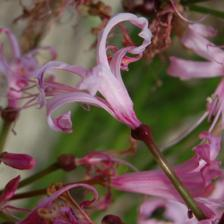

In [19]:
from IPython.display import display
from PIL import Image

input_dir_cnn = "images/input_images_cnn"
test_image = os.listdir(input_dir_cnn)[32]
test_image = os.path.join(input_dir_cnn, test_image)
print(test_image)
display(Image.open(test_image))

In [20]:
img2vec = Img2VecEfficientNetB0()
I = Image.open(test_image)
test_vec = img2vec.getVec(I)
I.close()

print(len(test_vec))
print(test_vec)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1280
[-0.01546171 -0.03996176  0.20059395 ...  0.00250047 -0.06703817
  0.31191817]


In [21]:
from pyspark.ml.linalg import Vectors

test_vector = Vectors.dense(test_vec)
print("Approximately searching lsh_df for 5 nearest neighbors of input vector:")
result = model.approxNearestNeighbors(output, test_vector, 5)
result.show()

Approximately searching lsh_df for 5 nearest neighbors of input vector:
+---------------+--------------------+-------+--------------------+
|            _c0|            features| hashes|             distCol|
+---------------+--------------------+-------+--------------------+
|image_03744.jpg|[-0.015461712,-0....|[[0.0]]|3.304668851012657E-7|
|image_03746.jpg|[-0.08299023,-0.1...|[[0.0]]|   10.86347012036826|
|image_03745.jpg|[-0.17870614,-0.1...|[[0.0]]|   11.06921340941537|
|image_03824.jpg|[-0.1594045,-0.08...|[[0.0]]|  11.201786306954128|
|image_03792.jpg|[-0.110755995,0.2...|[[0.0]]|  11.433996897476412|
+---------------+--------------------+-------+--------------------+



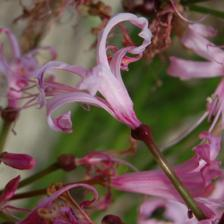

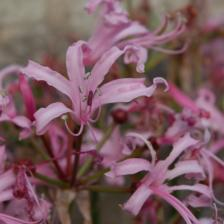

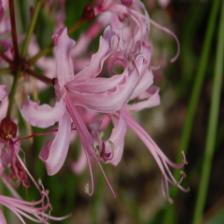

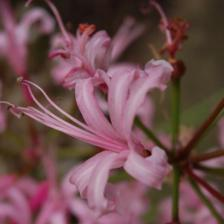

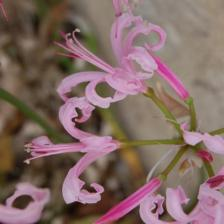

In [22]:
for i in list(result.select('_c0').toPandas()['_c0']):
  display(Image.open(os.path.join(input_dir_cnn, i)))


+---------------+--------------------+--------------------+------------------+
|            _c0|            features|              hashes|           distCol|
+---------------+--------------------+--------------------+------------------+
|image_03744.jpg|(1280,[7,13,18,25...|[[1.4685744E7], [...|               0.0|
|image_03798.jpg|(1280,[7,18,20,25...|[[2.9364225E7], [...|0.5209302325581395|
|image_03801.jpg|(1280,[1,7,13,18,...|[[1.4685744E7], [...|0.5281385281385281|
|image_03785.jpg|(1280,[7,13,20,34...|[[3.8265051E7], [...|0.5302325581395348|
|image_03746.jpg|(1280,[7,13,27,41...|[[3.8265051E7], [...|0.5376344086021505|
+---------------+--------------------+--------------------+------------------+



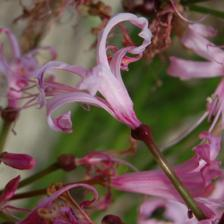

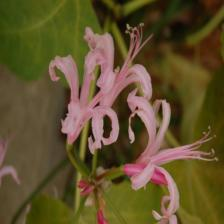

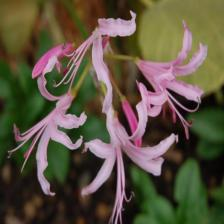

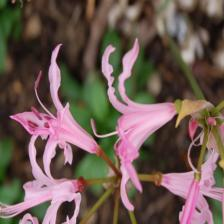

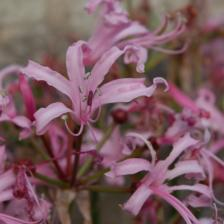

In [28]:
import numpy as np
from pyspark.ml.linalg import SparseVector
from pyspark.ml.feature import MinHashLSH

def binary_dense_vector(vec, threshold=0.5):
    return np.where(np.array(vec) > threshold, 1, 0)

def dense2sparse(binary_vec):
    indices = np.where(binary_vec == 1)[0]
    values = np.ones(len(indices))
    return SparseVector(len(binary_vec), list(zip(indices, values)))

def sparse_row(row):
    binary_features = binary_dense_vector(row.features)
    return dense2sparse(binary_features)

binary_test_vec = binary_dense_vector(test_vec)
sparse_test_vector = dense2sparse(binary_test_vec)

output = output.rdd.map(lambda row: (row._c0, sparse_row(row))).toDF(["_c0", "features"])

minhash = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=10)
minhash_model = minhash.fit(output)
minhash_result = minhash_model.approxNearestNeighbors(output, sparse_test_vector, 5)
minhash_result.show()

for i in list(minhash_result.select('_c0').toPandas()['_c0']):
    display(Image.open(os.path.join(input_dir_cnn, i)))


Image: image_03744.jpg, Similarity: 1.0


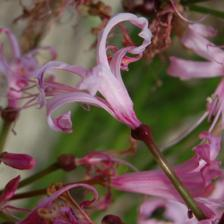

Image: image_03825.jpg, Similarity: 0.7


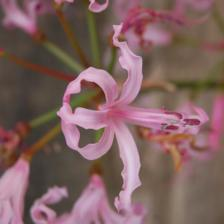

Image: image_03745.jpg, Similarity: 0.68


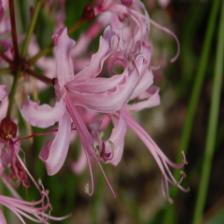

Image: image_03798.jpg, Similarity: 0.68


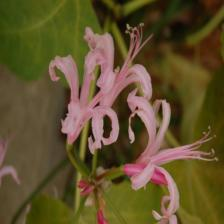

Image: image_03746.jpg, Similarity: 0.68


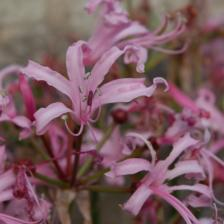

In [35]:
import numpy as np
import os
from PIL import Image
from sklearn.metrics import jaccard_score

def binary_dense_vector(vec, threshold=0.5):
    return np.where(np.array(vec) > threshold, 1, 0)

binary_vectors = {key: binary_dense_vector(vec) for key, vec in allVectors.items()}

num_hashes = 50
vector_length = len(next(iter(binary_vectors.values())))

hash_functions = []
for _ in range(num_hashes):
    a = np.random.randint(1, vector_length, size=1)[0]
    b = np.random.randint(0, vector_length, size=1)[0]
    hash_functions.append((a, b))

def minhash_signature(binary_vec, num_hashes, hash_functions):
    signature = []
    for a, b in hash_functions:
        #h(x) = (a * x + b) % vector_length
        hashed = [(a * i + b) % vector_length for i, val in enumerate(binary_vec) if val == 1]
        if hashed:
            min_value = hashed[0]
            for val in hashed:
                if val < min_value:
                    min_value = val
            signature.append(min_value)
        else:
            signature.append(vector_length + 1)

    return signature

signatures = {key: minhash_signature(vec, num_hashes, hash_functions) for key, vec in binary_vectors.items()}

test_vector_binary = binarize_vector(test_vec)
test_signature = minhash_signature(test_vector_binary, num_hashes, hash_functions)

def jaccard_similarity(signature1, signature2):
    if len(signature1) != len(signature2):
        raise ValueError("len")
    matching_count = 0
    for i in range(len(signature1)):
        if signature1[i] == signature2[i]:
            matching_count += 1

    return matching_count / len(signature1)

similarities = {}
for key, sig in signatures.items():
    similarities[key] = jaccard_similarity(test_signature, sig)

top_5 = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]

for image_name, similarity in top_5:
    print(f"Image: {image_name}, Similarity: {similarity}")
    display(Image.open(os.path.join(input_dir_cnn, image_name)))
